In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
#plt.style.use('fivethirtyeight')

In [2]:
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}

In [3]:
def csusztatas_1(df, p):
    cols_lag1 = [c for c in df if 'lag_1_' in c]
    cols_lag2 = [c for c in df if 'lag_2_' in c]
    cols_lag3 = [c for c in df if 'lag_3_' in c]
    
    #p = p.rename(columns={col: 'lag_1_' + col for col in p.columns})
    df[cols_lag3] = df[cols_lag2]
    df[cols_lag2] = df[cols_lag1]
    df[cols_lag1] = p.values
    df.index = df.index + pd.Timedelta(days=1)
    
    return df
    

In [4]:
def create_lagging_feature(df, lag_number_range=3):
    
    #to_drop_columns = df.columns.tolist()
    #close = df["eth_close"]
    
    for col in df:
        for i in range(1, lag_number_range+1):
            df[f"lag_{i}_{col}"] = df[col].shift(i)
    
    #df = df.drop(to_drop_columns, axis=1) ## minden feature-t szeretnénk prediktálni majd!:)
    #df["eth_close"] = close
    df = df[[col for col in df if "lag_" in col] + [col for col in df if "lag_" not in col]]
    df.dropna(inplace=True)
    
    
    return df

In [5]:
def gridsearch_timeseriessplit(dataframe, original_df, columns, test_size=1, n_future=1, n_past=14, tss_split=10, **kwargs):
    
    tss = TimeSeriesSplit(n_splits=tss_split, test_size=test_size, gap=0) #jo
    df_log = np.log(original_df[1:]) # original df#jo
    
    dataframe = dataframe[columns]
    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []
    n_future = n_future   # Number of days we want to look into the future based on the past days.
    n_past = n_past  # Number of past days we want to use to predict the future.
    
    for train_idx, val_idx in tss.split(dataframe):

        ## Original LOG values

        original_logs = pd.DataFrame()
        original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
        original_logs = original_logs[["eth_close"]]    

        scaler = StandardScaler()
        train = dataframe.iloc[train_idx]
        test = dataframe.iloc[val_idx]

        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)

        for_first_test_x = []
        for_first_test_y = []

        last_x = dataframe[dataframe.iloc[val_idx].first_valid_index()-pd.Timedelta(days=n_past):dataframe.iloc[val_idx].first_valid_index()-pd.Timedelta(days=1)] ## for prediction purpose
        last_x = scaler.transform(last_x).flatten()
        for_first_test_x.append(last_x)
        
        first_y = dataframe.iloc[val_idx].iloc[0:1]
        first_y = scaler.transform(first_y).flatten()
        for_first_test_y.append(first_y)

        for_first_test_x, for_first_test_y = np.array(for_first_test_x), np.array(for_first_test_y)

        #Empty lists to be populated using formatted training data
        trainX = []
        trainY = []

        # FOR TRAINING
        for i in range(n_past, len(train) - n_future +1):
            trainX.append(train[i - n_past:i, :].flatten())
            #trainY.append(train[i + n_future - 1:i + n_future, :].flatten())
            trainY.append(train[i:i+1, :].flatten()) ## one step ahead always since incremental

        trainX, trainY = np.array(trainX), np.array(trainY)
     
        testX = []
        testY = []

        # FOR MODEL FIT VALIDATION
        for i in val_idx:
            testX.append(scaler.transform(dataframe.iloc[i-n_past:i]).flatten())
            #testY.append(scaler.transform(dataframe.iloc[i + n_future - 1:i + n_future, :])) ## one step ahead always since incremental
            testY.append(scaler.transform(dataframe.iloc[i:i+1, :]).flatten()) 

        testX, testY = np.array(testX), np.array(testY)
        print(testX.shape)
        print(testY.shape)
        
        # Fit XGBRegressor model on training set
        model = XGBRegressor(**kwargs)
        model.fit(trainX, trainY, eval_metric="rmse", eval_set=[(trainX, trainY), (testX, testY)])
        print("Model Fitted")
        results = model.evals_result()
        
        y_train_pred = model.predict(trainX)
        train_error = mean_squared_error(trainY, y_train_pred, squared=False)
        
        ## nekem kelleni fog itt a test első index előtti 14 nap ehhez
        last_x = for_first_test_x

        print(last_x.shape) ## (1, 45) várunk
        
        # multi-step forecast - Incremental
        multistep_predictions = [] ##csak úgy tud prediktálni, ha megadom neki az elmúlt 14 napot mindig!:)

        while len(multistep_predictions) < test_size:
            p = model.predict(last_x)
          # update the predictions list
            multistep_predictions.append(p)
            p = p.reshape(1, trainY.shape[1])
            train = np.concatenate([train, p])
            last_x = train[-n_past:]
            last_x = last_x.reshape(1, trainX.shape[1])

        raw_all_prediction = pd.DataFrame(np.vstack(multistep_predictions))
        raw_all_prediction = scaler.inverse_transform(raw_all_prediction) 

        prediction = pd.DataFrame(raw_all_prediction).iloc[:, -1:]
        prediction.index = dataframe.iloc[val_idx].index
        prediction.columns = ["unscaled_predictions"]

        evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)

        ##UN-DIFFERENCING here eth close is log close, ambigous little bit
        x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
        evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff

        ##EXP
        evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
        evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
        evaluation_df = evaluation_df[1:]

        print(evaluation_df)

        try:
            rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
            root_mean_squared_errors.append(rmse)
            mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
            mean_squared_errors.append(mse)        
            mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
            mean_absolute_errors.append(mae)
            mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
            mean_absolute_percentage_errors.append(mape)
        except:
            rmse = np.nan
            mse = np.nan
            mae = np.nan
            mape = np.nan


    print("Tesztelve 10 különböző tanulási/tesztelési adatszetten")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")

    return model, evaluation_df, round(np.mean(root_mean_squared_errors), 4), round(np.mean(mean_squared_errors), 4),round(np.mean(mean_absolute_errors), 4),round(np.mean(mean_absolute_percentage_errors)*100, 4), results['validation_0']['rmse'], results['validation_1']['rmse'], train_error


In [6]:
## Check for stationarity
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

def is_stationary(timeseries):
    """
    Determines if a time series is stationary using the Augmented Dickey-Fuller (ADF) test.

    Parameters:
    timeseries (pandas.Series): The time series to test for stationarity.
    significance_level (float): The significance level used to determine the critical value for the test.

    Returns:
    bool: True if the time series is stationary, False otherwise.
    """

    # Perform ADF test
    adf_result = adfuller(timeseries)

    # Get test statistic and critical values
    test_statistic = adf_result[0]
    critical_values = adf_result[4]
    #print("Result of Dickey-Fuller test:")
    df_output = pd.Series(adf_result[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    
    for key, value in adf_result[4].items():
        df_output["Critical Value (%s)"%key] = value
    #print(df_output)
        
        
    # Compare test statistic to critical values to determine stationarity
    if test_statistic < critical_values['5%']:  ## 5% significance level
        print(True)
        return True
    else:
        print(False)
        return False

In [7]:
df = pd.read_csv('training_dataset.csv', index_col="date", parse_dates=True)

In [8]:
df.index.freq="D"

In [9]:
df.head()

,eth_low,eth_high,eth_open,eth_close,eth_volume,month,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,...,stochastic_oscillator,ma_12,ma_26,ema_12,ema_26,obv,mfi,upper_band,middle_band,lower_band
date,,,,,,,,,,,,,,,,,,,,,
2017-09-01,383.18,394.39,386.44,388.46,4198.68434,2017-09-01,1.635228e+06,4124.0,1564.05531,6.096309e+05,...,96.424850,346.524167,338.660000,346.524167,338.660000,1.378006e+06,88.346876,411.653941,341.8790,272.104059
2017-09-02,320.08,394.32,388.58,343.14,8240.32724,2017-09-01,2.904008e+06,8217.0,2460.66776,8.684873e+05,...,97.629707,348.178333,339.773462,348.178333,339.773462,1.369766e+06,80.426793,411.386517,341.6590,271.931483
2017-09-03,320.08,367.28,343.56,341.77,5253.62211,2017-09-01,1.801703e+06,6153.0,2240.91753,7.679383e+05,...,79.514749,350.842500,340.706923,350.842500,340.706923,1.364512e+06,74.419284,408.329187,340.1235,271.917813
2017-09-04,267.94,344.55,339.29,283.77,6737.81061,2017-09-01,2.002446e+06,7403.0,2954.16805,8.770111e+05,...,78.967144,348.178333,339.138077,348.178333,339.138077,1.357774e+06,67.246410,404.443029,335.1070,265.770971
2017-09-05,235.55,321.52,286.81,312.09,8344.41924,2017-09-01,2.397491e+06,8999.0,4312.97282,1.251959e+06,...,55.783836,347.234167,338.443846,347.234167,338.443846,1.366118e+06,66.412993,396.369992,331.2515,266.133008


In [10]:
df.drop("month", axis=1, inplace=True)

In [11]:
# Find columns that contain negative values
cols_with_negatives = df.columns[df.lt(0).any()]

# Print the column names
print(cols_with_negatives)

Index(['us_treasury_10yt2y_diff', 'us_treasury_10yt3m_diff', 'news_sentiment',
       'reddit_sentiment', 'twitter_sentiment', 'macd', 'signal', 'hist',
       'obv'],
      dtype='object')


In [12]:
df_train = pd.DataFrame()

In [13]:
df_train = np.log(df.drop(columns=cols_with_negatives)).diff()

In [14]:
df_train[cols_with_negatives] = df[cols_with_negatives].diff()

In [15]:
df_train.dropna(inplace=True)

In [16]:
df_train.tail()

,eth_low,eth_high,eth_open,eth_close,eth_volume,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,btc_close,...,lower_band,us_treasury_10yt2y_diff,us_treasury_10yt3m_diff,news_sentiment,reddit_sentiment,twitter_sentiment,macd,signal,hist,obv
date,,,,,,,,,,,,,,,,,,,,,
2023-03-03,-0.047291,-0.017199,-0.010486,-0.048752,0.563021,0.518829,0.447536,0.528380,0.483844,-0.048503,...,0.003778,-0.08,-0.11,0.145015,-0.37660,-0.050198,-6.557431,-2.153053,-4.404378,-742816.5976
2023-03-04,0.003058,-0.044460,-0.048752,-0.001735,-1.139691,-1.143294,-0.824188,-1.134270,-1.137265,-0.000348,...,0.007583,0.00,0.00,0.000000,0.00000,0.035352,-5.462718,-2.814986,-2.647732,-237640.2606
2023-03-05,0.002534,0.007100,-0.001728,-0.001373,0.230490,0.233624,0.132958,0.244556,0.247540,0.003737,...,0.010031,0.00,0.00,-0.548475,0.37660,-0.024841,-4.497313,-3.151451,-1.345862,-299240.7415
2023-03-06,0.000895,-0.003329,-0.001386,0.000805,0.027907,0.026092,-0.019805,0.034782,0.033112,-0.000903,...,0.001444,-0.02,-0.01,0.186043,-0.02715,-0.026412,-3.417668,-3.204695,-0.212973,307709.3011
2023-03-07,-0.011843,0.000631,0.000811,-0.002481,0.352944,0.348050,0.194036,0.386327,0.381367,-0.009507,...,-0.005940,-0.12,-0.12,0.227494,0.00000,0.067933,-2.942873,-3.152330,0.209458,-437947.9032


In [17]:
df_train = df_train[[col for col in df_train if "eth_close" != col] + ["eth_close"]]
df_train.index.freq = "D"

In [18]:
df_train.head() ##STATIONARY

,eth_low,eth_high,eth_open,eth_volume,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,btc_close,btc_volume,...,us_treasury_10yt2y_diff,us_treasury_10yt3m_diff,news_sentiment,reddit_sentiment,twitter_sentiment,macd,signal,hist,obv,eth_close
date,,,,,,,,,,,,,,,,,,,,,
2017-09-02,-0.179934,-0.000178,0.005522,0.674269,0.574310,0.689382,0.453151,0.353899,-0.077995,0.505143,...,0.00,0.00,0.000000,0.405300,-0.034154,-2.470007,0.575782,-3.045789,-8240.32724,-0.124052
2017-09-03,0.000000,-0.071038,-0.123137,-0.450122,-0.477360,-0.289265,-0.093547,-0.123044,0.008226,-0.295816,...,0.00,0.00,0.000000,-0.279555,0.079918,-2.235462,0.013533,-2.248995,-5253.62211,-0.004001
2017-09-04,-0.177808,-0.063885,-0.012507,0.248817,0.105637,0.184946,0.276332,0.132810,-0.095079,0.701942,...,0.00,0.00,0.000000,0.071577,-0.140998,-6.543719,-1.297918,-5.245802,-6737.81061,-0.185974
2017-09-05,-0.128840,-0.069179,-0.168035,0.213858,0.180053,0.195228,0.378410,0.355945,0.062941,-0.126489,...,-0.04,-0.10,-0.217875,0.086044,0.057875,-2.958636,-1.630061,-1.328575,8344.41924,0.095128
2017-09-06,0.281368,0.045063,0.088309,-0.419337,-0.289996,-0.238569,-0.680628,-0.562807,0.056390,-0.420132,...,0.03,-0.01,0.000000,-0.127736,0.078222,-0.547661,-1.413581,0.865920,5486.30988,0.070839


## Train Using Cross Validation

### FEATURE ANALYSIS

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
#BEST AND FINAL OPTION
#(150, 0.1, 100, 0.1, 0.9, 0.5, 5, 0.1, 4)

import itertools

# Define hyperparameter grid
n_estimators = [150]
learning_rate = [0.3]
max_depth = [100]
min_child_weight = [0.1]
subsample = [0.9]
colsample_bytree = [0.5]
gamma = [5]
reg_alpha = [0.1]
reg_lambda = [4]

best_rmse = float('inf')
best_options = None

# Create a list of all possible combinations of hyperparameters
hyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))

print(len(hyperparameters))

1


In [21]:
for params in hyperparameters:
    print(f"Trying hyperparameters: {params}")
    
    
    model, evaluation_df, rmse, mse, mae, mape, train_loss, test_loss, train_error = gridsearch_timeseriessplit(df_train, df, columns=df_train.columns.tolist(),
                                                                            test_size=1, n_past=3, n_future=1,
                                                                            n_estimators=params[0], learning_rate=params[1], max_depth=params[2], min_child_weight=params[3], subsample=params[4], colsample_bytree=params[5], gamma=params[6], reg_alpha=params[7], reg_lambda=params[8])
    

    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = params

Trying hyperparameters: (150, 0.3, 100, 0.1, 0.9, 0.5, 5, 0.1, 4)
(1, 135)
(1, 45)
[0]	validation_0-rmse:0.96106	validation_1-rmse:0.38707
[1]	validation_0-rmse:0.85423	validation_1-rmse:0.32179
[2]	validation_0-rmse:0.78089	validation_1-rmse:0.29824
[3]	validation_0-rmse:0.72839	validation_1-rmse:0.29582



KeyboardInterrupt



In [ ]:
list_of_features = []
for i in range(int(len(model.feature_importances_) / 45), 0, -1):
    row_n = 0
    for z in df_train.columns.to_list():
        feature = f"lag_{i}_{z}"
        list_of_features.append(feature)
        row_n+=1
        if row_n ==45:
            break

In [ ]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(list_of_features, model.feature_importances_)
ax.set_xlabel('Importance Score')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.axvline(0.01, color="black")
plt.tight_layout()
plt.show()

In [ ]:
feature_importances = dict(zip(list_of_features, model.feature_importances_))

In [ ]:
keys = []
values = []
for key, value in feature_importances.items():
    if value > 0.01:
        print(f"{key}: {value}")
        keys.append(key)
        values.append(value)

In [ ]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(keys, values)
ax.set_xlabel('Fontossági pont')
ax.set_ylabel('Magyarázó változók')
ax.set_title('Magyarázó változók fontossága')
ax.axvline(0.01, color="black")
plt.tight_layout()
plt.savefig("charts/forecast/xgb_features.png")
plt.show()

## Most important features

['unique_whales','ma_12','ma_26','ema_12','upper_band','middle_band','lower_band','us_treasury_10yt3m_diff','macd','eth_taker_base_vol','btc_close','rsi','stochastic_oscillator','ema_26','reddit_sentiment','twitter_sentiment','signal','hist','eth_close']


## HyperTuning

## BEST VERSION STANDARD SCALING

## 1 DAY

In [61]:
#BEST AND FINAL OPTION
#(150, 0.1, 100, 0.1, 0.9, 0.5, 5, 0.1, 4)

import itertools


# Define hyperparameter grid
n_estimators = [1200] #250
learning_rate = [0.003] #0.0075 ## minél nagyobb, annál jobban tanul ha kisebb akkor kevésbé overfittel

max_depth = [30] #100 feletti
min_child_weight = [0]
subsample = [0.5] #0.5
colsample_bytree = [0.5]
gamma = [0]
reg_alpha = [0]
reg_lambda = [0]
best_rmse = float('inf')
best_options = None

#best : (250, 0.2, 50, 0, 0.5, 0.5, 0, 2, 2)
# Create a list of all possible combinations of hyperparameters
hyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))

print(len(hyperparameters))

1


In [62]:
cols = ["eth_low", "eth_high", "eth_open", "ma_12", "ma_26", "rsi", "nasdaq_close","sp500_close", "btc_close", "eth_close"]

In [63]:
df_train.columns

Index(['eth_low', 'eth_high', 'eth_open', 'eth_volume', 'eth_qav',
       'eth_num_trades', 'eth_taker_base_vol', 'eth_taker_quote_vol',
       'btc_close', 'btc_volume', 'btc_num_trades', 'btc_qav',
       'fed_eff_funds_rate_close', 'nasdaq_close', 'real_estate_index_close',
       'sp500_close', 'silver_value', 'us_breake_inf_rate_5y',
       'us_breake_inf_rate_10y', 'us_treasury_total_vol', 'gold_value',
       'ethereum_search_trend', 'unique_whales', 'whales_tx_number',
       'whales_tx_total_value', 'rsi', 'stochastic_oscillator', 'ma_12',
       'ma_26', 'ema_12', 'ema_26', 'mfi', 'upper_band', 'middle_band',
       'lower_band', 'us_treasury_10yt2y_diff', 'us_treasury_10yt3m_diff',
       'news_sentiment', 'reddit_sentiment', 'twitter_sentiment', 'macd',
       'signal', 'hist', 'obv', 'eth_close'],
      dtype='object')

In [64]:
for params in hyperparameters:
    print(f"Trying hyperparameters: {params}")
    
    
    model, evaluation_df, rmse, mse, mae, mape, train_loss, test_loss, train_error = gridsearch_timeseriessplit(df_train, df, columns=cols
,
                                                                            test_size=1, n_past=2, n_future=1,
                                                                            n_estimators=params[0], learning_rate=params[1], max_depth=params[2], min_child_weight=params[3], subsample=params[4], colsample_bytree=params[5], gamma=params[6], reg_alpha=params[7], reg_lambda=params[8], early_stopping_rounds=20, n_jobs=-1)
    
    print(model.best_ntree_limit)
    print(model.best_score)
    print(model.best_iteration)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = params

Trying hyperparameters: (1200, 0.003, 30, 0, 0.5, 0.5, 0, 0, 0)
(1, 20)
(1, 10)
[0]	validation_0-rmse:1.11507	validation_1-rmse:0.40407
[1]	validation_0-rmse:1.11263	validation_1-rmse:0.40388
[2]	validation_0-rmse:1.11024	validation_1-rmse:0.40344
[3]	validation_0-rmse:1.10785	validation_1-rmse:0.40337
[4]	validation_0-rmse:1.10545	validation_1-rmse:0.40220
[5]	validation_0-rmse:1.10303	validation_1-rmse:0.40191
[6]	validation_0-rmse:1.10064	validation_1-rmse:0.40103
[7]	validation_0-rmse:1.09825	validation_1-rmse:0.40063
[8]	validation_0-rmse:1.09596	validation_1-rmse:0.40090
[9]	validation_0-rmse:1.09360	validation_1-rmse:0.40066
[10]	validation_0-rmse:1.09126	validation_1-rmse:0.39925
[11]	validation_0-rmse:1.08894	validation_1-rmse:0.39867
[12]	validation_0-rmse:1.08660	validation_1-rmse:0.39718
[13]	validation_0-rmse:1.08430	validation_1-rmse:0.39587
[14]	validation_0-rmse:1.08195	validation_1-rmse:0.39651
[15]	validation_0-rmse:1.07958	validation_1-rmse:0.39617
[16]	validation_0-

[83]	validation_0-rmse:0.93717	validation_1-rmse:0.39040
[84]	validation_0-rmse:0.93522	validation_1-rmse:0.38896
[85]	validation_0-rmse:0.93330	validation_1-rmse:0.38949
[86]	validation_0-rmse:0.93130	validation_1-rmse:0.38890
[87]	validation_0-rmse:0.92941	validation_1-rmse:0.38770
[88]	validation_0-rmse:0.92747	validation_1-rmse:0.38586
[89]	validation_0-rmse:0.92554	validation_1-rmse:0.38530
[90]	validation_0-rmse:0.92365	validation_1-rmse:0.38424
[91]	validation_0-rmse:0.92179	validation_1-rmse:0.38268
[92]	validation_0-rmse:0.91990	validation_1-rmse:0.38190
[93]	validation_0-rmse:0.91804	validation_1-rmse:0.38014
[94]	validation_0-rmse:0.91621	validation_1-rmse:0.37879
[95]	validation_0-rmse:0.91428	validation_1-rmse:0.37880
[96]	validation_0-rmse:0.91245	validation_1-rmse:0.37777
[97]	validation_0-rmse:0.91060	validation_1-rmse:0.37671
[98]	validation_0-rmse:0.90872	validation_1-rmse:0.37559
[99]	validation_0-rmse:0.90682	validation_1-rmse:0.37445
[100]	validation_0-rmse:0.90492

[225]	validation_0-rmse:0.70839	validation_1-rmse:0.30725
[226]	validation_0-rmse:0.70698	validation_1-rmse:0.30667
[227]	validation_0-rmse:0.70561	validation_1-rmse:0.30682
[228]	validation_0-rmse:0.70433	validation_1-rmse:0.30639
[229]	validation_0-rmse:0.70301	validation_1-rmse:0.30610
[230]	validation_0-rmse:0.70167	validation_1-rmse:0.30506
[231]	validation_0-rmse:0.70035	validation_1-rmse:0.30453
[232]	validation_0-rmse:0.69898	validation_1-rmse:0.30451
[233]	validation_0-rmse:0.69763	validation_1-rmse:0.30419
[234]	validation_0-rmse:0.69633	validation_1-rmse:0.30394
[235]	validation_0-rmse:0.69499	validation_1-rmse:0.30352
[236]	validation_0-rmse:0.69367	validation_1-rmse:0.30326
[237]	validation_0-rmse:0.69236	validation_1-rmse:0.30270
[238]	validation_0-rmse:0.69106	validation_1-rmse:0.30193
[239]	validation_0-rmse:0.68970	validation_1-rmse:0.30252
[240]	validation_0-rmse:0.68842	validation_1-rmse:0.30279
[241]	validation_0-rmse:0.68710	validation_1-rmse:0.30256
[242]	validati

[77]	validation_0-rmse:0.94805	validation_1-rmse:0.68403
[78]	validation_0-rmse:0.94605	validation_1-rmse:0.68307
[79]	validation_0-rmse:0.94413	validation_1-rmse:0.68135
[80]	validation_0-rmse:0.94217	validation_1-rmse:0.67904
[81]	validation_0-rmse:0.94026	validation_1-rmse:0.67777
[82]	validation_0-rmse:0.93841	validation_1-rmse:0.67736
[83]	validation_0-rmse:0.93647	validation_1-rmse:0.67670
[84]	validation_0-rmse:0.93455	validation_1-rmse:0.67584
[85]	validation_0-rmse:0.93260	validation_1-rmse:0.67463
[86]	validation_0-rmse:0.93063	validation_1-rmse:0.67412
[87]	validation_0-rmse:0.92878	validation_1-rmse:0.67418
[88]	validation_0-rmse:0.92684	validation_1-rmse:0.67243
[89]	validation_0-rmse:0.92491	validation_1-rmse:0.67125
[90]	validation_0-rmse:0.92299	validation_1-rmse:0.66964
[91]	validation_0-rmse:0.92107	validation_1-rmse:0.66924
[92]	validation_0-rmse:0.91915	validation_1-rmse:0.66784
[93]	validation_0-rmse:0.91730	validation_1-rmse:0.66674
[94]	validation_0-rmse:0.91549	

[219]	validation_0-rmse:0.71557	validation_1-rmse:0.57451
[220]	validation_0-rmse:0.71427	validation_1-rmse:0.57397
[221]	validation_0-rmse:0.71291	validation_1-rmse:0.57277
[222]	validation_0-rmse:0.71153	validation_1-rmse:0.57175
[223]	validation_0-rmse:0.71021	validation_1-rmse:0.57168
[224]	validation_0-rmse:0.70888	validation_1-rmse:0.57111
[225]	validation_0-rmse:0.70758	validation_1-rmse:0.57013
[226]	validation_0-rmse:0.70627	validation_1-rmse:0.56954
[227]	validation_0-rmse:0.70485	validation_1-rmse:0.56847
[228]	validation_0-rmse:0.70357	validation_1-rmse:0.56804
[229]	validation_0-rmse:0.70224	validation_1-rmse:0.56844
[230]	validation_0-rmse:0.70093	validation_1-rmse:0.56791
[231]	validation_0-rmse:0.69967	validation_1-rmse:0.56691
[232]	validation_0-rmse:0.69838	validation_1-rmse:0.56687
[233]	validation_0-rmse:0.69706	validation_1-rmse:0.56605
[234]	validation_0-rmse:0.69580	validation_1-rmse:0.56644
[235]	validation_0-rmse:0.69447	validation_1-rmse:0.56621
[236]	validati

[502]	validation_0-rmse:0.43513	validation_1-rmse:0.47499
[503]	validation_0-rmse:0.43442	validation_1-rmse:0.47477
[504]	validation_0-rmse:0.43375	validation_1-rmse:0.47418
[505]	validation_0-rmse:0.43303	validation_1-rmse:0.47408
[506]	validation_0-rmse:0.43232	validation_1-rmse:0.47314
[507]	validation_0-rmse:0.43160	validation_1-rmse:0.47256
[508]	validation_0-rmse:0.43091	validation_1-rmse:0.47278
[509]	validation_0-rmse:0.43021	validation_1-rmse:0.47245
[510]	validation_0-rmse:0.42948	validation_1-rmse:0.47189
[511]	validation_0-rmse:0.42875	validation_1-rmse:0.47149
[512]	validation_0-rmse:0.42807	validation_1-rmse:0.47127
[513]	validation_0-rmse:0.42736	validation_1-rmse:0.47140
[514]	validation_0-rmse:0.42665	validation_1-rmse:0.47087
[515]	validation_0-rmse:0.42595	validation_1-rmse:0.47077
[516]	validation_0-rmse:0.42524	validation_1-rmse:0.47068
[517]	validation_0-rmse:0.42456	validation_1-rmse:0.47052
[518]	validation_0-rmse:0.42390	validation_1-rmse:0.47067
[519]	validati

[18]	validation_0-rmse:1.07282	validation_1-rmse:0.66633
[19]	validation_0-rmse:1.07052	validation_1-rmse:0.66525
[20]	validation_0-rmse:1.06820	validation_1-rmse:0.66464
[21]	validation_0-rmse:1.06602	validation_1-rmse:0.66326
[22]	validation_0-rmse:1.06373	validation_1-rmse:0.66284
[23]	validation_0-rmse:1.06151	validation_1-rmse:0.66195
[24]	validation_0-rmse:1.05936	validation_1-rmse:0.66160
[25]	validation_0-rmse:1.05714	validation_1-rmse:0.65987
[26]	validation_0-rmse:1.05488	validation_1-rmse:0.65922
[27]	validation_0-rmse:1.05260	validation_1-rmse:0.65880
[28]	validation_0-rmse:1.05047	validation_1-rmse:0.65670
[29]	validation_0-rmse:1.04826	validation_1-rmse:0.65559
[30]	validation_0-rmse:1.04604	validation_1-rmse:0.65359
[31]	validation_0-rmse:1.04387	validation_1-rmse:0.65194
[32]	validation_0-rmse:1.04164	validation_1-rmse:0.65059
[33]	validation_0-rmse:1.03938	validation_1-rmse:0.64906
[34]	validation_0-rmse:1.03717	validation_1-rmse:0.64943
[35]	validation_0-rmse:1.03497	

[4]	validation_0-rmse:1.10562	validation_1-rmse:0.53857
[5]	validation_0-rmse:1.10332	validation_1-rmse:0.53764
[6]	validation_0-rmse:1.10104	validation_1-rmse:0.53790
[7]	validation_0-rmse:1.09869	validation_1-rmse:0.53690
[8]	validation_0-rmse:1.09630	validation_1-rmse:0.53704
[9]	validation_0-rmse:1.09394	validation_1-rmse:0.53557
[10]	validation_0-rmse:1.09168	validation_1-rmse:0.53481
[11]	validation_0-rmse:1.08941	validation_1-rmse:0.53374
[12]	validation_0-rmse:1.08706	validation_1-rmse:0.53300
[13]	validation_0-rmse:1.08473	validation_1-rmse:0.53212
[14]	validation_0-rmse:1.08245	validation_1-rmse:0.53111
[15]	validation_0-rmse:1.08008	validation_1-rmse:0.52999
[16]	validation_0-rmse:1.07773	validation_1-rmse:0.52836
[17]	validation_0-rmse:1.07545	validation_1-rmse:0.52743
[18]	validation_0-rmse:1.07321	validation_1-rmse:0.52649
[19]	validation_0-rmse:1.07093	validation_1-rmse:0.52421
[20]	validation_0-rmse:1.06861	validation_1-rmse:0.52350
[21]	validation_0-rmse:1.06645	valida

[288]	validation_0-rmse:0.62997	validation_1-rmse:0.38343
[289]	validation_0-rmse:0.62878	validation_1-rmse:0.38265
[290]	validation_0-rmse:0.62756	validation_1-rmse:0.38270
[291]	validation_0-rmse:0.62643	validation_1-rmse:0.38237
[292]	validation_0-rmse:0.62526	validation_1-rmse:0.38171
[293]	validation_0-rmse:0.62410	validation_1-rmse:0.38111
[294]	validation_0-rmse:0.62298	validation_1-rmse:0.38047
[295]	validation_0-rmse:0.62185	validation_1-rmse:0.38009
[296]	validation_0-rmse:0.62074	validation_1-rmse:0.37999
[297]	validation_0-rmse:0.61959	validation_1-rmse:0.38049
[298]	validation_0-rmse:0.61845	validation_1-rmse:0.38061
[299]	validation_0-rmse:0.61726	validation_1-rmse:0.37962
[300]	validation_0-rmse:0.61613	validation_1-rmse:0.37971
[301]	validation_0-rmse:0.61499	validation_1-rmse:0.37910
[302]	validation_0-rmse:0.61388	validation_1-rmse:0.37901
[303]	validation_0-rmse:0.61275	validation_1-rmse:0.37836
[304]	validation_0-rmse:0.61161	validation_1-rmse:0.37777
[305]	validati

[430]	validation_0-rmse:0.49025	validation_1-rmse:0.34740
[431]	validation_0-rmse:0.48940	validation_1-rmse:0.34708
[432]	validation_0-rmse:0.48860	validation_1-rmse:0.34717
[433]	validation_0-rmse:0.48780	validation_1-rmse:0.34712
[434]	validation_0-rmse:0.48700	validation_1-rmse:0.34780
[435]	validation_0-rmse:0.48618	validation_1-rmse:0.34750
[436]	validation_0-rmse:0.48539	validation_1-rmse:0.34800
[437]	validation_0-rmse:0.48459	validation_1-rmse:0.34788
[438]	validation_0-rmse:0.48378	validation_1-rmse:0.34734
[439]	validation_0-rmse:0.48292	validation_1-rmse:0.34684
[440]	validation_0-rmse:0.48212	validation_1-rmse:0.34686
[441]	validation_0-rmse:0.48131	validation_1-rmse:0.34649
[442]	validation_0-rmse:0.48051	validation_1-rmse:0.34579
[443]	validation_0-rmse:0.47969	validation_1-rmse:0.34570
[444]	validation_0-rmse:0.47885	validation_1-rmse:0.34574
[445]	validation_0-rmse:0.47803	validation_1-rmse:0.34579
[446]	validation_0-rmse:0.47724	validation_1-rmse:0.34602
[447]	validati

[213]	validation_0-rmse:0.72415	validation_1-rmse:1.16849
[214]	validation_0-rmse:0.72277	validation_1-rmse:1.16877
[215]	validation_0-rmse:0.72142	validation_1-rmse:1.16825
[216]	validation_0-rmse:0.72003	validation_1-rmse:1.16792
[217]	validation_0-rmse:0.71865	validation_1-rmse:1.16687
[218]	validation_0-rmse:0.71729	validation_1-rmse:1.16671
[219]	validation_0-rmse:0.71595	validation_1-rmse:1.16633
[220]	validation_0-rmse:0.71461	validation_1-rmse:1.16706
[221]	validation_0-rmse:0.71330	validation_1-rmse:1.16609
[222]	validation_0-rmse:0.71195	validation_1-rmse:1.16594
[223]	validation_0-rmse:0.71058	validation_1-rmse:1.16604
[224]	validation_0-rmse:0.70926	validation_1-rmse:1.16675
[225]	validation_0-rmse:0.70796	validation_1-rmse:1.16654
[226]	validation_0-rmse:0.70656	validation_1-rmse:1.16639
[227]	validation_0-rmse:0.70525	validation_1-rmse:1.16536
[228]	validation_0-rmse:0.70389	validation_1-rmse:1.16578
[229]	validation_0-rmse:0.70252	validation_1-rmse:1.16587
[230]	validati

[355]	validation_0-rmse:0.55853	validation_1-rmse:1.13717
[356]	validation_0-rmse:0.55753	validation_1-rmse:1.13784
[357]	validation_0-rmse:0.55657	validation_1-rmse:1.13805
[358]	validation_0-rmse:0.55558	validation_1-rmse:1.13807
[359]	validation_0-rmse:0.55456	validation_1-rmse:1.13822
[360]	validation_0-rmse:0.55359	validation_1-rmse:1.13790
[361]	validation_0-rmse:0.55261	validation_1-rmse:1.13785
[362]	validation_0-rmse:0.55161	validation_1-rmse:1.13737
[363]	validation_0-rmse:0.55062	validation_1-rmse:1.13724
[364]	validation_0-rmse:0.54966	validation_1-rmse:1.13754
[365]	validation_0-rmse:0.54874	validation_1-rmse:1.13713
[366]	validation_0-rmse:0.54776	validation_1-rmse:1.13705
[367]	validation_0-rmse:0.54680	validation_1-rmse:1.13656
[368]	validation_0-rmse:0.54583	validation_1-rmse:1.13677
[369]	validation_0-rmse:0.54493	validation_1-rmse:1.13606
[370]	validation_0-rmse:0.54399	validation_1-rmse:1.13561
[371]	validation_0-rmse:0.54305	validation_1-rmse:1.13570
[372]	validati

[189]	validation_0-rmse:0.75887	validation_1-rmse:0.48697
[190]	validation_0-rmse:0.75740	validation_1-rmse:0.48547
[191]	validation_0-rmse:0.75593	validation_1-rmse:0.48397
[192]	validation_0-rmse:0.75449	validation_1-rmse:0.48273
[193]	validation_0-rmse:0.75304	validation_1-rmse:0.48142
[194]	validation_0-rmse:0.75160	validation_1-rmse:0.48016
[195]	validation_0-rmse:0.75014	validation_1-rmse:0.47868
[196]	validation_0-rmse:0.74874	validation_1-rmse:0.47714
[197]	validation_0-rmse:0.74722	validation_1-rmse:0.47581
[198]	validation_0-rmse:0.74575	validation_1-rmse:0.47395
[199]	validation_0-rmse:0.74432	validation_1-rmse:0.47190
[200]	validation_0-rmse:0.74290	validation_1-rmse:0.47138
[201]	validation_0-rmse:0.74147	validation_1-rmse:0.47045
[202]	validation_0-rmse:0.74004	validation_1-rmse:0.46917
[203]	validation_0-rmse:0.73867	validation_1-rmse:0.46836
[204]	validation_0-rmse:0.73732	validation_1-rmse:0.46675
[205]	validation_0-rmse:0.73586	validation_1-rmse:0.46579
[206]	validati

[331]	validation_0-rmse:0.58315	validation_1-rmse:0.38810
[332]	validation_0-rmse:0.58209	validation_1-rmse:0.38788
[333]	validation_0-rmse:0.58105	validation_1-rmse:0.38834
[334]	validation_0-rmse:0.58003	validation_1-rmse:0.38816
[335]	validation_0-rmse:0.57896	validation_1-rmse:0.38817
[336]	validation_0-rmse:0.57793	validation_1-rmse:0.38797
[337]	validation_0-rmse:0.57687	validation_1-rmse:0.38714
[338]	validation_0-rmse:0.57579	validation_1-rmse:0.38632
[339]	validation_0-rmse:0.57478	validation_1-rmse:0.38647
[340]	validation_0-rmse:0.57379	validation_1-rmse:0.38576
[341]	validation_0-rmse:0.57276	validation_1-rmse:0.38571
[342]	validation_0-rmse:0.57172	validation_1-rmse:0.38503
[343]	validation_0-rmse:0.57074	validation_1-rmse:0.38543
[344]	validation_0-rmse:0.56970	validation_1-rmse:0.38535
[345]	validation_0-rmse:0.56870	validation_1-rmse:0.38512
[346]	validation_0-rmse:0.56771	validation_1-rmse:0.38468
[347]	validation_0-rmse:0.56671	validation_1-rmse:0.38478
[348]	validati

[199]	validation_0-rmse:0.74470	validation_1-rmse:0.32420
[200]	validation_0-rmse:0.74331	validation_1-rmse:0.32315
[201]	validation_0-rmse:0.74189	validation_1-rmse:0.32253
[202]	validation_0-rmse:0.74041	validation_1-rmse:0.32142
[203]	validation_0-rmse:0.73898	validation_1-rmse:0.32081
[204]	validation_0-rmse:0.73758	validation_1-rmse:0.31998
[205]	validation_0-rmse:0.73613	validation_1-rmse:0.31944
[206]	validation_0-rmse:0.73479	validation_1-rmse:0.31850
[207]	validation_0-rmse:0.73344	validation_1-rmse:0.31779
[208]	validation_0-rmse:0.73205	validation_1-rmse:0.31715
[209]	validation_0-rmse:0.73068	validation_1-rmse:0.31639
[210]	validation_0-rmse:0.72929	validation_1-rmse:0.31558
[211]	validation_0-rmse:0.72793	validation_1-rmse:0.31447
[212]	validation_0-rmse:0.72650	validation_1-rmse:0.31430
[213]	validation_0-rmse:0.72513	validation_1-rmse:0.31376
[214]	validation_0-rmse:0.72373	validation_1-rmse:0.31372
[215]	validation_0-rmse:0.72244	validation_1-rmse:0.31309
[216]	validati

[341]	validation_0-rmse:0.57342	validation_1-rmse:0.22463
[342]	validation_0-rmse:0.57243	validation_1-rmse:0.22386
[343]	validation_0-rmse:0.57137	validation_1-rmse:0.22315
[344]	validation_0-rmse:0.57034	validation_1-rmse:0.22247
[345]	validation_0-rmse:0.56933	validation_1-rmse:0.22171
[346]	validation_0-rmse:0.56827	validation_1-rmse:0.22169
[347]	validation_0-rmse:0.56728	validation_1-rmse:0.22185
[348]	validation_0-rmse:0.56630	validation_1-rmse:0.22164
[349]	validation_0-rmse:0.56532	validation_1-rmse:0.22129
[350]	validation_0-rmse:0.56431	validation_1-rmse:0.22184
[351]	validation_0-rmse:0.56338	validation_1-rmse:0.22140
[352]	validation_0-rmse:0.56242	validation_1-rmse:0.22118
[353]	validation_0-rmse:0.56147	validation_1-rmse:0.22076
[354]	validation_0-rmse:0.56045	validation_1-rmse:0.22049
[355]	validation_0-rmse:0.55943	validation_1-rmse:0.21994
[356]	validation_0-rmse:0.55839	validation_1-rmse:0.21866
[357]	validation_0-rmse:0.55746	validation_1-rmse:0.21812
[358]	validati

[483]	validation_0-rmse:0.44980	validation_1-rmse:0.17354
[484]	validation_0-rmse:0.44903	validation_1-rmse:0.17310
[485]	validation_0-rmse:0.44833	validation_1-rmse:0.17258
[486]	validation_0-rmse:0.44762	validation_1-rmse:0.17211
[487]	validation_0-rmse:0.44688	validation_1-rmse:0.17200
[488]	validation_0-rmse:0.44614	validation_1-rmse:0.17190
[489]	validation_0-rmse:0.44540	validation_1-rmse:0.17143
[490]	validation_0-rmse:0.44467	validation_1-rmse:0.17146
[491]	validation_0-rmse:0.44394	validation_1-rmse:0.17154
[492]	validation_0-rmse:0.44322	validation_1-rmse:0.17127
[493]	validation_0-rmse:0.44248	validation_1-rmse:0.17109
[494]	validation_0-rmse:0.44176	validation_1-rmse:0.17084
[495]	validation_0-rmse:0.44102	validation_1-rmse:0.17080
[496]	validation_0-rmse:0.44024	validation_1-rmse:0.17044
[497]	validation_0-rmse:0.43952	validation_1-rmse:0.17053
[498]	validation_0-rmse:0.43882	validation_1-rmse:0.17012
[499]	validation_0-rmse:0.43814	validation_1-rmse:0.16963
[500]	validati

[625]	validation_0-rmse:0.35847	validation_1-rmse:0.14151
[626]	validation_0-rmse:0.35791	validation_1-rmse:0.14124
[627]	validation_0-rmse:0.35737	validation_1-rmse:0.14114
[628]	validation_0-rmse:0.35686	validation_1-rmse:0.14095
[629]	validation_0-rmse:0.35630	validation_1-rmse:0.14062
[630]	validation_0-rmse:0.35578	validation_1-rmse:0.14013
[631]	validation_0-rmse:0.35526	validation_1-rmse:0.14019
[632]	validation_0-rmse:0.35473	validation_1-rmse:0.14066
[633]	validation_0-rmse:0.35422	validation_1-rmse:0.14033
[634]	validation_0-rmse:0.35371	validation_1-rmse:0.14034
[635]	validation_0-rmse:0.35315	validation_1-rmse:0.14009
[636]	validation_0-rmse:0.35259	validation_1-rmse:0.13995
[637]	validation_0-rmse:0.35204	validation_1-rmse:0.13966
[638]	validation_0-rmse:0.35148	validation_1-rmse:0.13943
[639]	validation_0-rmse:0.35093	validation_1-rmse:0.13907
[640]	validation_0-rmse:0.35041	validation_1-rmse:0.13913
[641]	validation_0-rmse:0.34988	validation_1-rmse:0.13884
[642]	validati

[767]	validation_0-rmse:0.28912	validation_1-rmse:0.12736
[768]	validation_0-rmse:0.28868	validation_1-rmse:0.12717
[769]	validation_0-rmse:0.28829	validation_1-rmse:0.12703
[770]	validation_0-rmse:0.28791	validation_1-rmse:0.12729
[771]	validation_0-rmse:0.28747	validation_1-rmse:0.12708
[772]	validation_0-rmse:0.28704	validation_1-rmse:0.12685
[773]	validation_0-rmse:0.28667	validation_1-rmse:0.12653
[774]	validation_0-rmse:0.28624	validation_1-rmse:0.12648
[775]	validation_0-rmse:0.28584	validation_1-rmse:0.12634
[776]	validation_0-rmse:0.28546	validation_1-rmse:0.12624
[777]	validation_0-rmse:0.28502	validation_1-rmse:0.12623
[778]	validation_0-rmse:0.28462	validation_1-rmse:0.12596
[779]	validation_0-rmse:0.28418	validation_1-rmse:0.12611
[780]	validation_0-rmse:0.28375	validation_1-rmse:0.12607
[781]	validation_0-rmse:0.28332	validation_1-rmse:0.12607
[782]	validation_0-rmse:0.28288	validation_1-rmse:0.12639
[783]	validation_0-rmse:0.28246	validation_1-rmse:0.12628
[784]	validati

[245]	validation_0-rmse:0.68141	validation_1-rmse:0.27516
[246]	validation_0-rmse:0.68021	validation_1-rmse:0.27471
[247]	validation_0-rmse:0.67892	validation_1-rmse:0.27349
[248]	validation_0-rmse:0.67761	validation_1-rmse:0.27269
[249]	validation_0-rmse:0.67633	validation_1-rmse:0.27187
[250]	validation_0-rmse:0.67501	validation_1-rmse:0.27107
[251]	validation_0-rmse:0.67374	validation_1-rmse:0.27046
[252]	validation_0-rmse:0.67259	validation_1-rmse:0.26993
[253]	validation_0-rmse:0.67134	validation_1-rmse:0.26891
[254]	validation_0-rmse:0.67013	validation_1-rmse:0.26804
[255]	validation_0-rmse:0.66888	validation_1-rmse:0.26761
[256]	validation_0-rmse:0.66764	validation_1-rmse:0.26663
[257]	validation_0-rmse:0.66638	validation_1-rmse:0.26565
[258]	validation_0-rmse:0.66516	validation_1-rmse:0.26445
[259]	validation_0-rmse:0.66392	validation_1-rmse:0.26374
[260]	validation_0-rmse:0.66267	validation_1-rmse:0.26288
[261]	validation_0-rmse:0.66144	validation_1-rmse:0.26284
[262]	validati

[387]	validation_0-rmse:0.52776	validation_1-rmse:0.18774
[388]	validation_0-rmse:0.52686	validation_1-rmse:0.18736
[389]	validation_0-rmse:0.52596	validation_1-rmse:0.18670
[390]	validation_0-rmse:0.52505	validation_1-rmse:0.18603
[391]	validation_0-rmse:0.52412	validation_1-rmse:0.18578
[392]	validation_0-rmse:0.52323	validation_1-rmse:0.18546
[393]	validation_0-rmse:0.52236	validation_1-rmse:0.18483
[394]	validation_0-rmse:0.52145	validation_1-rmse:0.18477
[395]	validation_0-rmse:0.52052	validation_1-rmse:0.18441
[396]	validation_0-rmse:0.51959	validation_1-rmse:0.18424
[397]	validation_0-rmse:0.51870	validation_1-rmse:0.18388
[398]	validation_0-rmse:0.51780	validation_1-rmse:0.18341
[399]	validation_0-rmse:0.51690	validation_1-rmse:0.18335
[400]	validation_0-rmse:0.51596	validation_1-rmse:0.18284
[401]	validation_0-rmse:0.51508	validation_1-rmse:0.18263
[402]	validation_0-rmse:0.51414	validation_1-rmse:0.18215
[403]	validation_0-rmse:0.51329	validation_1-rmse:0.18160
[404]	validati

[529]	validation_0-rmse:0.41580	validation_1-rmse:0.14620
[530]	validation_0-rmse:0.41516	validation_1-rmse:0.14607
[531]	validation_0-rmse:0.41451	validation_1-rmse:0.14571
[532]	validation_0-rmse:0.41388	validation_1-rmse:0.14539
[533]	validation_0-rmse:0.41320	validation_1-rmse:0.14528
[534]	validation_0-rmse:0.41255	validation_1-rmse:0.14533
[535]	validation_0-rmse:0.41188	validation_1-rmse:0.14498
[536]	validation_0-rmse:0.41121	validation_1-rmse:0.14474
[537]	validation_0-rmse:0.41055	validation_1-rmse:0.14454
[538]	validation_0-rmse:0.40990	validation_1-rmse:0.14438
[539]	validation_0-rmse:0.40924	validation_1-rmse:0.14430
[540]	validation_0-rmse:0.40860	validation_1-rmse:0.14432
[541]	validation_0-rmse:0.40794	validation_1-rmse:0.14415
[542]	validation_0-rmse:0.40735	validation_1-rmse:0.14423
[543]	validation_0-rmse:0.40673	validation_1-rmse:0.14405
[544]	validation_0-rmse:0.40613	validation_1-rmse:0.14384
[545]	validation_0-rmse:0.40549	validation_1-rmse:0.14365
[546]	validati

[196]	validation_0-rmse:0.74937	validation_1-rmse:0.73234
[197]	validation_0-rmse:0.74790	validation_1-rmse:0.73107
[198]	validation_0-rmse:0.74641	validation_1-rmse:0.73083
[199]	validation_0-rmse:0.74498	validation_1-rmse:0.73078
[200]	validation_0-rmse:0.74357	validation_1-rmse:0.72899
[201]	validation_0-rmse:0.74218	validation_1-rmse:0.72838
[202]	validation_0-rmse:0.74077	validation_1-rmse:0.72788
[203]	validation_0-rmse:0.73934	validation_1-rmse:0.72669
[204]	validation_0-rmse:0.73793	validation_1-rmse:0.72597
[205]	validation_0-rmse:0.73654	validation_1-rmse:0.72531
[206]	validation_0-rmse:0.73510	validation_1-rmse:0.72432
[207]	validation_0-rmse:0.73373	validation_1-rmse:0.72358
[208]	validation_0-rmse:0.73233	validation_1-rmse:0.72326
[209]	validation_0-rmse:0.73093	validation_1-rmse:0.72265
[210]	validation_0-rmse:0.72948	validation_1-rmse:0.72248
[211]	validation_0-rmse:0.72803	validation_1-rmse:0.72183
[212]	validation_0-rmse:0.72664	validation_1-rmse:0.72093
[213]	validati

[479]	validation_0-rmse:0.45227	validation_1-rmse:0.60368
[480]	validation_0-rmse:0.45152	validation_1-rmse:0.60429
[481]	validation_0-rmse:0.45079	validation_1-rmse:0.60410
[482]	validation_0-rmse:0.45005	validation_1-rmse:0.60395
[483]	validation_0-rmse:0.44932	validation_1-rmse:0.60377
[484]	validation_0-rmse:0.44859	validation_1-rmse:0.60428
[485]	validation_0-rmse:0.44781	validation_1-rmse:0.60375
[486]	validation_0-rmse:0.44708	validation_1-rmse:0.60286
[487]	validation_0-rmse:0.44630	validation_1-rmse:0.60205
[488]	validation_0-rmse:0.44559	validation_1-rmse:0.60161
[489]	validation_0-rmse:0.44485	validation_1-rmse:0.60143
[490]	validation_0-rmse:0.44412	validation_1-rmse:0.60122
[491]	validation_0-rmse:0.44343	validation_1-rmse:0.60091
[492]	validation_0-rmse:0.44270	validation_1-rmse:0.60065
[493]	validation_0-rmse:0.44195	validation_1-rmse:0.60035
[494]	validation_0-rmse:0.44124	validation_1-rmse:0.60017
[495]	validation_0-rmse:0.44052	validation_1-rmse:0.59974
[496]	validati

[621]	validation_0-rmse:0.36027	validation_1-rmse:0.57008
[622]	validation_0-rmse:0.35970	validation_1-rmse:0.56947
[623]	validation_0-rmse:0.35910	validation_1-rmse:0.56915
[624]	validation_0-rmse:0.35857	validation_1-rmse:0.56894
[625]	validation_0-rmse:0.35802	validation_1-rmse:0.56885
[626]	validation_0-rmse:0.35745	validation_1-rmse:0.56868
[627]	validation_0-rmse:0.35691	validation_1-rmse:0.56920
[628]	validation_0-rmse:0.35634	validation_1-rmse:0.56861
[629]	validation_0-rmse:0.35578	validation_1-rmse:0.56844
[630]	validation_0-rmse:0.35523	validation_1-rmse:0.56870
[631]	validation_0-rmse:0.35468	validation_1-rmse:0.56836
[632]	validation_0-rmse:0.35411	validation_1-rmse:0.56837
[633]	validation_0-rmse:0.35358	validation_1-rmse:0.56784
[634]	validation_0-rmse:0.35302	validation_1-rmse:0.56792
[635]	validation_0-rmse:0.35248	validation_1-rmse:0.56779
[636]	validation_0-rmse:0.35195	validation_1-rmse:0.56755
[637]	validation_0-rmse:0.35140	validation_1-rmse:0.56742
[638]	validati

[763]	validation_0-rmse:0.29011	validation_1-rmse:0.54705
[764]	validation_0-rmse:0.28970	validation_1-rmse:0.54680
[765]	validation_0-rmse:0.28930	validation_1-rmse:0.54666
[766]	validation_0-rmse:0.28885	validation_1-rmse:0.54660
[767]	validation_0-rmse:0.28843	validation_1-rmse:0.54629
[768]	validation_0-rmse:0.28800	validation_1-rmse:0.54625
[769]	validation_0-rmse:0.28759	validation_1-rmse:0.54596
[770]	validation_0-rmse:0.28716	validation_1-rmse:0.54585
[771]	validation_0-rmse:0.28674	validation_1-rmse:0.54553
[772]	validation_0-rmse:0.28631	validation_1-rmse:0.54547
[773]	validation_0-rmse:0.28590	validation_1-rmse:0.54563
[774]	validation_0-rmse:0.28550	validation_1-rmse:0.54545
[775]	validation_0-rmse:0.28506	validation_1-rmse:0.54521
[776]	validation_0-rmse:0.28464	validation_1-rmse:0.54523
[777]	validation_0-rmse:0.28422	validation_1-rmse:0.54505
[778]	validation_0-rmse:0.28378	validation_1-rmse:0.54489
[779]	validation_0-rmse:0.28336	validation_1-rmse:0.54510
[780]	validati

[905]	validation_0-rmse:0.23598	validation_1-rmse:0.53126
[906]	validation_0-rmse:0.23565	validation_1-rmse:0.53057
[907]	validation_0-rmse:0.23531	validation_1-rmse:0.53035
[908]	validation_0-rmse:0.23498	validation_1-rmse:0.53032
[909]	validation_0-rmse:0.23466	validation_1-rmse:0.53033
[910]	validation_0-rmse:0.23434	validation_1-rmse:0.53006
[911]	validation_0-rmse:0.23400	validation_1-rmse:0.52998
[912]	validation_0-rmse:0.23366	validation_1-rmse:0.53000
[913]	validation_0-rmse:0.23332	validation_1-rmse:0.52993
[914]	validation_0-rmse:0.23298	validation_1-rmse:0.52927
[915]	validation_0-rmse:0.23265	validation_1-rmse:0.52916
[916]	validation_0-rmse:0.23230	validation_1-rmse:0.52915
[917]	validation_0-rmse:0.23199	validation_1-rmse:0.52912
[918]	validation_0-rmse:0.23166	validation_1-rmse:0.52900
[919]	validation_0-rmse:0.23132	validation_1-rmse:0.52854
[920]	validation_0-rmse:0.23099	validation_1-rmse:0.52808
[921]	validation_0-rmse:0.23064	validation_1-rmse:0.52802
[922]	validati

[1046]	validation_0-rmse:0.19363	validation_1-rmse:0.51854
[1047]	validation_0-rmse:0.19337	validation_1-rmse:0.51841
[1048]	validation_0-rmse:0.19310	validation_1-rmse:0.51851
[1049]	validation_0-rmse:0.19284	validation_1-rmse:0.51840
[1050]	validation_0-rmse:0.19258	validation_1-rmse:0.51842
[1051]	validation_0-rmse:0.19231	validation_1-rmse:0.51830
[1052]	validation_0-rmse:0.19205	validation_1-rmse:0.51822
[1053]	validation_0-rmse:0.19178	validation_1-rmse:0.51831
[1054]	validation_0-rmse:0.19151	validation_1-rmse:0.51857
[1055]	validation_0-rmse:0.19124	validation_1-rmse:0.51904
[1056]	validation_0-rmse:0.19098	validation_1-rmse:0.51901
[1057]	validation_0-rmse:0.19071	validation_1-rmse:0.51885
[1058]	validation_0-rmse:0.19045	validation_1-rmse:0.51905
[1059]	validation_0-rmse:0.19020	validation_1-rmse:0.51881
[1060]	validation_0-rmse:0.18992	validation_1-rmse:0.51904
[1061]	validation_0-rmse:0.18966	validation_1-rmse:0.51883
[1062]	validation_0-rmse:0.18939	validation_1-rmse:0.518

[1185]	validation_0-rmse:0.16024	validation_1-rmse:0.51179
[1186]	validation_0-rmse:0.16002	validation_1-rmse:0.51180
[1187]	validation_0-rmse:0.15978	validation_1-rmse:0.51176
[1188]	validation_0-rmse:0.15959	validation_1-rmse:0.51153
[1189]	validation_0-rmse:0.15939	validation_1-rmse:0.51142
[1190]	validation_0-rmse:0.15918	validation_1-rmse:0.51144
[1191]	validation_0-rmse:0.15897	validation_1-rmse:0.51145
[1192]	validation_0-rmse:0.15877	validation_1-rmse:0.51155
[1193]	validation_0-rmse:0.15858	validation_1-rmse:0.51149
[1194]	validation_0-rmse:0.15836	validation_1-rmse:0.51146
[1195]	validation_0-rmse:0.15814	validation_1-rmse:0.51137
[1196]	validation_0-rmse:0.15794	validation_1-rmse:0.51144
[1197]	validation_0-rmse:0.15774	validation_1-rmse:0.51125
[1198]	validation_0-rmse:0.15754	validation_1-rmse:0.51127
[1199]	validation_0-rmse:0.15734	validation_1-rmse:0.51125
Model Fitted
(1, 20)
            eth_close  unscaled_predictions  log_prediction  true_values  \
date              

In [65]:
best_rmse #26 standarddal

28.566

In [66]:
model.best_ntree_limit

1198

In [67]:
#When the validation loss is not decreasing, that means the model might be overfitting to the training data.

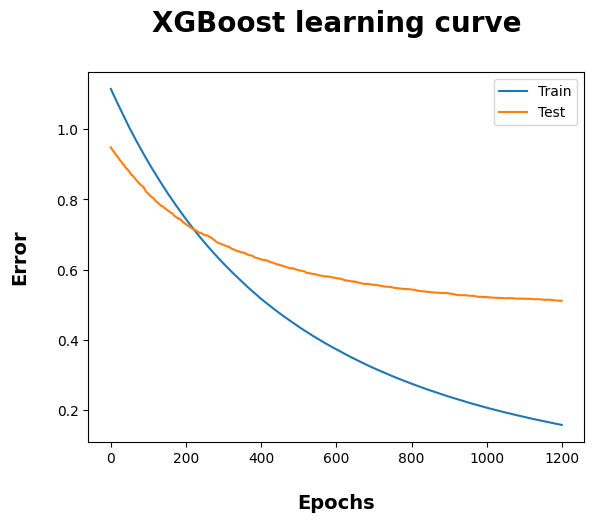

In [68]:
epochs = len(train_loss)
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, train_loss, label='Train')
ax.plot(x_axis, test_loss, label='Test')
ax.legend()
plt.xlabel('\nEpochs',fontsize=14,fontweight='semibold',color='black')
plt.ylabel('Error\n',fontsize=14,fontweight='semibold',color='black')
plt.title('XGBoost learning curve\n',fontsize=20,fontweight='semibold',color='black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.show()

In [31]:
# Open the file in append mode
"""
cols = ['eth_taker_base_vol', 'eth_taker_quote_vol', 'sp500_close', 'us_breake_inf_rate_5y',
       'unique_whales', 'rsi', 'ma_12', 'ma_26',
       'upper_band', 'middle_band', 'lower_band',
       'macd', 'signal', 'hist', 'obv',
       'eth_close']

with open('gridsearch_results/xgb_results_1day.txt', 'w') as file:
    # Write the hyperparameters and evaluation metrics to the file
    file.write("Nestimators, Learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, RMSE, MSE, MAE, MAPE, train_error\n")

    
best_rmse = float('inf')
best_options = None

# Create a list of all possible combinations of hyperparameters
hyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))

# Loop over all combinations of hyperparameters
for params in hyperparameters:
    print(f"Trying hyperparameters: {params}")
    
    
    model, evaluation_df, rmse, mse, mae, mape, train_loss, test_loss, train_error = gridsearch_timeseriessplit(df_train, df, columns=cols,
                                                                            test_size=1,
                                                                            n_estimators=params[0], learning_rate=params[1], max_depth=params[2], min_child_weight=params[3], subsample=params[4], colsample_bytree=params[5], gamma=params[6], reg_alpha=params[7], reg_lambda=params[8], early_stopping_rounds=30)
    

    with open('gridsearch_results/xgb_results_1day.txt', 'a') as file:
        file.write(f"{params[0]}, {params[1]}, {params[2]}, {params[3]}, {params[4]}, {params[5]}, {params[6]}, {params[7]}, {params[8]}, {rmse},{mse}, {mae}, {mape}, {train_error}\n")

    print(model.best_ntree_limit)
    print(model.best_score)
    print(model.best_iteration)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = params

print(best_options)
print(best_rmse)
print(mse)
print(best_mae)
print(mape)"""

'\ncols = [\'eth_taker_base_vol\', \'eth_taker_quote_vol\', \'sp500_close\', \'us_breake_inf_rate_5y\',\n       \'unique_whales\', \'rsi\', \'ma_12\', \'ma_26\',\n       \'upper_band\', \'middle_band\', \'lower_band\',\n       \'macd\', \'signal\', \'hist\', \'obv\',\n       \'eth_close\']\n\nwith open(\'gridsearch_results/xgb_results_1day.txt\', \'w\') as file:\n    # Write the hyperparameters and evaluation metrics to the file\n    file.write("Nestimators, Learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, RMSE, MSE, MAE, MAPE, train_error\n")\n\n    \nbest_rmse = float(\'inf\')\nbest_options = None\n\n# Create a list of all possible combinations of hyperparameters\nhyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))\n\n# Loop over all combinations of hyperparameters\nfor params in hyperparameters:\n    print(f"Trying hyperpara

best 1 day

#BEST AND FINAL OPTION
#(150, 0.1, 100, 0.1, 0.9, 0.5, 5, 0.1, 4)


## 3 DAY 

In [69]:
#BEST AND FINAL OPTION
#(150, 0.1, 100, 0.1, 0.9, 0.5, 5, 0.1, 4)

import itertools


# Define hyperparameter grid
n_estimators = [1200] #250
learning_rate = [0.003] #0.0075 ## minél nagyobb, annál jobban tanul ha kisebb akkor kevésbé overfittel

max_depth = [30] #100 feletti
min_child_weight = [0]
subsample = [0.5] #0.5
colsample_bytree = [0.5]
gamma = [0]
reg_alpha = [0]
reg_lambda = [0]
best_rmse = float('inf')
best_options = None

#best : (250, 0.2, 50, 0, 0.5, 0.5, 0, 2, 2)
# Create a list of all possible combinations of hyperparameters
hyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))

print(len(hyperparameters))

1


In [70]:
#cols = ["btc_close", "nasdaq_close", "sp500_close", "twitter_sentiment", "whales_tx_number","us_treasury_10yt3m_diff", "eth_close"]

In [71]:
for params in hyperparameters:
    print(f"Trying hyperparameters: {params}")
    
    
    model, evaluation_df, rmse, mse, mae, mape, train_loss, test_loss, train_error = gridsearch_timeseriessplit(df_train, df, columns=cols,
                                                                            test_size=3, n_past=5, n_future=1,
                                                                            n_estimators=params[0], learning_rate=params[1], max_depth=params[2], min_child_weight=params[3], subsample=params[4], colsample_bytree=params[5], gamma=params[6], reg_alpha=params[7], reg_lambda=params[8], early_stopping_rounds=30)
    

    print(model.best_ntree_limit)
    print(model.best_score)
    print(model.best_iteration)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = params

Trying hyperparameters: (1200, 0.003, 30, 0, 0.5, 0.5, 0, 0, 0)
(3, 50)
(3, 10)
[0]	validation_0-rmse:1.11321	validation_1-rmse:0.75651
[1]	validation_0-rmse:1.11086	validation_1-rmse:0.75556
[2]	validation_0-rmse:1.10845	validation_1-rmse:0.75430
[3]	validation_0-rmse:1.10605	validation_1-rmse:0.75329
[4]	validation_0-rmse:1.10364	validation_1-rmse:0.75282
[5]	validation_0-rmse:1.10113	validation_1-rmse:0.75120
[6]	validation_0-rmse:1.09882	validation_1-rmse:0.75032
[7]	validation_0-rmse:1.09644	validation_1-rmse:0.74910
[8]	validation_0-rmse:1.09412	validation_1-rmse:0.74769
[9]	validation_0-rmse:1.09178	validation_1-rmse:0.74670
[10]	validation_0-rmse:1.08941	validation_1-rmse:0.74505
[11]	validation_0-rmse:1.08708	validation_1-rmse:0.74369
[12]	validation_0-rmse:1.08470	validation_1-rmse:0.74200
[13]	validation_0-rmse:1.08236	validation_1-rmse:0.74111
[14]	validation_0-rmse:1.08014	validation_1-rmse:0.74033
[15]	validation_0-rmse:1.07795	validation_1-rmse:0.73902
[16]	validation_0-

[142]	validation_0-rmse:0.83069	validation_1-rmse:0.63414
[143]	validation_0-rmse:0.82903	validation_1-rmse:0.63401
[144]	validation_0-rmse:0.82745	validation_1-rmse:0.63330
[145]	validation_0-rmse:0.82582	validation_1-rmse:0.63244
[146]	validation_0-rmse:0.82420	validation_1-rmse:0.63115
[147]	validation_0-rmse:0.82257	validation_1-rmse:0.63094
[148]	validation_0-rmse:0.82095	validation_1-rmse:0.63060
[149]	validation_0-rmse:0.81934	validation_1-rmse:0.63052
[150]	validation_0-rmse:0.81771	validation_1-rmse:0.63044
[151]	validation_0-rmse:0.81607	validation_1-rmse:0.63026
[152]	validation_0-rmse:0.81446	validation_1-rmse:0.62953
[153]	validation_0-rmse:0.81283	validation_1-rmse:0.62955
[154]	validation_0-rmse:0.81123	validation_1-rmse:0.62927
[155]	validation_0-rmse:0.80972	validation_1-rmse:0.62905
[156]	validation_0-rmse:0.80813	validation_1-rmse:0.62893
[157]	validation_0-rmse:0.80649	validation_1-rmse:0.62810
[158]	validation_0-rmse:0.80488	validation_1-rmse:0.62752
[159]	validati

[284]	validation_0-rmse:0.63442	validation_1-rmse:0.57750
[285]	validation_0-rmse:0.63325	validation_1-rmse:0.57740
[286]	validation_0-rmse:0.63212	validation_1-rmse:0.57725
[287]	validation_0-rmse:0.63094	validation_1-rmse:0.57721
[288]	validation_0-rmse:0.62977	validation_1-rmse:0.57710
[289]	validation_0-rmse:0.62867	validation_1-rmse:0.57742
[290]	validation_0-rmse:0.62752	validation_1-rmse:0.57748
[291]	validation_0-rmse:0.62633	validation_1-rmse:0.57687
[292]	validation_0-rmse:0.62516	validation_1-rmse:0.57676
[293]	validation_0-rmse:0.62407	validation_1-rmse:0.57672
[294]	validation_0-rmse:0.62292	validation_1-rmse:0.57716
[295]	validation_0-rmse:0.62182	validation_1-rmse:0.57665
[296]	validation_0-rmse:0.62072	validation_1-rmse:0.57650
[297]	validation_0-rmse:0.61953	validation_1-rmse:0.57593
[298]	validation_0-rmse:0.61845	validation_1-rmse:0.57602
[299]	validation_0-rmse:0.61727	validation_1-rmse:0.57527
[300]	validation_0-rmse:0.61616	validation_1-rmse:0.57535
[301]	validati

[426]	validation_0-rmse:0.49400	validation_1-rmse:0.55249
[427]	validation_0-rmse:0.49318	validation_1-rmse:0.55236
[428]	validation_0-rmse:0.49237	validation_1-rmse:0.55209
[429]	validation_0-rmse:0.49156	validation_1-rmse:0.55231
[430]	validation_0-rmse:0.49077	validation_1-rmse:0.55257
[431]	validation_0-rmse:0.48996	validation_1-rmse:0.55222
[432]	validation_0-rmse:0.48918	validation_1-rmse:0.55244
[433]	validation_0-rmse:0.48836	validation_1-rmse:0.55159
[434]	validation_0-rmse:0.48751	validation_1-rmse:0.55132
[435]	validation_0-rmse:0.48671	validation_1-rmse:0.55115
[436]	validation_0-rmse:0.48587	validation_1-rmse:0.55102
[437]	validation_0-rmse:0.48507	validation_1-rmse:0.55079
[438]	validation_0-rmse:0.48426	validation_1-rmse:0.55076
[439]	validation_0-rmse:0.48344	validation_1-rmse:0.55107
[440]	validation_0-rmse:0.48263	validation_1-rmse:0.55080
[441]	validation_0-rmse:0.48178	validation_1-rmse:0.55105
[442]	validation_0-rmse:0.48097	validation_1-rmse:0.55092
[443]	validati

[568]	validation_0-rmse:0.39189	validation_1-rmse:0.54409
[569]	validation_0-rmse:0.39130	validation_1-rmse:0.54398
[570]	validation_0-rmse:0.39066	validation_1-rmse:0.54387
[571]	validation_0-rmse:0.38999	validation_1-rmse:0.54338
[572]	validation_0-rmse:0.38936	validation_1-rmse:0.54310
[573]	validation_0-rmse:0.38873	validation_1-rmse:0.54275
[574]	validation_0-rmse:0.38814	validation_1-rmse:0.54257
[575]	validation_0-rmse:0.38754	validation_1-rmse:0.54271
[576]	validation_0-rmse:0.38694	validation_1-rmse:0.54275
[577]	validation_0-rmse:0.38636	validation_1-rmse:0.54259
[578]	validation_0-rmse:0.38574	validation_1-rmse:0.54273
[579]	validation_0-rmse:0.38513	validation_1-rmse:0.54271
[580]	validation_0-rmse:0.38452	validation_1-rmse:0.54268
[581]	validation_0-rmse:0.38393	validation_1-rmse:0.54261
[582]	validation_0-rmse:0.38333	validation_1-rmse:0.54241
[583]	validation_0-rmse:0.38277	validation_1-rmse:0.54217
[584]	validation_0-rmse:0.38215	validation_1-rmse:0.54230
[585]	validati

[23]	validation_0-rmse:1.06003	validation_1-rmse:1.10426
[24]	validation_0-rmse:1.05778	validation_1-rmse:1.10307
[25]	validation_0-rmse:1.05555	validation_1-rmse:1.10194
[26]	validation_0-rmse:1.05337	validation_1-rmse:1.10072
[27]	validation_0-rmse:1.05109	validation_1-rmse:1.09899
[28]	validation_0-rmse:1.04881	validation_1-rmse:1.09701
[29]	validation_0-rmse:1.04666	validation_1-rmse:1.09560
[30]	validation_0-rmse:1.04442	validation_1-rmse:1.09439
[31]	validation_0-rmse:1.04228	validation_1-rmse:1.09189
[32]	validation_0-rmse:1.04011	validation_1-rmse:1.08952
[33]	validation_0-rmse:1.03790	validation_1-rmse:1.08764
[34]	validation_0-rmse:1.03573	validation_1-rmse:1.08605
[35]	validation_0-rmse:1.03347	validation_1-rmse:1.08365
[36]	validation_0-rmse:1.03137	validation_1-rmse:1.08204
[37]	validation_0-rmse:1.02919	validation_1-rmse:1.08048
[38]	validation_0-rmse:1.02697	validation_1-rmse:1.07867
[39]	validation_0-rmse:1.02489	validation_1-rmse:1.07731
[40]	validation_0-rmse:1.02275	

[166]	validation_0-rmse:0.79213	validation_1-rmse:0.92903
[167]	validation_0-rmse:0.79057	validation_1-rmse:0.92850
[168]	validation_0-rmse:0.78904	validation_1-rmse:0.92764
[169]	validation_0-rmse:0.78751	validation_1-rmse:0.92716
[170]	validation_0-rmse:0.78600	validation_1-rmse:0.92648
[171]	validation_0-rmse:0.78448	validation_1-rmse:0.92534
[172]	validation_0-rmse:0.78296	validation_1-rmse:0.92424
[173]	validation_0-rmse:0.78142	validation_1-rmse:0.92331
[174]	validation_0-rmse:0.77993	validation_1-rmse:0.92213
[175]	validation_0-rmse:0.77840	validation_1-rmse:0.92152
[176]	validation_0-rmse:0.77686	validation_1-rmse:0.92087
[177]	validation_0-rmse:0.77535	validation_1-rmse:0.91959
[178]	validation_0-rmse:0.77387	validation_1-rmse:0.91823
[179]	validation_0-rmse:0.77241	validation_1-rmse:0.91690
[180]	validation_0-rmse:0.77101	validation_1-rmse:0.91633
[181]	validation_0-rmse:0.76954	validation_1-rmse:0.91607
[182]	validation_0-rmse:0.76804	validation_1-rmse:0.91471
[183]	validati

[308]	validation_0-rmse:0.60720	validation_1-rmse:0.82710
[309]	validation_0-rmse:0.60611	validation_1-rmse:0.82659
[310]	validation_0-rmse:0.60503	validation_1-rmse:0.82620
[311]	validation_0-rmse:0.60393	validation_1-rmse:0.82594
[312]	validation_0-rmse:0.60284	validation_1-rmse:0.82533
[313]	validation_0-rmse:0.60181	validation_1-rmse:0.82506
[314]	validation_0-rmse:0.60073	validation_1-rmse:0.82419
[315]	validation_0-rmse:0.59966	validation_1-rmse:0.82347
[316]	validation_0-rmse:0.59856	validation_1-rmse:0.82279
[317]	validation_0-rmse:0.59745	validation_1-rmse:0.82201
[318]	validation_0-rmse:0.59638	validation_1-rmse:0.82154
[319]	validation_0-rmse:0.59531	validation_1-rmse:0.82103
[320]	validation_0-rmse:0.59426	validation_1-rmse:0.82119
[321]	validation_0-rmse:0.59322	validation_1-rmse:0.82088
[322]	validation_0-rmse:0.59209	validation_1-rmse:0.82018
[323]	validation_0-rmse:0.59103	validation_1-rmse:0.81973
[324]	validation_0-rmse:0.58996	validation_1-rmse:0.81955
[325]	validati

[450]	validation_0-rmse:0.47486	validation_1-rmse:0.77242
[451]	validation_0-rmse:0.47406	validation_1-rmse:0.77214
[452]	validation_0-rmse:0.47326	validation_1-rmse:0.77227
[453]	validation_0-rmse:0.47248	validation_1-rmse:0.77200
[454]	validation_0-rmse:0.47169	validation_1-rmse:0.77151
[455]	validation_0-rmse:0.47093	validation_1-rmse:0.77108
[456]	validation_0-rmse:0.47017	validation_1-rmse:0.77116
[457]	validation_0-rmse:0.46940	validation_1-rmse:0.77091
[458]	validation_0-rmse:0.46859	validation_1-rmse:0.77069
[459]	validation_0-rmse:0.46786	validation_1-rmse:0.77062
[460]	validation_0-rmse:0.46711	validation_1-rmse:0.77013
[461]	validation_0-rmse:0.46638	validation_1-rmse:0.76997
[462]	validation_0-rmse:0.46562	validation_1-rmse:0.76952
[463]	validation_0-rmse:0.46488	validation_1-rmse:0.76910
[464]	validation_0-rmse:0.46407	validation_1-rmse:0.76918
[465]	validation_0-rmse:0.46328	validation_1-rmse:0.76855
[466]	validation_0-rmse:0.46248	validation_1-rmse:0.76792
[467]	validati

[592]	validation_0-rmse:0.37789	validation_1-rmse:0.74091
[593]	validation_0-rmse:0.37728	validation_1-rmse:0.74081
[594]	validation_0-rmse:0.37668	validation_1-rmse:0.74068
[595]	validation_0-rmse:0.37610	validation_1-rmse:0.74054
[596]	validation_0-rmse:0.37551	validation_1-rmse:0.74048
[597]	validation_0-rmse:0.37489	validation_1-rmse:0.74023
[598]	validation_0-rmse:0.37432	validation_1-rmse:0.74018
[599]	validation_0-rmse:0.37374	validation_1-rmse:0.73973
[600]	validation_0-rmse:0.37316	validation_1-rmse:0.73955
[601]	validation_0-rmse:0.37260	validation_1-rmse:0.73913
[602]	validation_0-rmse:0.37198	validation_1-rmse:0.73922
[603]	validation_0-rmse:0.37146	validation_1-rmse:0.73909
[604]	validation_0-rmse:0.37087	validation_1-rmse:0.73888
[605]	validation_0-rmse:0.37030	validation_1-rmse:0.73840
[606]	validation_0-rmse:0.36970	validation_1-rmse:0.73826
[607]	validation_0-rmse:0.36912	validation_1-rmse:0.73839
[608]	validation_0-rmse:0.36857	validation_1-rmse:0.73797
[609]	validati

[734]	validation_0-rmse:0.30456	validation_1-rmse:0.72249
[735]	validation_0-rmse:0.30409	validation_1-rmse:0.72227
[736]	validation_0-rmse:0.30367	validation_1-rmse:0.72217
[737]	validation_0-rmse:0.30318	validation_1-rmse:0.72194
[738]	validation_0-rmse:0.30273	validation_1-rmse:0.72196
[739]	validation_0-rmse:0.30227	validation_1-rmse:0.72196
[740]	validation_0-rmse:0.30184	validation_1-rmse:0.72206
[741]	validation_0-rmse:0.30137	validation_1-rmse:0.72194
[742]	validation_0-rmse:0.30092	validation_1-rmse:0.72195
[743]	validation_0-rmse:0.30047	validation_1-rmse:0.72189
[744]	validation_0-rmse:0.30003	validation_1-rmse:0.72172
[745]	validation_0-rmse:0.29961	validation_1-rmse:0.72162
[746]	validation_0-rmse:0.29918	validation_1-rmse:0.72159
[747]	validation_0-rmse:0.29872	validation_1-rmse:0.72151
[748]	validation_0-rmse:0.29829	validation_1-rmse:0.72125
[749]	validation_0-rmse:0.29785	validation_1-rmse:0.72124
[750]	validation_0-rmse:0.29738	validation_1-rmse:0.72102
[751]	validati

[876]	validation_0-rmse:0.24786	validation_1-rmse:0.71295
[877]	validation_0-rmse:0.24749	validation_1-rmse:0.71295
[878]	validation_0-rmse:0.24713	validation_1-rmse:0.71301
[879]	validation_0-rmse:0.24678	validation_1-rmse:0.71295
[880]	validation_0-rmse:0.24643	validation_1-rmse:0.71300
[881]	validation_0-rmse:0.24608	validation_1-rmse:0.71287
[882]	validation_0-rmse:0.24572	validation_1-rmse:0.71295
[883]	validation_0-rmse:0.24540	validation_1-rmse:0.71288
[884]	validation_0-rmse:0.24506	validation_1-rmse:0.71281
[885]	validation_0-rmse:0.24470	validation_1-rmse:0.71284
[886]	validation_0-rmse:0.24432	validation_1-rmse:0.71280
[887]	validation_0-rmse:0.24400	validation_1-rmse:0.71258
[888]	validation_0-rmse:0.24364	validation_1-rmse:0.71252
[889]	validation_0-rmse:0.24330	validation_1-rmse:0.71243
[890]	validation_0-rmse:0.24295	validation_1-rmse:0.71253
[891]	validation_0-rmse:0.24262	validation_1-rmse:0.71254
[892]	validation_0-rmse:0.24227	validation_1-rmse:0.71257
[893]	validati

[1017]	validation_0-rmse:0.20326	validation_1-rmse:0.70815
[1018]	validation_0-rmse:0.20299	validation_1-rmse:0.70807
[1019]	validation_0-rmse:0.20269	validation_1-rmse:0.70802
[1020]	validation_0-rmse:0.20243	validation_1-rmse:0.70797
[1021]	validation_0-rmse:0.20215	validation_1-rmse:0.70774
[1022]	validation_0-rmse:0.20188	validation_1-rmse:0.70770
[1023]	validation_0-rmse:0.20159	validation_1-rmse:0.70773
[1024]	validation_0-rmse:0.20131	validation_1-rmse:0.70781
[1025]	validation_0-rmse:0.20105	validation_1-rmse:0.70777
[1026]	validation_0-rmse:0.20078	validation_1-rmse:0.70788
[1027]	validation_0-rmse:0.20050	validation_1-rmse:0.70779
[1028]	validation_0-rmse:0.20023	validation_1-rmse:0.70779
[1029]	validation_0-rmse:0.19996	validation_1-rmse:0.70784
[1030]	validation_0-rmse:0.19969	validation_1-rmse:0.70785
[1031]	validation_0-rmse:0.19941	validation_1-rmse:0.70783
[1032]	validation_0-rmse:0.19913	validation_1-rmse:0.70789
[1033]	validation_0-rmse:0.19884	validation_1-rmse:0.707

[37]	validation_0-rmse:1.02906	validation_1-rmse:0.59545
[38]	validation_0-rmse:1.02690	validation_1-rmse:0.59489
[39]	validation_0-rmse:1.02470	validation_1-rmse:0.59404
[40]	validation_0-rmse:1.02255	validation_1-rmse:0.59288
[41]	validation_0-rmse:1.02045	validation_1-rmse:0.59188
[42]	validation_0-rmse:1.01840	validation_1-rmse:0.59091
[43]	validation_0-rmse:1.01628	validation_1-rmse:0.58959
[44]	validation_0-rmse:1.01415	validation_1-rmse:0.58904
[45]	validation_0-rmse:1.01209	validation_1-rmse:0.58835
[46]	validation_0-rmse:1.01004	validation_1-rmse:0.58714
[47]	validation_0-rmse:1.00789	validation_1-rmse:0.58628
[48]	validation_0-rmse:1.00580	validation_1-rmse:0.58562
[49]	validation_0-rmse:1.00377	validation_1-rmse:0.58459
[50]	validation_0-rmse:1.00165	validation_1-rmse:0.58361
[51]	validation_0-rmse:0.99958	validation_1-rmse:0.58224
[52]	validation_0-rmse:0.99746	validation_1-rmse:0.58167
[53]	validation_0-rmse:0.99538	validation_1-rmse:0.58107
[54]	validation_0-rmse:0.99330	

[180]	validation_0-rmse:0.77033	validation_1-rmse:0.49084
[181]	validation_0-rmse:0.76880	validation_1-rmse:0.48990
[182]	validation_0-rmse:0.76732	validation_1-rmse:0.48944
[183]	validation_0-rmse:0.76589	validation_1-rmse:0.48941
[184]	validation_0-rmse:0.76439	validation_1-rmse:0.48922
[185]	validation_0-rmse:0.76296	validation_1-rmse:0.48917
[186]	validation_0-rmse:0.76150	validation_1-rmse:0.48834
[187]	validation_0-rmse:0.76004	validation_1-rmse:0.48780
[188]	validation_0-rmse:0.75856	validation_1-rmse:0.48763
[189]	validation_0-rmse:0.75716	validation_1-rmse:0.48718
[190]	validation_0-rmse:0.75571	validation_1-rmse:0.48662
[191]	validation_0-rmse:0.75420	validation_1-rmse:0.48648
[192]	validation_0-rmse:0.75274	validation_1-rmse:0.48586
[193]	validation_0-rmse:0.75128	validation_1-rmse:0.48517
[194]	validation_0-rmse:0.74985	validation_1-rmse:0.48414
[195]	validation_0-rmse:0.74837	validation_1-rmse:0.48324
[196]	validation_0-rmse:0.74696	validation_1-rmse:0.48274
[197]	validati

[322]	validation_0-rmse:0.59165	validation_1-rmse:0.44365
[323]	validation_0-rmse:0.59061	validation_1-rmse:0.44313
[324]	validation_0-rmse:0.58956	validation_1-rmse:0.44293
[325]	validation_0-rmse:0.58848	validation_1-rmse:0.44321
[326]	validation_0-rmse:0.58742	validation_1-rmse:0.44274
[327]	validation_0-rmse:0.58634	validation_1-rmse:0.44261
[328]	validation_0-rmse:0.58527	validation_1-rmse:0.44216
[329]	validation_0-rmse:0.58418	validation_1-rmse:0.44172
[330]	validation_0-rmse:0.58313	validation_1-rmse:0.44171
[331]	validation_0-rmse:0.58208	validation_1-rmse:0.44195
[332]	validation_0-rmse:0.58104	validation_1-rmse:0.44172
[333]	validation_0-rmse:0.57998	validation_1-rmse:0.44143
[334]	validation_0-rmse:0.57892	validation_1-rmse:0.44136
[335]	validation_0-rmse:0.57789	validation_1-rmse:0.44124
[336]	validation_0-rmse:0.57684	validation_1-rmse:0.44102
[337]	validation_0-rmse:0.57587	validation_1-rmse:0.44078
[338]	validation_0-rmse:0.57484	validation_1-rmse:0.44035
[339]	validati

[464]	validation_0-rmse:0.46339	validation_1-rmse:0.43170
[465]	validation_0-rmse:0.46263	validation_1-rmse:0.43165
[466]	validation_0-rmse:0.46188	validation_1-rmse:0.43147
[467]	validation_0-rmse:0.46112	validation_1-rmse:0.43129
[468]	validation_0-rmse:0.46033	validation_1-rmse:0.43161
[469]	validation_0-rmse:0.45959	validation_1-rmse:0.43192
[470]	validation_0-rmse:0.45881	validation_1-rmse:0.43181
[471]	validation_0-rmse:0.45805	validation_1-rmse:0.43192
[472]	validation_0-rmse:0.45733	validation_1-rmse:0.43194
[473]	validation_0-rmse:0.45657	validation_1-rmse:0.43217
[474]	validation_0-rmse:0.45582	validation_1-rmse:0.43187
[475]	validation_0-rmse:0.45508	validation_1-rmse:0.43199
[476]	validation_0-rmse:0.45433	validation_1-rmse:0.43177
[477]	validation_0-rmse:0.45359	validation_1-rmse:0.43179
[478]	validation_0-rmse:0.45284	validation_1-rmse:0.43194
[479]	validation_0-rmse:0.45208	validation_1-rmse:0.43248
[480]	validation_0-rmse:0.45136	validation_1-rmse:0.43264
[481]	validati

[25]	validation_0-rmse:1.05487	validation_1-rmse:0.89273
[26]	validation_0-rmse:1.05267	validation_1-rmse:0.89181
[27]	validation_0-rmse:1.05045	validation_1-rmse:0.89129
[28]	validation_0-rmse:1.04821	validation_1-rmse:0.89040
[29]	validation_0-rmse:1.04594	validation_1-rmse:0.89007
[30]	validation_0-rmse:1.04364	validation_1-rmse:0.88818
[31]	validation_0-rmse:1.04147	validation_1-rmse:0.88809
[32]	validation_0-rmse:1.03927	validation_1-rmse:0.88761
[33]	validation_0-rmse:1.03703	validation_1-rmse:0.88764
[34]	validation_0-rmse:1.03485	validation_1-rmse:0.88757
[35]	validation_0-rmse:1.03261	validation_1-rmse:0.88696
[36]	validation_0-rmse:1.03037	validation_1-rmse:0.88667
[37]	validation_0-rmse:1.02824	validation_1-rmse:0.88630
[38]	validation_0-rmse:1.02610	validation_1-rmse:0.88648
[39]	validation_0-rmse:1.02401	validation_1-rmse:0.88557
[40]	validation_0-rmse:1.02181	validation_1-rmse:0.88553
[41]	validation_0-rmse:1.01964	validation_1-rmse:0.88490
[42]	validation_0-rmse:1.01754	

[168]	validation_0-rmse:0.78855	validation_1-rmse:0.84146
[169]	validation_0-rmse:0.78703	validation_1-rmse:0.84088
[170]	validation_0-rmse:0.78545	validation_1-rmse:0.84059
[171]	validation_0-rmse:0.78388	validation_1-rmse:0.84047
[172]	validation_0-rmse:0.78236	validation_1-rmse:0.84027
[173]	validation_0-rmse:0.78085	validation_1-rmse:0.84028
[174]	validation_0-rmse:0.77932	validation_1-rmse:0.84020
[175]	validation_0-rmse:0.77778	validation_1-rmse:0.83994
[176]	validation_0-rmse:0.77629	validation_1-rmse:0.83984
[177]	validation_0-rmse:0.77475	validation_1-rmse:0.83960
[178]	validation_0-rmse:0.77324	validation_1-rmse:0.83896
[179]	validation_0-rmse:0.77173	validation_1-rmse:0.83898
[180]	validation_0-rmse:0.77027	validation_1-rmse:0.83788
[181]	validation_0-rmse:0.76879	validation_1-rmse:0.83761
[182]	validation_0-rmse:0.76726	validation_1-rmse:0.83718
[183]	validation_0-rmse:0.76574	validation_1-rmse:0.83723
[184]	validation_0-rmse:0.76430	validation_1-rmse:0.83720
[185]	validati

[16]	validation_0-rmse:1.07591	validation_1-rmse:0.48566
[17]	validation_0-rmse:1.07363	validation_1-rmse:0.48388
[18]	validation_0-rmse:1.07134	validation_1-rmse:0.48320
[19]	validation_0-rmse:1.06909	validation_1-rmse:0.48250
[20]	validation_0-rmse:1.06682	validation_1-rmse:0.48094
[21]	validation_0-rmse:1.06463	validation_1-rmse:0.47971
[22]	validation_0-rmse:1.06239	validation_1-rmse:0.47846
[23]	validation_0-rmse:1.06015	validation_1-rmse:0.47770
[24]	validation_0-rmse:1.05794	validation_1-rmse:0.47661
[25]	validation_0-rmse:1.05573	validation_1-rmse:0.47522
[26]	validation_0-rmse:1.05353	validation_1-rmse:0.47370
[27]	validation_0-rmse:1.05123	validation_1-rmse:0.47242
[28]	validation_0-rmse:1.04905	validation_1-rmse:0.47106
[29]	validation_0-rmse:1.04685	validation_1-rmse:0.46856
[30]	validation_0-rmse:1.04464	validation_1-rmse:0.46780
[31]	validation_0-rmse:1.04243	validation_1-rmse:0.46659
[32]	validation_0-rmse:1.04026	validation_1-rmse:0.46576
[33]	validation_0-rmse:1.03804	

[159]	validation_0-rmse:0.80320	validation_1-rmse:0.34432
[160]	validation_0-rmse:0.80161	validation_1-rmse:0.34375
[161]	validation_0-rmse:0.80001	validation_1-rmse:0.34346
[162]	validation_0-rmse:0.79844	validation_1-rmse:0.34314
[163]	validation_0-rmse:0.79685	validation_1-rmse:0.34229
[164]	validation_0-rmse:0.79525	validation_1-rmse:0.34161
[165]	validation_0-rmse:0.79370	validation_1-rmse:0.34077
[166]	validation_0-rmse:0.79218	validation_1-rmse:0.33945
[167]	validation_0-rmse:0.79066	validation_1-rmse:0.33836
[168]	validation_0-rmse:0.78914	validation_1-rmse:0.33766
[169]	validation_0-rmse:0.78761	validation_1-rmse:0.33767
[170]	validation_0-rmse:0.78605	validation_1-rmse:0.33699
[171]	validation_0-rmse:0.78454	validation_1-rmse:0.33576
[172]	validation_0-rmse:0.78302	validation_1-rmse:0.33528
[173]	validation_0-rmse:0.78149	validation_1-rmse:0.33516
[174]	validation_0-rmse:0.77991	validation_1-rmse:0.33391
[175]	validation_0-rmse:0.77843	validation_1-rmse:0.33407
[176]	validati

[301]	validation_0-rmse:0.61422	validation_1-rmse:0.26413
[302]	validation_0-rmse:0.61313	validation_1-rmse:0.26355
[303]	validation_0-rmse:0.61204	validation_1-rmse:0.26290
[304]	validation_0-rmse:0.61095	validation_1-rmse:0.26256
[305]	validation_0-rmse:0.60988	validation_1-rmse:0.26230
[306]	validation_0-rmse:0.60877	validation_1-rmse:0.26229
[307]	validation_0-rmse:0.60766	validation_1-rmse:0.26175
[308]	validation_0-rmse:0.60650	validation_1-rmse:0.26178
[309]	validation_0-rmse:0.60541	validation_1-rmse:0.26103
[310]	validation_0-rmse:0.60440	validation_1-rmse:0.26052
[311]	validation_0-rmse:0.60331	validation_1-rmse:0.26026
[312]	validation_0-rmse:0.60221	validation_1-rmse:0.25976
[313]	validation_0-rmse:0.60111	validation_1-rmse:0.25990
[314]	validation_0-rmse:0.60003	validation_1-rmse:0.25956
[315]	validation_0-rmse:0.59900	validation_1-rmse:0.25892
[316]	validation_0-rmse:0.59794	validation_1-rmse:0.25882
[317]	validation_0-rmse:0.59690	validation_1-rmse:0.25834
[318]	validati

[443]	validation_0-rmse:0.47979	validation_1-rmse:0.22872
[444]	validation_0-rmse:0.47897	validation_1-rmse:0.22870
[445]	validation_0-rmse:0.47814	validation_1-rmse:0.22811
[446]	validation_0-rmse:0.47735	validation_1-rmse:0.22793
[447]	validation_0-rmse:0.47658	validation_1-rmse:0.22776
[448]	validation_0-rmse:0.47584	validation_1-rmse:0.22756
[449]	validation_0-rmse:0.47507	validation_1-rmse:0.22735
[450]	validation_0-rmse:0.47425	validation_1-rmse:0.22733
[451]	validation_0-rmse:0.47347	validation_1-rmse:0.22768
[452]	validation_0-rmse:0.47268	validation_1-rmse:0.22735
[453]	validation_0-rmse:0.47189	validation_1-rmse:0.22688
[454]	validation_0-rmse:0.47110	validation_1-rmse:0.22691
[455]	validation_0-rmse:0.47032	validation_1-rmse:0.22684
[456]	validation_0-rmse:0.46950	validation_1-rmse:0.22687
[457]	validation_0-rmse:0.46870	validation_1-rmse:0.22696
[458]	validation_0-rmse:0.46792	validation_1-rmse:0.22731
[459]	validation_0-rmse:0.46714	validation_1-rmse:0.22712
[460]	validati

[585]	validation_0-rmse:0.38148	validation_1-rmse:0.21292
[586]	validation_0-rmse:0.38091	validation_1-rmse:0.21254
[587]	validation_0-rmse:0.38028	validation_1-rmse:0.21247
[588]	validation_0-rmse:0.37970	validation_1-rmse:0.21281
[589]	validation_0-rmse:0.37913	validation_1-rmse:0.21219
[590]	validation_0-rmse:0.37850	validation_1-rmse:0.21172
[591]	validation_0-rmse:0.37791	validation_1-rmse:0.21154
[592]	validation_0-rmse:0.37731	validation_1-rmse:0.21174
[593]	validation_0-rmse:0.37669	validation_1-rmse:0.21193
[594]	validation_0-rmse:0.37611	validation_1-rmse:0.21175
[595]	validation_0-rmse:0.37552	validation_1-rmse:0.21183
[596]	validation_0-rmse:0.37491	validation_1-rmse:0.21206
[597]	validation_0-rmse:0.37433	validation_1-rmse:0.21199
[598]	validation_0-rmse:0.37374	validation_1-rmse:0.21193
[599]	validation_0-rmse:0.37314	validation_1-rmse:0.21194
[600]	validation_0-rmse:0.37259	validation_1-rmse:0.21200
[601]	validation_0-rmse:0.37205	validation_1-rmse:0.21208
[602]	validati

[71]	validation_0-rmse:0.95857	validation_1-rmse:0.81671
[72]	validation_0-rmse:0.95658	validation_1-rmse:0.81598
[73]	validation_0-rmse:0.95459	validation_1-rmse:0.81543
[74]	validation_0-rmse:0.95265	validation_1-rmse:0.81423
[75]	validation_0-rmse:0.95073	validation_1-rmse:0.81367
[76]	validation_0-rmse:0.94877	validation_1-rmse:0.81266
[77]	validation_0-rmse:0.94686	validation_1-rmse:0.81247
[78]	validation_0-rmse:0.94484	validation_1-rmse:0.81138
[79]	validation_0-rmse:0.94296	validation_1-rmse:0.81084
[80]	validation_0-rmse:0.94095	validation_1-rmse:0.80998
[81]	validation_0-rmse:0.93909	validation_1-rmse:0.80904
[82]	validation_0-rmse:0.93716	validation_1-rmse:0.80835
[83]	validation_0-rmse:0.93520	validation_1-rmse:0.80755
[84]	validation_0-rmse:0.93322	validation_1-rmse:0.80643
[85]	validation_0-rmse:0.93133	validation_1-rmse:0.80579
[86]	validation_0-rmse:0.92945	validation_1-rmse:0.80500
[87]	validation_0-rmse:0.92750	validation_1-rmse:0.80438
[88]	validation_0-rmse:0.92560	

[213]	validation_0-rmse:0.72293	validation_1-rmse:0.72090
[214]	validation_0-rmse:0.72154	validation_1-rmse:0.72058
[215]	validation_0-rmse:0.72024	validation_1-rmse:0.72001
[216]	validation_0-rmse:0.71886	validation_1-rmse:0.71958
[217]	validation_0-rmse:0.71746	validation_1-rmse:0.71877
[218]	validation_0-rmse:0.71607	validation_1-rmse:0.71869
[219]	validation_0-rmse:0.71463	validation_1-rmse:0.71879
[220]	validation_0-rmse:0.71330	validation_1-rmse:0.71835
[221]	validation_0-rmse:0.71195	validation_1-rmse:0.71789
[222]	validation_0-rmse:0.71057	validation_1-rmse:0.71767
[223]	validation_0-rmse:0.70922	validation_1-rmse:0.71728
[224]	validation_0-rmse:0.70793	validation_1-rmse:0.71714
[225]	validation_0-rmse:0.70660	validation_1-rmse:0.71657
[226]	validation_0-rmse:0.70527	validation_1-rmse:0.71663
[227]	validation_0-rmse:0.70391	validation_1-rmse:0.71639
[228]	validation_0-rmse:0.70255	validation_1-rmse:0.71592
[229]	validation_0-rmse:0.70119	validation_1-rmse:0.71520
[230]	validati

[355]	validation_0-rmse:0.55770	validation_1-rmse:0.67444
[356]	validation_0-rmse:0.55669	validation_1-rmse:0.67451
[357]	validation_0-rmse:0.55571	validation_1-rmse:0.67384
[358]	validation_0-rmse:0.55475	validation_1-rmse:0.67355
[359]	validation_0-rmse:0.55372	validation_1-rmse:0.67305
[360]	validation_0-rmse:0.55278	validation_1-rmse:0.67241
[361]	validation_0-rmse:0.55183	validation_1-rmse:0.67193
[362]	validation_0-rmse:0.55088	validation_1-rmse:0.67179
[363]	validation_0-rmse:0.54992	validation_1-rmse:0.67179
[364]	validation_0-rmse:0.54896	validation_1-rmse:0.67192
[365]	validation_0-rmse:0.54797	validation_1-rmse:0.67142
[366]	validation_0-rmse:0.54697	validation_1-rmse:0.67120
[367]	validation_0-rmse:0.54601	validation_1-rmse:0.67122
[368]	validation_0-rmse:0.54507	validation_1-rmse:0.67060
[369]	validation_0-rmse:0.54414	validation_1-rmse:0.67062
[370]	validation_0-rmse:0.54318	validation_1-rmse:0.67018
[371]	validation_0-rmse:0.54221	validation_1-rmse:0.67007
[372]	validati

[497]	validation_0-rmse:0.43849	validation_1-rmse:0.64891
[498]	validation_0-rmse:0.43779	validation_1-rmse:0.64868
[499]	validation_0-rmse:0.43711	validation_1-rmse:0.64854
[500]	validation_0-rmse:0.43639	validation_1-rmse:0.64829
[501]	validation_0-rmse:0.43570	validation_1-rmse:0.64789
[502]	validation_0-rmse:0.43501	validation_1-rmse:0.64768
[503]	validation_0-rmse:0.43430	validation_1-rmse:0.64789
[504]	validation_0-rmse:0.43364	validation_1-rmse:0.64762
[505]	validation_0-rmse:0.43295	validation_1-rmse:0.64739
[506]	validation_0-rmse:0.43226	validation_1-rmse:0.64724
[507]	validation_0-rmse:0.43152	validation_1-rmse:0.64737
[508]	validation_0-rmse:0.43087	validation_1-rmse:0.64714
[509]	validation_0-rmse:0.43015	validation_1-rmse:0.64722
[510]	validation_0-rmse:0.42943	validation_1-rmse:0.64709
[511]	validation_0-rmse:0.42873	validation_1-rmse:0.64770
[512]	validation_0-rmse:0.42800	validation_1-rmse:0.64748
[513]	validation_0-rmse:0.42727	validation_1-rmse:0.64767
[514]	validati

[639]	validation_0-rmse:0.35059	validation_1-rmse:0.63221
[640]	validation_0-rmse:0.35004	validation_1-rmse:0.63223
[641]	validation_0-rmse:0.34951	validation_1-rmse:0.63225
[642]	validation_0-rmse:0.34897	validation_1-rmse:0.63222
[643]	validation_0-rmse:0.34842	validation_1-rmse:0.63221
[644]	validation_0-rmse:0.34789	validation_1-rmse:0.63218
[645]	validation_0-rmse:0.34735	validation_1-rmse:0.63216
[646]	validation_0-rmse:0.34681	validation_1-rmse:0.63176
[647]	validation_0-rmse:0.34628	validation_1-rmse:0.63183
[648]	validation_0-rmse:0.34577	validation_1-rmse:0.63170
[649]	validation_0-rmse:0.34526	validation_1-rmse:0.63166
[650]	validation_0-rmse:0.34473	validation_1-rmse:0.63173
[651]	validation_0-rmse:0.34421	validation_1-rmse:0.63168
[652]	validation_0-rmse:0.34366	validation_1-rmse:0.63157
[653]	validation_0-rmse:0.34316	validation_1-rmse:0.63154
[654]	validation_0-rmse:0.34267	validation_1-rmse:0.63155
[655]	validation_0-rmse:0.34217	validation_1-rmse:0.63150
[656]	validati

[44]	validation_0-rmse:1.01355	validation_1-rmse:0.75766
[45]	validation_0-rmse:1.01152	validation_1-rmse:0.75583
[46]	validation_0-rmse:1.00933	validation_1-rmse:0.75438
[47]	validation_0-rmse:1.00726	validation_1-rmse:0.75349
[48]	validation_0-rmse:1.00510	validation_1-rmse:0.75220
[49]	validation_0-rmse:1.00300	validation_1-rmse:0.75114
[50]	validation_0-rmse:1.00095	validation_1-rmse:0.75035
[51]	validation_0-rmse:0.99885	validation_1-rmse:0.74949
[52]	validation_0-rmse:0.99673	validation_1-rmse:0.74723
[53]	validation_0-rmse:0.99464	validation_1-rmse:0.74636
[54]	validation_0-rmse:0.99257	validation_1-rmse:0.74540
[55]	validation_0-rmse:0.99051	validation_1-rmse:0.74414
[56]	validation_0-rmse:0.98848	validation_1-rmse:0.74299
[57]	validation_0-rmse:0.98634	validation_1-rmse:0.74195
[58]	validation_0-rmse:0.98421	validation_1-rmse:0.74107
[59]	validation_0-rmse:0.98217	validation_1-rmse:0.73980
[60]	validation_0-rmse:0.98012	validation_1-rmse:0.73883
[61]	validation_0-rmse:0.97807	

[187]	validation_0-rmse:0.76007	validation_1-rmse:0.62608
[188]	validation_0-rmse:0.75863	validation_1-rmse:0.62478
[189]	validation_0-rmse:0.75718	validation_1-rmse:0.62406
[190]	validation_0-rmse:0.75574	validation_1-rmse:0.62331
[191]	validation_0-rmse:0.75430	validation_1-rmse:0.62289
[192]	validation_0-rmse:0.75293	validation_1-rmse:0.62213
[193]	validation_0-rmse:0.75145	validation_1-rmse:0.62156
[194]	validation_0-rmse:0.75000	validation_1-rmse:0.62136
[195]	validation_0-rmse:0.74851	validation_1-rmse:0.62065
[196]	validation_0-rmse:0.74717	validation_1-rmse:0.61974
[197]	validation_0-rmse:0.74575	validation_1-rmse:0.61898
[198]	validation_0-rmse:0.74427	validation_1-rmse:0.61809
[199]	validation_0-rmse:0.74283	validation_1-rmse:0.61745
[200]	validation_0-rmse:0.74139	validation_1-rmse:0.61680
[201]	validation_0-rmse:0.73994	validation_1-rmse:0.61641
[202]	validation_0-rmse:0.73850	validation_1-rmse:0.61542
[203]	validation_0-rmse:0.73705	validation_1-rmse:0.61491
[204]	validati

[329]	validation_0-rmse:0.58414	validation_1-rmse:0.55417
[330]	validation_0-rmse:0.58311	validation_1-rmse:0.55365
[331]	validation_0-rmse:0.58210	validation_1-rmse:0.55322
[332]	validation_0-rmse:0.58106	validation_1-rmse:0.55248
[333]	validation_0-rmse:0.58004	validation_1-rmse:0.55203
[334]	validation_0-rmse:0.57897	validation_1-rmse:0.55219
[335]	validation_0-rmse:0.57789	validation_1-rmse:0.55208
[336]	validation_0-rmse:0.57686	validation_1-rmse:0.55168
[337]	validation_0-rmse:0.57583	validation_1-rmse:0.55116
[338]	validation_0-rmse:0.57473	validation_1-rmse:0.55093
[339]	validation_0-rmse:0.57372	validation_1-rmse:0.55071
[340]	validation_0-rmse:0.57273	validation_1-rmse:0.55083
[341]	validation_0-rmse:0.57178	validation_1-rmse:0.55066
[342]	validation_0-rmse:0.57077	validation_1-rmse:0.55050
[343]	validation_0-rmse:0.56975	validation_1-rmse:0.55024
[344]	validation_0-rmse:0.56875	validation_1-rmse:0.54979
[345]	validation_0-rmse:0.56774	validation_1-rmse:0.54943
[346]	validati

[471]	validation_0-rmse:0.45839	validation_1-rmse:0.51648
[472]	validation_0-rmse:0.45761	validation_1-rmse:0.51630
[473]	validation_0-rmse:0.45686	validation_1-rmse:0.51617
[474]	validation_0-rmse:0.45610	validation_1-rmse:0.51627
[475]	validation_0-rmse:0.45534	validation_1-rmse:0.51611
[476]	validation_0-rmse:0.45457	validation_1-rmse:0.51583
[477]	validation_0-rmse:0.45383	validation_1-rmse:0.51584
[478]	validation_0-rmse:0.45309	validation_1-rmse:0.51609
[479]	validation_0-rmse:0.45235	validation_1-rmse:0.51613
[480]	validation_0-rmse:0.45165	validation_1-rmse:0.51595
[481]	validation_0-rmse:0.45094	validation_1-rmse:0.51582
[482]	validation_0-rmse:0.45018	validation_1-rmse:0.51582
[483]	validation_0-rmse:0.44943	validation_1-rmse:0.51543
[484]	validation_0-rmse:0.44868	validation_1-rmse:0.51540
[485]	validation_0-rmse:0.44792	validation_1-rmse:0.51464
[486]	validation_0-rmse:0.44718	validation_1-rmse:0.51464
[487]	validation_0-rmse:0.44646	validation_1-rmse:0.51406
[488]	validati

[613]	validation_0-rmse:0.36513	validation_1-rmse:0.49456
[614]	validation_0-rmse:0.36457	validation_1-rmse:0.49445
[615]	validation_0-rmse:0.36399	validation_1-rmse:0.49434
[616]	validation_0-rmse:0.36341	validation_1-rmse:0.49422
[617]	validation_0-rmse:0.36285	validation_1-rmse:0.49399
[618]	validation_0-rmse:0.36230	validation_1-rmse:0.49388
[619]	validation_0-rmse:0.36174	validation_1-rmse:0.49326
[620]	validation_0-rmse:0.36117	validation_1-rmse:0.49296
[621]	validation_0-rmse:0.36062	validation_1-rmse:0.49269
[622]	validation_0-rmse:0.36008	validation_1-rmse:0.49236
[623]	validation_0-rmse:0.35956	validation_1-rmse:0.49206
[624]	validation_0-rmse:0.35900	validation_1-rmse:0.49181
[625]	validation_0-rmse:0.35844	validation_1-rmse:0.49160
[626]	validation_0-rmse:0.35789	validation_1-rmse:0.49164
[627]	validation_0-rmse:0.35734	validation_1-rmse:0.49145
[628]	validation_0-rmse:0.35681	validation_1-rmse:0.49129
[629]	validation_0-rmse:0.35627	validation_1-rmse:0.49090
[630]	validati

[755]	validation_0-rmse:0.29479	validation_1-rmse:0.48125
[756]	validation_0-rmse:0.29437	validation_1-rmse:0.48126
[757]	validation_0-rmse:0.29393	validation_1-rmse:0.48111
[758]	validation_0-rmse:0.29350	validation_1-rmse:0.48095
[759]	validation_0-rmse:0.29305	validation_1-rmse:0.48075
[760]	validation_0-rmse:0.29265	validation_1-rmse:0.48066
[761]	validation_0-rmse:0.29221	validation_1-rmse:0.48062
[762]	validation_0-rmse:0.29180	validation_1-rmse:0.48060
[763]	validation_0-rmse:0.29136	validation_1-rmse:0.48066
[764]	validation_0-rmse:0.29095	validation_1-rmse:0.48033
[765]	validation_0-rmse:0.29053	validation_1-rmse:0.48034
[766]	validation_0-rmse:0.29010	validation_1-rmse:0.48041
[767]	validation_0-rmse:0.28971	validation_1-rmse:0.48023
[768]	validation_0-rmse:0.28925	validation_1-rmse:0.47990
[769]	validation_0-rmse:0.28881	validation_1-rmse:0.47990
[770]	validation_0-rmse:0.28840	validation_1-rmse:0.47999
[771]	validation_0-rmse:0.28799	validation_1-rmse:0.47996
[772]	validati

[897]	validation_0-rmse:0.24026	validation_1-rmse:0.47530
[898]	validation_0-rmse:0.23993	validation_1-rmse:0.47517
[899]	validation_0-rmse:0.23960	validation_1-rmse:0.47498
[900]	validation_0-rmse:0.23930	validation_1-rmse:0.47497
[901]	validation_0-rmse:0.23897	validation_1-rmse:0.47495
[902]	validation_0-rmse:0.23865	validation_1-rmse:0.47509
[903]	validation_0-rmse:0.23832	validation_1-rmse:0.47498
[904]	validation_0-rmse:0.23796	validation_1-rmse:0.47493
[905]	validation_0-rmse:0.23762	validation_1-rmse:0.47489
[906]	validation_0-rmse:0.23728	validation_1-rmse:0.47480
[907]	validation_0-rmse:0.23694	validation_1-rmse:0.47492
[908]	validation_0-rmse:0.23659	validation_1-rmse:0.47490
[909]	validation_0-rmse:0.23628	validation_1-rmse:0.47446
[910]	validation_0-rmse:0.23593	validation_1-rmse:0.47442
[911]	validation_0-rmse:0.23560	validation_1-rmse:0.47430
[912]	validation_0-rmse:0.23525	validation_1-rmse:0.47418
[913]	validation_0-rmse:0.23490	validation_1-rmse:0.47410
[914]	validati

[1038]	validation_0-rmse:0.19739	validation_1-rmse:0.46995
[1039]	validation_0-rmse:0.19712	validation_1-rmse:0.46981
[1040]	validation_0-rmse:0.19685	validation_1-rmse:0.46958
[1041]	validation_0-rmse:0.19657	validation_1-rmse:0.46940
[1042]	validation_0-rmse:0.19630	validation_1-rmse:0.46932
[1043]	validation_0-rmse:0.19604	validation_1-rmse:0.46930
[1044]	validation_0-rmse:0.19578	validation_1-rmse:0.46918
[1045]	validation_0-rmse:0.19551	validation_1-rmse:0.46906
[1046]	validation_0-rmse:0.19523	validation_1-rmse:0.46895
[1047]	validation_0-rmse:0.19496	validation_1-rmse:0.46890
[1048]	validation_0-rmse:0.19470	validation_1-rmse:0.46887
[1049]	validation_0-rmse:0.19443	validation_1-rmse:0.46873
[1050]	validation_0-rmse:0.19414	validation_1-rmse:0.46869
[1051]	validation_0-rmse:0.19388	validation_1-rmse:0.46861
[1052]	validation_0-rmse:0.19360	validation_1-rmse:0.46860
[1053]	validation_0-rmse:0.19334	validation_1-rmse:0.46854
[1054]	validation_0-rmse:0.19306	validation_1-rmse:0.468

[1177]	validation_0-rmse:0.16349	validation_1-rmse:0.46599
[1178]	validation_0-rmse:0.16327	validation_1-rmse:0.46601
[1179]	validation_0-rmse:0.16305	validation_1-rmse:0.46600
[1180]	validation_0-rmse:0.16283	validation_1-rmse:0.46607
[1181]	validation_0-rmse:0.16261	validation_1-rmse:0.46609
[1182]	validation_0-rmse:0.16239	validation_1-rmse:0.46621
[1183]	validation_0-rmse:0.16217	validation_1-rmse:0.46607
[1184]	validation_0-rmse:0.16194	validation_1-rmse:0.46615
[1185]	validation_0-rmse:0.16172	validation_1-rmse:0.46616
[1186]	validation_0-rmse:0.16149	validation_1-rmse:0.46618
[1187]	validation_0-rmse:0.16126	validation_1-rmse:0.46616
[1188]	validation_0-rmse:0.16103	validation_1-rmse:0.46601
[1189]	validation_0-rmse:0.16081	validation_1-rmse:0.46590
[1190]	validation_0-rmse:0.16062	validation_1-rmse:0.46583
[1191]	validation_0-rmse:0.16040	validation_1-rmse:0.46579
[1192]	validation_0-rmse:0.16021	validation_1-rmse:0.46568
[1193]	validation_0-rmse:0.16000	validation_1-rmse:0.465

[110]	validation_0-rmse:0.88553	validation_1-rmse:0.54964
[111]	validation_0-rmse:0.88378	validation_1-rmse:0.54916
[112]	validation_0-rmse:0.88204	validation_1-rmse:0.54846
[113]	validation_0-rmse:0.88024	validation_1-rmse:0.54786
[114]	validation_0-rmse:0.87853	validation_1-rmse:0.54694
[115]	validation_0-rmse:0.87677	validation_1-rmse:0.54561
[116]	validation_0-rmse:0.87503	validation_1-rmse:0.54495
[117]	validation_0-rmse:0.87332	validation_1-rmse:0.54393
[118]	validation_0-rmse:0.87160	validation_1-rmse:0.54387
[119]	validation_0-rmse:0.86986	validation_1-rmse:0.54299
[120]	validation_0-rmse:0.86809	validation_1-rmse:0.54236
[121]	validation_0-rmse:0.86629	validation_1-rmse:0.54178
[122]	validation_0-rmse:0.86455	validation_1-rmse:0.54083
[123]	validation_0-rmse:0.86281	validation_1-rmse:0.53980
[124]	validation_0-rmse:0.86106	validation_1-rmse:0.53831
[125]	validation_0-rmse:0.85937	validation_1-rmse:0.53756
[126]	validation_0-rmse:0.85758	validation_1-rmse:0.53708
[127]	validati

[252]	validation_0-rmse:0.67306	validation_1-rmse:0.47596
[253]	validation_0-rmse:0.67184	validation_1-rmse:0.47581
[254]	validation_0-rmse:0.67056	validation_1-rmse:0.47628
[255]	validation_0-rmse:0.66937	validation_1-rmse:0.47608
[256]	validation_0-rmse:0.66811	validation_1-rmse:0.47571
[257]	validation_0-rmse:0.66685	validation_1-rmse:0.47544
[258]	validation_0-rmse:0.66559	validation_1-rmse:0.47489
[259]	validation_0-rmse:0.66433	validation_1-rmse:0.47498
[260]	validation_0-rmse:0.66310	validation_1-rmse:0.47481
[261]	validation_0-rmse:0.66191	validation_1-rmse:0.47503
[262]	validation_0-rmse:0.66068	validation_1-rmse:0.47448
[263]	validation_0-rmse:0.65946	validation_1-rmse:0.47529
[264]	validation_0-rmse:0.65827	validation_1-rmse:0.47506
[265]	validation_0-rmse:0.65705	validation_1-rmse:0.47464
[266]	validation_0-rmse:0.65590	validation_1-rmse:0.47442
[267]	validation_0-rmse:0.65469	validation_1-rmse:0.47399
[268]	validation_0-rmse:0.65347	validation_1-rmse:0.47384
[269]	validati

[394]	validation_0-rmse:0.52252	validation_1-rmse:0.45161
[395]	validation_0-rmse:0.52158	validation_1-rmse:0.45122
[396]	validation_0-rmse:0.52076	validation_1-rmse:0.45123
[397]	validation_0-rmse:0.51983	validation_1-rmse:0.45121
[398]	validation_0-rmse:0.51896	validation_1-rmse:0.45094
[399]	validation_0-rmse:0.51809	validation_1-rmse:0.45088
[400]	validation_0-rmse:0.51717	validation_1-rmse:0.45062
[401]	validation_0-rmse:0.51625	validation_1-rmse:0.45040
[402]	validation_0-rmse:0.51536	validation_1-rmse:0.44993
[403]	validation_0-rmse:0.51454	validation_1-rmse:0.44969
[404]	validation_0-rmse:0.51365	validation_1-rmse:0.44956
[405]	validation_0-rmse:0.51277	validation_1-rmse:0.44949
[406]	validation_0-rmse:0.51188	validation_1-rmse:0.44962
[407]	validation_0-rmse:0.51099	validation_1-rmse:0.44953
[408]	validation_0-rmse:0.51010	validation_1-rmse:0.44937
[409]	validation_0-rmse:0.50926	validation_1-rmse:0.44948
[410]	validation_0-rmse:0.50836	validation_1-rmse:0.44965
[411]	validati

[536]	validation_0-rmse:0.41299	validation_1-rmse:0.44164
[537]	validation_0-rmse:0.41237	validation_1-rmse:0.44133
[538]	validation_0-rmse:0.41174	validation_1-rmse:0.44128
[539]	validation_0-rmse:0.41106	validation_1-rmse:0.44099
[540]	validation_0-rmse:0.41044	validation_1-rmse:0.44077
[541]	validation_0-rmse:0.40982	validation_1-rmse:0.44093
[542]	validation_0-rmse:0.40918	validation_1-rmse:0.44073
[543]	validation_0-rmse:0.40856	validation_1-rmse:0.44071
[544]	validation_0-rmse:0.40791	validation_1-rmse:0.44070
[545]	validation_0-rmse:0.40727	validation_1-rmse:0.44076
[546]	validation_0-rmse:0.40659	validation_1-rmse:0.44059
[547]	validation_0-rmse:0.40594	validation_1-rmse:0.44035
[548]	validation_0-rmse:0.40525	validation_1-rmse:0.44024
[549]	validation_0-rmse:0.40461	validation_1-rmse:0.44024
[550]	validation_0-rmse:0.40394	validation_1-rmse:0.44014
[551]	validation_0-rmse:0.40330	validation_1-rmse:0.43998
[552]	validation_0-rmse:0.40268	validation_1-rmse:0.44000
[553]	validati

[0]	validation_0-rmse:1.11317	validation_1-rmse:0.94832
[1]	validation_0-rmse:1.11072	validation_1-rmse:0.94734
[2]	validation_0-rmse:1.10830	validation_1-rmse:0.94614
[3]	validation_0-rmse:1.10590	validation_1-rmse:0.94432
[4]	validation_0-rmse:1.10354	validation_1-rmse:0.94280
[5]	validation_0-rmse:1.10125	validation_1-rmse:0.94099
[6]	validation_0-rmse:1.09892	validation_1-rmse:0.93954
[7]	validation_0-rmse:1.09659	validation_1-rmse:0.93822
[8]	validation_0-rmse:1.09416	validation_1-rmse:0.93755
[9]	validation_0-rmse:1.09182	validation_1-rmse:0.93679
[10]	validation_0-rmse:1.08950	validation_1-rmse:0.93540
[11]	validation_0-rmse:1.08714	validation_1-rmse:0.93415
[12]	validation_0-rmse:1.08475	validation_1-rmse:0.93267
[13]	validation_0-rmse:1.08244	validation_1-rmse:0.93088
[14]	validation_0-rmse:1.08014	validation_1-rmse:0.92971
[15]	validation_0-rmse:1.07786	validation_1-rmse:0.92851
[16]	validation_0-rmse:1.07553	validation_1-rmse:0.92617
[17]	validation_0-rmse:1.07319	validation

[144]	validation_0-rmse:0.82743	validation_1-rmse:0.80321
[145]	validation_0-rmse:0.82576	validation_1-rmse:0.80233
[146]	validation_0-rmse:0.82420	validation_1-rmse:0.80152
[147]	validation_0-rmse:0.82258	validation_1-rmse:0.80024
[148]	validation_0-rmse:0.82102	validation_1-rmse:0.79973
[149]	validation_0-rmse:0.81938	validation_1-rmse:0.79883
[150]	validation_0-rmse:0.81776	validation_1-rmse:0.79817
[151]	validation_0-rmse:0.81621	validation_1-rmse:0.79769
[152]	validation_0-rmse:0.81467	validation_1-rmse:0.79720
[153]	validation_0-rmse:0.81306	validation_1-rmse:0.79639
[154]	validation_0-rmse:0.81136	validation_1-rmse:0.79609
[155]	validation_0-rmse:0.80979	validation_1-rmse:0.79581
[156]	validation_0-rmse:0.80824	validation_1-rmse:0.79539
[157]	validation_0-rmse:0.80662	validation_1-rmse:0.79433
[158]	validation_0-rmse:0.80502	validation_1-rmse:0.79347
[159]	validation_0-rmse:0.80346	validation_1-rmse:0.79281
[160]	validation_0-rmse:0.80189	validation_1-rmse:0.79184
[161]	validati

[286]	validation_0-rmse:0.63234	validation_1-rmse:0.73112
[287]	validation_0-rmse:0.63119	validation_1-rmse:0.73099
[288]	validation_0-rmse:0.63009	validation_1-rmse:0.73064
[289]	validation_0-rmse:0.62891	validation_1-rmse:0.73012
[290]	validation_0-rmse:0.62775	validation_1-rmse:0.72977
[291]	validation_0-rmse:0.62658	validation_1-rmse:0.72951
[292]	validation_0-rmse:0.62539	validation_1-rmse:0.72904
[293]	validation_0-rmse:0.62428	validation_1-rmse:0.72915
[294]	validation_0-rmse:0.62315	validation_1-rmse:0.72880
[295]	validation_0-rmse:0.62202	validation_1-rmse:0.72877
[296]	validation_0-rmse:0.62088	validation_1-rmse:0.72867
[297]	validation_0-rmse:0.61972	validation_1-rmse:0.72823
[298]	validation_0-rmse:0.61862	validation_1-rmse:0.72821
[299]	validation_0-rmse:0.61748	validation_1-rmse:0.72761
[300]	validation_0-rmse:0.61637	validation_1-rmse:0.72748
[301]	validation_0-rmse:0.61527	validation_1-rmse:0.72710
[302]	validation_0-rmse:0.61411	validation_1-rmse:0.72649
[303]	validati

[428]	validation_0-rmse:0.49342	validation_1-rmse:0.70295
[429]	validation_0-rmse:0.49257	validation_1-rmse:0.70241
[430]	validation_0-rmse:0.49177	validation_1-rmse:0.70283
[431]	validation_0-rmse:0.49093	validation_1-rmse:0.70289
[432]	validation_0-rmse:0.49010	validation_1-rmse:0.70282
[433]	validation_0-rmse:0.48927	validation_1-rmse:0.70239
[434]	validation_0-rmse:0.48842	validation_1-rmse:0.70206
[435]	validation_0-rmse:0.48763	validation_1-rmse:0.70192
[436]	validation_0-rmse:0.48686	validation_1-rmse:0.70160
[437]	validation_0-rmse:0.48604	validation_1-rmse:0.70182
[438]	validation_0-rmse:0.48525	validation_1-rmse:0.70187
[439]	validation_0-rmse:0.48440	validation_1-rmse:0.70140
[440]	validation_0-rmse:0.48357	validation_1-rmse:0.70123
[441]	validation_0-rmse:0.48277	validation_1-rmse:0.70104
[442]	validation_0-rmse:0.48196	validation_1-rmse:0.70105
[443]	validation_0-rmse:0.48119	validation_1-rmse:0.70093
[444]	validation_0-rmse:0.48040	validation_1-rmse:0.70089
[445]	validati

[570]	validation_0-rmse:0.39171	validation_1-rmse:0.69061
[571]	validation_0-rmse:0.39108	validation_1-rmse:0.69041
[572]	validation_0-rmse:0.39048	validation_1-rmse:0.69039
[573]	validation_0-rmse:0.38983	validation_1-rmse:0.69026
[574]	validation_0-rmse:0.38917	validation_1-rmse:0.69029
[575]	validation_0-rmse:0.38860	validation_1-rmse:0.69042
[576]	validation_0-rmse:0.38801	validation_1-rmse:0.69025
[577]	validation_0-rmse:0.38736	validation_1-rmse:0.68995
[578]	validation_0-rmse:0.38675	validation_1-rmse:0.68991
[579]	validation_0-rmse:0.38614	validation_1-rmse:0.68985
[580]	validation_0-rmse:0.38554	validation_1-rmse:0.68984
[581]	validation_0-rmse:0.38494	validation_1-rmse:0.68965
[582]	validation_0-rmse:0.38432	validation_1-rmse:0.68954
[583]	validation_0-rmse:0.38373	validation_1-rmse:0.68958
[584]	validation_0-rmse:0.38311	validation_1-rmse:0.68945
[585]	validation_0-rmse:0.38250	validation_1-rmse:0.68944
[586]	validation_0-rmse:0.38188	validation_1-rmse:0.68940
[587]	validati

[71]	validation_0-rmse:0.95845	validation_1-rmse:0.62819
[72]	validation_0-rmse:0.95647	validation_1-rmse:0.62796
[73]	validation_0-rmse:0.95448	validation_1-rmse:0.62620
[74]	validation_0-rmse:0.95261	validation_1-rmse:0.62495
[75]	validation_0-rmse:0.95062	validation_1-rmse:0.62361
[76]	validation_0-rmse:0.94865	validation_1-rmse:0.62181
[77]	validation_0-rmse:0.94670	validation_1-rmse:0.62069
[78]	validation_0-rmse:0.94473	validation_1-rmse:0.61945
[79]	validation_0-rmse:0.94282	validation_1-rmse:0.61836
[80]	validation_0-rmse:0.94087	validation_1-rmse:0.61659
[81]	validation_0-rmse:0.93889	validation_1-rmse:0.61541
[82]	validation_0-rmse:0.93697	validation_1-rmse:0.61446
[83]	validation_0-rmse:0.93501	validation_1-rmse:0.61323
[84]	validation_0-rmse:0.93307	validation_1-rmse:0.61187
[85]	validation_0-rmse:0.93115	validation_1-rmse:0.61089
[86]	validation_0-rmse:0.92934	validation_1-rmse:0.61042
[87]	validation_0-rmse:0.92743	validation_1-rmse:0.60976
[88]	validation_0-rmse:0.92551	

[213]	validation_0-rmse:0.72413	validation_1-rmse:0.50213
[214]	validation_0-rmse:0.72278	validation_1-rmse:0.50127
[215]	validation_0-rmse:0.72149	validation_1-rmse:0.50069
[216]	validation_0-rmse:0.72013	validation_1-rmse:0.50005
[217]	validation_0-rmse:0.71873	validation_1-rmse:0.49914
[218]	validation_0-rmse:0.71732	validation_1-rmse:0.49868
[219]	validation_0-rmse:0.71601	validation_1-rmse:0.49819
[220]	validation_0-rmse:0.71471	validation_1-rmse:0.49754
[221]	validation_0-rmse:0.71334	validation_1-rmse:0.49712
[222]	validation_0-rmse:0.71203	validation_1-rmse:0.49610
[223]	validation_0-rmse:0.71069	validation_1-rmse:0.49509
[224]	validation_0-rmse:0.70936	validation_1-rmse:0.49465
[225]	validation_0-rmse:0.70803	validation_1-rmse:0.49409
[226]	validation_0-rmse:0.70670	validation_1-rmse:0.49328
[227]	validation_0-rmse:0.70535	validation_1-rmse:0.49267
[228]	validation_0-rmse:0.70406	validation_1-rmse:0.49209
[229]	validation_0-rmse:0.70276	validation_1-rmse:0.49149
[230]	validati

[355]	validation_0-rmse:0.55911	validation_1-rmse:0.42886
[356]	validation_0-rmse:0.55814	validation_1-rmse:0.42934
[357]	validation_0-rmse:0.55721	validation_1-rmse:0.42906
[358]	validation_0-rmse:0.55624	validation_1-rmse:0.42874
[359]	validation_0-rmse:0.55525	validation_1-rmse:0.42868
[360]	validation_0-rmse:0.55428	validation_1-rmse:0.42758
[361]	validation_0-rmse:0.55329	validation_1-rmse:0.42737
[362]	validation_0-rmse:0.55228	validation_1-rmse:0.42714
[363]	validation_0-rmse:0.55133	validation_1-rmse:0.42659
[364]	validation_0-rmse:0.55033	validation_1-rmse:0.42625
[365]	validation_0-rmse:0.54934	validation_1-rmse:0.42610
[366]	validation_0-rmse:0.54843	validation_1-rmse:0.42562
[367]	validation_0-rmse:0.54747	validation_1-rmse:0.42509
[368]	validation_0-rmse:0.54647	validation_1-rmse:0.42488
[369]	validation_0-rmse:0.54553	validation_1-rmse:0.42472
[370]	validation_0-rmse:0.54456	validation_1-rmse:0.42442
[371]	validation_0-rmse:0.54360	validation_1-rmse:0.42412
[372]	validati

[497]	validation_0-rmse:0.43987	validation_1-rmse:0.39021
[498]	validation_0-rmse:0.43914	validation_1-rmse:0.38987
[499]	validation_0-rmse:0.43841	validation_1-rmse:0.38966
[500]	validation_0-rmse:0.43770	validation_1-rmse:0.38931
[501]	validation_0-rmse:0.43698	validation_1-rmse:0.38914
[502]	validation_0-rmse:0.43627	validation_1-rmse:0.38868
[503]	validation_0-rmse:0.43557	validation_1-rmse:0.38841
[504]	validation_0-rmse:0.43484	validation_1-rmse:0.38846
[505]	validation_0-rmse:0.43412	validation_1-rmse:0.38826
[506]	validation_0-rmse:0.43342	validation_1-rmse:0.38811
[507]	validation_0-rmse:0.43271	validation_1-rmse:0.38781
[508]	validation_0-rmse:0.43203	validation_1-rmse:0.38678
[509]	validation_0-rmse:0.43132	validation_1-rmse:0.38645
[510]	validation_0-rmse:0.43061	validation_1-rmse:0.38656
[511]	validation_0-rmse:0.42988	validation_1-rmse:0.38631
[512]	validation_0-rmse:0.42917	validation_1-rmse:0.38608
[513]	validation_0-rmse:0.42848	validation_1-rmse:0.38576
[514]	validati

[639]	validation_0-rmse:0.35138	validation_1-rmse:0.36619
[640]	validation_0-rmse:0.35083	validation_1-rmse:0.36596
[641]	validation_0-rmse:0.35032	validation_1-rmse:0.36587
[642]	validation_0-rmse:0.34978	validation_1-rmse:0.36560
[643]	validation_0-rmse:0.34924	validation_1-rmse:0.36589
[644]	validation_0-rmse:0.34873	validation_1-rmse:0.36577
[645]	validation_0-rmse:0.34820	validation_1-rmse:0.36581
[646]	validation_0-rmse:0.34766	validation_1-rmse:0.36575
[647]	validation_0-rmse:0.34713	validation_1-rmse:0.36572
[648]	validation_0-rmse:0.34660	validation_1-rmse:0.36537
[649]	validation_0-rmse:0.34606	validation_1-rmse:0.36534
[650]	validation_0-rmse:0.34555	validation_1-rmse:0.36539
[651]	validation_0-rmse:0.34505	validation_1-rmse:0.36521
[652]	validation_0-rmse:0.34453	validation_1-rmse:0.36516
[653]	validation_0-rmse:0.34402	validation_1-rmse:0.36501
[654]	validation_0-rmse:0.34350	validation_1-rmse:0.36492
[655]	validation_0-rmse:0.34297	validation_1-rmse:0.36465
[656]	validati

[781]	validation_0-rmse:0.28423	validation_1-rmse:0.35418
[782]	validation_0-rmse:0.28382	validation_1-rmse:0.35403
[783]	validation_0-rmse:0.28340	validation_1-rmse:0.35407
[784]	validation_0-rmse:0.28299	validation_1-rmse:0.35398
[785]	validation_0-rmse:0.28259	validation_1-rmse:0.35384
[786]	validation_0-rmse:0.28218	validation_1-rmse:0.35376
[787]	validation_0-rmse:0.28180	validation_1-rmse:0.35370
[788]	validation_0-rmse:0.28137	validation_1-rmse:0.35378
[789]	validation_0-rmse:0.28096	validation_1-rmse:0.35367
[790]	validation_0-rmse:0.28058	validation_1-rmse:0.35359
[791]	validation_0-rmse:0.28016	validation_1-rmse:0.35351
[792]	validation_0-rmse:0.27975	validation_1-rmse:0.35346
[793]	validation_0-rmse:0.27935	validation_1-rmse:0.35328
[794]	validation_0-rmse:0.27895	validation_1-rmse:0.35301
[795]	validation_0-rmse:0.27855	validation_1-rmse:0.35294
[796]	validation_0-rmse:0.27813	validation_1-rmse:0.35285
[797]	validation_0-rmse:0.27773	validation_1-rmse:0.35274
[798]	validati

In [72]:
best_rmse

53.3714

In [ ]:
"""
# Open the file in append mode
cols = ['eth_taker_base_vol', 'eth_taker_quote_vol', 'sp500_close', 'us_breake_inf_rate_5y',
       'unique_whales', 'rsi', 'ma_12', 'ma_26',
       'upper_band', 'middle_band', 'lower_band',
       'macd', 'signal', 'hist', 'obv',
       'eth_close']

with open('gridsearch_results/xgb_results_3day.txt', 'w') as file:
    # Write the hyperparameters and evaluation metrics to the file
    file.write("Nestimators, Learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, RMSE, MSE, MAE, MAPE, train_error\n")

    
best_rmse = float('inf')
best_options = None

# Create a list of all possible combinations of hyperparameters
hyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))

# Loop over all combinations of hyperparameters
for params in hyperparameters:
    print(f"Trying hyperparameters: {params}")
    
    
    model, evaluation_df, rmse, mse, mae, mape, train_loss, test_loss, train_error = gridsearch_timeseriessplit(df_train, df, columns=cols,
                                                                            test_size=3,
                                                                            n_estimators=params[0], learning_rate=params[1], max_depth=params[2], min_child_weight=params[3], subsample=params[4], colsample_bytree=params[5], gamma=params[6], reg_alpha=params[7], reg_lambda=params[8], early_stopping_rounds=30)
    

    with open('gridsearch_results/xgb_results_3day.txt', 'a') as file:
        file.write(f"{params[0]}, {params[1]}, {params[2]}, {params[3]}, {params[4]}, {params[5]}, {params[6]}, {params[7]}, {params[8]}, {rmse},{mse}, {mae}, {mape}, {train_error}\n")

    print(model.best_ntree_limit)
    print(model.best_score)
    print(model.best_iteration)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = params

print(best_options)
print(best_rmse)
print(mse)
print(best_mae)
print(mape)"""

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(train_loss, label="Training loss")
plt.plot(test_loss, label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

best for 3
- 50	 1	 5	 0.1	 0.9	 0.5	 15	 0.5	 3
- 25	 1	 5	 0.1	 0.9	 0.5	 15	 0.5	 3
vagy
- 50	 0.9	 5	 0.1	 0.9	 0.5	 20	 0.1	 1
- 25	 0.9	 5	 0.1	 0.9	 0.5	 20	 0.1	 1


## 7 DAY

In [73]:
#BEST AND FINAL OPTION
#(150, 0.1, 100, 0.1, 0.9, 0.5, 5, 0.1, 4)

import itertools


# Define hyperparameter grid
n_estimators = [1200] #250
learning_rate = [0.003] #0.0075 ## minél nagyobb, annál jobban tanul ha kisebb akkor kevésbé overfittel

max_depth = [30] #100 feletti
min_child_weight = [0]
subsample = [0.5] #0.5
colsample_bytree = [0.5]
gamma = [0]
reg_alpha = [0]
reg_lambda = [0]
best_rmse = float('inf')
best_options = None

#best : (250, 0.2, 50, 0, 0.5, 0.5, 0, 2, 2)
# Create a list of all possible combinations of hyperparameters
hyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))

print(len(hyperparameters))

1


In [74]:
#cols = ["btc_close", "nasdaq_close", "sp500_close", "twitter_sentiment", "whales_tx_number","us_treasury_10yt3m_diff", "eth_close"]

In [75]:
for params in hyperparameters:
    print(f"Trying hyperparameters: {params}")
    
    
    model, evaluation_df, rmse, mse, mae, mape, train_loss, test_loss, train_error = gridsearch_timeseriessplit(df_train, df, columns=cols,
                                                                            test_size=7, n_past=9, n_future=1,
                                                                            n_estimators=params[0], learning_rate=params[1], max_depth=params[2], min_child_weight=params[3], subsample=params[4], colsample_bytree=params[5], gamma=params[6], reg_alpha=params[7], reg_lambda=params[8], early_stopping_rounds=30)
    

    print(model.best_ntree_limit)
    print(model.best_score)
    print(model.best_iteration)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = params

Trying hyperparameters: (1200, 0.003, 30, 0, 0.5, 0.5, 0, 0, 0)
(7, 90)
(7, 10)
[0]	validation_0-rmse:1.11267	validation_1-rmse:0.66356
[1]	validation_0-rmse:1.11034	validation_1-rmse:0.66233
[2]	validation_0-rmse:1.10800	validation_1-rmse:0.66100
[3]	validation_0-rmse:1.10557	validation_1-rmse:0.65961
[4]	validation_0-rmse:1.10318	validation_1-rmse:0.65894
[5]	validation_0-rmse:1.10083	validation_1-rmse:0.65774
[6]	validation_0-rmse:1.09843	validation_1-rmse:0.65681
[7]	validation_0-rmse:1.09621	validation_1-rmse:0.65536
[8]	validation_0-rmse:1.09388	validation_1-rmse:0.65420
[9]	validation_0-rmse:1.09147	validation_1-rmse:0.65321
[10]	validation_0-rmse:1.08925	validation_1-rmse:0.65176
[11]	validation_0-rmse:1.08702	validation_1-rmse:0.65046
[12]	validation_0-rmse:1.08465	validation_1-rmse:0.64917
[13]	validation_0-rmse:1.08237	validation_1-rmse:0.64796
[14]	validation_0-rmse:1.08011	validation_1-rmse:0.64704
[15]	validation_0-rmse:1.07777	validation_1-rmse:0.64578
[16]	validation_0-

[142]	validation_0-rmse:0.83058	validation_1-rmse:0.53056
[143]	validation_0-rmse:0.82892	validation_1-rmse:0.52943
[144]	validation_0-rmse:0.82734	validation_1-rmse:0.52892
[145]	validation_0-rmse:0.82570	validation_1-rmse:0.52811
[146]	validation_0-rmse:0.82408	validation_1-rmse:0.52759
[147]	validation_0-rmse:0.82244	validation_1-rmse:0.52714
[148]	validation_0-rmse:0.82080	validation_1-rmse:0.52678
[149]	validation_0-rmse:0.81918	validation_1-rmse:0.52610
[150]	validation_0-rmse:0.81753	validation_1-rmse:0.52561
[151]	validation_0-rmse:0.81593	validation_1-rmse:0.52489
[152]	validation_0-rmse:0.81434	validation_1-rmse:0.52421
[153]	validation_0-rmse:0.81270	validation_1-rmse:0.52377
[154]	validation_0-rmse:0.81115	validation_1-rmse:0.52314
[155]	validation_0-rmse:0.80954	validation_1-rmse:0.52254
[156]	validation_0-rmse:0.80796	validation_1-rmse:0.52186
[157]	validation_0-rmse:0.80633	validation_1-rmse:0.52152
[158]	validation_0-rmse:0.80477	validation_1-rmse:0.52096
[159]	validati

[284]	validation_0-rmse:0.63487	validation_1-rmse:0.46595
[285]	validation_0-rmse:0.63370	validation_1-rmse:0.46558
[286]	validation_0-rmse:0.63253	validation_1-rmse:0.46538
[287]	validation_0-rmse:0.63137	validation_1-rmse:0.46532
[288]	validation_0-rmse:0.63020	validation_1-rmse:0.46478
[289]	validation_0-rmse:0.62904	validation_1-rmse:0.46458
[290]	validation_0-rmse:0.62791	validation_1-rmse:0.46439
[291]	validation_0-rmse:0.62682	validation_1-rmse:0.46404
[292]	validation_0-rmse:0.62576	validation_1-rmse:0.46387
[293]	validation_0-rmse:0.62465	validation_1-rmse:0.46332
[294]	validation_0-rmse:0.62354	validation_1-rmse:0.46309
[295]	validation_0-rmse:0.62244	validation_1-rmse:0.46288
[296]	validation_0-rmse:0.62134	validation_1-rmse:0.46247
[297]	validation_0-rmse:0.62022	validation_1-rmse:0.46211
[298]	validation_0-rmse:0.61914	validation_1-rmse:0.46193
[299]	validation_0-rmse:0.61798	validation_1-rmse:0.46178
[300]	validation_0-rmse:0.61689	validation_1-rmse:0.46163
[301]	validati

[426]	validation_0-rmse:0.49550	validation_1-rmse:0.43910
[427]	validation_0-rmse:0.49463	validation_1-rmse:0.43883
[428]	validation_0-rmse:0.49380	validation_1-rmse:0.43849
[429]	validation_0-rmse:0.49295	validation_1-rmse:0.43847
[430]	validation_0-rmse:0.49211	validation_1-rmse:0.43830
[431]	validation_0-rmse:0.49125	validation_1-rmse:0.43812
[432]	validation_0-rmse:0.49041	validation_1-rmse:0.43827
[433]	validation_0-rmse:0.48960	validation_1-rmse:0.43796
[434]	validation_0-rmse:0.48881	validation_1-rmse:0.43778
[435]	validation_0-rmse:0.48799	validation_1-rmse:0.43758
[436]	validation_0-rmse:0.48719	validation_1-rmse:0.43743
[437]	validation_0-rmse:0.48635	validation_1-rmse:0.43718
[438]	validation_0-rmse:0.48555	validation_1-rmse:0.43705
[439]	validation_0-rmse:0.48475	validation_1-rmse:0.43661
[440]	validation_0-rmse:0.48395	validation_1-rmse:0.43658
[441]	validation_0-rmse:0.48313	validation_1-rmse:0.43672
[442]	validation_0-rmse:0.48230	validation_1-rmse:0.43660
[443]	validati

[568]	validation_0-rmse:0.39303	validation_1-rmse:0.42804
[569]	validation_0-rmse:0.39240	validation_1-rmse:0.42801
[570]	validation_0-rmse:0.39178	validation_1-rmse:0.42752
[571]	validation_0-rmse:0.39119	validation_1-rmse:0.42729
[572]	validation_0-rmse:0.39055	validation_1-rmse:0.42720
[573]	validation_0-rmse:0.38999	validation_1-rmse:0.42711
[574]	validation_0-rmse:0.38937	validation_1-rmse:0.42727
[575]	validation_0-rmse:0.38874	validation_1-rmse:0.42724
[576]	validation_0-rmse:0.38812	validation_1-rmse:0.42707
[577]	validation_0-rmse:0.38755	validation_1-rmse:0.42699
[578]	validation_0-rmse:0.38691	validation_1-rmse:0.42685
[579]	validation_0-rmse:0.38627	validation_1-rmse:0.42659
[580]	validation_0-rmse:0.38566	validation_1-rmse:0.42651
[581]	validation_0-rmse:0.38506	validation_1-rmse:0.42634
[582]	validation_0-rmse:0.38447	validation_1-rmse:0.42615
[583]	validation_0-rmse:0.38388	validation_1-rmse:0.42621
[584]	validation_0-rmse:0.38329	validation_1-rmse:0.42610
[585]	validati

[710]	validation_0-rmse:0.31594	validation_1-rmse:0.42384
[711]	validation_0-rmse:0.31545	validation_1-rmse:0.42390
[712]	validation_0-rmse:0.31498	validation_1-rmse:0.42380
[713]	validation_0-rmse:0.31448	validation_1-rmse:0.42383
[714]	validation_0-rmse:0.31401	validation_1-rmse:0.42389
[715]	validation_0-rmse:0.31354	validation_1-rmse:0.42380
[716]	validation_0-rmse:0.31307	validation_1-rmse:0.42391
[717]	validation_0-rmse:0.31262	validation_1-rmse:0.42411
[718]	validation_0-rmse:0.31214	validation_1-rmse:0.42433
[719]	validation_0-rmse:0.31167	validation_1-rmse:0.42419
[720]	validation_0-rmse:0.31120	validation_1-rmse:0.42413
[721]	validation_0-rmse:0.31074	validation_1-rmse:0.42420
[722]	validation_0-rmse:0.31024	validation_1-rmse:0.42422
[723]	validation_0-rmse:0.30979	validation_1-rmse:0.42432
[724]	validation_0-rmse:0.30932	validation_1-rmse:0.42431
Model Fitted
(1, 90)
            eth_close  unscaled_predictions  log_prediction  true_values  \
date                             

[111]	validation_0-rmse:0.88264	validation_1-rmse:0.51419
[112]	validation_0-rmse:0.88087	validation_1-rmse:0.51364
[113]	validation_0-rmse:0.87915	validation_1-rmse:0.51385
[114]	validation_0-rmse:0.87733	validation_1-rmse:0.51355
[115]	validation_0-rmse:0.87554	validation_1-rmse:0.51340
[116]	validation_0-rmse:0.87379	validation_1-rmse:0.51296
[117]	validation_0-rmse:0.87203	validation_1-rmse:0.51250
[118]	validation_0-rmse:0.87023	validation_1-rmse:0.51236
[119]	validation_0-rmse:0.86857	validation_1-rmse:0.51203
[120]	validation_0-rmse:0.86688	validation_1-rmse:0.51162
[121]	validation_0-rmse:0.86518	validation_1-rmse:0.51137
[122]	validation_0-rmse:0.86348	validation_1-rmse:0.51166
[123]	validation_0-rmse:0.86173	validation_1-rmse:0.51136
[124]	validation_0-rmse:0.85996	validation_1-rmse:0.51104
[125]	validation_0-rmse:0.85821	validation_1-rmse:0.51111
[126]	validation_0-rmse:0.85653	validation_1-rmse:0.51080
[127]	validation_0-rmse:0.85482	validation_1-rmse:0.51059
[128]	validati

[253]	validation_0-rmse:0.67088	validation_1-rmse:0.49038
[254]	validation_0-rmse:0.66960	validation_1-rmse:0.49050
[255]	validation_0-rmse:0.66845	validation_1-rmse:0.49028
[256]	validation_0-rmse:0.66726	validation_1-rmse:0.48966
[257]	validation_0-rmse:0.66603	validation_1-rmse:0.48962
[258]	validation_0-rmse:0.66478	validation_1-rmse:0.48923
[259]	validation_0-rmse:0.66362	validation_1-rmse:0.48891
[260]	validation_0-rmse:0.66242	validation_1-rmse:0.48884
[261]	validation_0-rmse:0.66116	validation_1-rmse:0.48860
[262]	validation_0-rmse:0.65996	validation_1-rmse:0.48858
[263]	validation_0-rmse:0.65874	validation_1-rmse:0.48841
[264]	validation_0-rmse:0.65751	validation_1-rmse:0.48834
[265]	validation_0-rmse:0.65629	validation_1-rmse:0.48837
[266]	validation_0-rmse:0.65511	validation_1-rmse:0.48799
[267]	validation_0-rmse:0.65393	validation_1-rmse:0.48833
[268]	validation_0-rmse:0.65274	validation_1-rmse:0.48830
[269]	validation_0-rmse:0.65155	validation_1-rmse:0.48810
[270]	validati

[0]	validation_0-rmse:1.11274	validation_1-rmse:0.49312
[1]	validation_0-rmse:1.11039	validation_1-rmse:0.49257
[2]	validation_0-rmse:1.10795	validation_1-rmse:0.49205
[3]	validation_0-rmse:1.10560	validation_1-rmse:0.49122
[4]	validation_0-rmse:1.10322	validation_1-rmse:0.49081
[5]	validation_0-rmse:1.10084	validation_1-rmse:0.49031
[6]	validation_0-rmse:1.09847	validation_1-rmse:0.48971
[7]	validation_0-rmse:1.09613	validation_1-rmse:0.48882
[8]	validation_0-rmse:1.09378	validation_1-rmse:0.48831
[9]	validation_0-rmse:1.09146	validation_1-rmse:0.48787
[10]	validation_0-rmse:1.08905	validation_1-rmse:0.48731
[11]	validation_0-rmse:1.08668	validation_1-rmse:0.48672
[12]	validation_0-rmse:1.08445	validation_1-rmse:0.48655
[13]	validation_0-rmse:1.08214	validation_1-rmse:0.48619
[14]	validation_0-rmse:1.07983	validation_1-rmse:0.48582
[15]	validation_0-rmse:1.07753	validation_1-rmse:0.48502
[16]	validation_0-rmse:1.07524	validation_1-rmse:0.48434
[17]	validation_0-rmse:1.07287	validation

[144]	validation_0-rmse:0.82753	validation_1-rmse:0.44640
[145]	validation_0-rmse:0.82579	validation_1-rmse:0.44608
[146]	validation_0-rmse:0.82413	validation_1-rmse:0.44600
[147]	validation_0-rmse:0.82252	validation_1-rmse:0.44589
[148]	validation_0-rmse:0.82088	validation_1-rmse:0.44569
[149]	validation_0-rmse:0.81925	validation_1-rmse:0.44575
[150]	validation_0-rmse:0.81761	validation_1-rmse:0.44583
[151]	validation_0-rmse:0.81604	validation_1-rmse:0.44550
[152]	validation_0-rmse:0.81445	validation_1-rmse:0.44557
[153]	validation_0-rmse:0.81285	validation_1-rmse:0.44540
[154]	validation_0-rmse:0.81120	validation_1-rmse:0.44530
[155]	validation_0-rmse:0.80966	validation_1-rmse:0.44510
[156]	validation_0-rmse:0.80804	validation_1-rmse:0.44487
[157]	validation_0-rmse:0.80647	validation_1-rmse:0.44473
[158]	validation_0-rmse:0.80496	validation_1-rmse:0.44437
[159]	validation_0-rmse:0.80347	validation_1-rmse:0.44410
[160]	validation_0-rmse:0.80191	validation_1-rmse:0.44385
[161]	validati

[286]	validation_0-rmse:0.63232	validation_1-rmse:0.43501
[287]	validation_0-rmse:0.63118	validation_1-rmse:0.43530
[288]	validation_0-rmse:0.63004	validation_1-rmse:0.43511
[289]	validation_0-rmse:0.62893	validation_1-rmse:0.43531
[290]	validation_0-rmse:0.62779	validation_1-rmse:0.43542
[291]	validation_0-rmse:0.62662	validation_1-rmse:0.43546
[292]	validation_0-rmse:0.62549	validation_1-rmse:0.43563
[293]	validation_0-rmse:0.62435	validation_1-rmse:0.43545
[294]	validation_0-rmse:0.62322	validation_1-rmse:0.43547
[295]	validation_0-rmse:0.62215	validation_1-rmse:0.43534
[296]	validation_0-rmse:0.62104	validation_1-rmse:0.43543
[297]	validation_0-rmse:0.61993	validation_1-rmse:0.43536
[298]	validation_0-rmse:0.61878	validation_1-rmse:0.43548
[299]	validation_0-rmse:0.61767	validation_1-rmse:0.43544
[300]	validation_0-rmse:0.61661	validation_1-rmse:0.43530
[301]	validation_0-rmse:0.61551	validation_1-rmse:0.43535
[302]	validation_0-rmse:0.61435	validation_1-rmse:0.43500
[303]	validati

[75]	validation_0-rmse:0.95078	validation_1-rmse:0.78740
[76]	validation_0-rmse:0.94888	validation_1-rmse:0.78659
[77]	validation_0-rmse:0.94691	validation_1-rmse:0.78570
[78]	validation_0-rmse:0.94495	validation_1-rmse:0.78515
[79]	validation_0-rmse:0.94300	validation_1-rmse:0.78417
[80]	validation_0-rmse:0.94100	validation_1-rmse:0.78411
[81]	validation_0-rmse:0.93903	validation_1-rmse:0.78343
[82]	validation_0-rmse:0.93708	validation_1-rmse:0.78245
[83]	validation_0-rmse:0.93507	validation_1-rmse:0.78166
[84]	validation_0-rmse:0.93314	validation_1-rmse:0.78150
[85]	validation_0-rmse:0.93127	validation_1-rmse:0.78067
[86]	validation_0-rmse:0.92940	validation_1-rmse:0.78022
[87]	validation_0-rmse:0.92754	validation_1-rmse:0.77888
[88]	validation_0-rmse:0.92561	validation_1-rmse:0.77824
[89]	validation_0-rmse:0.92374	validation_1-rmse:0.77767
[90]	validation_0-rmse:0.92190	validation_1-rmse:0.77722
[91]	validation_0-rmse:0.92003	validation_1-rmse:0.77647
[92]	validation_0-rmse:0.91814	

[217]	validation_0-rmse:0.71796	validation_1-rmse:0.70841
[218]	validation_0-rmse:0.71662	validation_1-rmse:0.70812
[219]	validation_0-rmse:0.71531	validation_1-rmse:0.70778
[220]	validation_0-rmse:0.71398	validation_1-rmse:0.70724
[221]	validation_0-rmse:0.71263	validation_1-rmse:0.70712
[222]	validation_0-rmse:0.71129	validation_1-rmse:0.70654
[223]	validation_0-rmse:0.71008	validation_1-rmse:0.70624
[224]	validation_0-rmse:0.70872	validation_1-rmse:0.70631
[225]	validation_0-rmse:0.70736	validation_1-rmse:0.70594
[226]	validation_0-rmse:0.70605	validation_1-rmse:0.70531
[227]	validation_0-rmse:0.70475	validation_1-rmse:0.70510
[228]	validation_0-rmse:0.70345	validation_1-rmse:0.70492
[229]	validation_0-rmse:0.70214	validation_1-rmse:0.70434
[230]	validation_0-rmse:0.70086	validation_1-rmse:0.70400
[231]	validation_0-rmse:0.69953	validation_1-rmse:0.70384
[232]	validation_0-rmse:0.69818	validation_1-rmse:0.70352
[233]	validation_0-rmse:0.69686	validation_1-rmse:0.70330
[234]	validati

[359]	validation_0-rmse:0.55484	validation_1-rmse:0.66718
[360]	validation_0-rmse:0.55389	validation_1-rmse:0.66657
[361]	validation_0-rmse:0.55294	validation_1-rmse:0.66633
[362]	validation_0-rmse:0.55195	validation_1-rmse:0.66608
[363]	validation_0-rmse:0.55101	validation_1-rmse:0.66584
[364]	validation_0-rmse:0.55001	validation_1-rmse:0.66540
[365]	validation_0-rmse:0.54900	validation_1-rmse:0.66528
[366]	validation_0-rmse:0.54804	validation_1-rmse:0.66490
[367]	validation_0-rmse:0.54710	validation_1-rmse:0.66470
[368]	validation_0-rmse:0.54616	validation_1-rmse:0.66476
[369]	validation_0-rmse:0.54521	validation_1-rmse:0.66469
[370]	validation_0-rmse:0.54423	validation_1-rmse:0.66438
[371]	validation_0-rmse:0.54331	validation_1-rmse:0.66419
[372]	validation_0-rmse:0.54233	validation_1-rmse:0.66418
[373]	validation_0-rmse:0.54138	validation_1-rmse:0.66413
[374]	validation_0-rmse:0.54047	validation_1-rmse:0.66422
[375]	validation_0-rmse:0.53956	validation_1-rmse:0.66406
[376]	validati

[501]	validation_0-rmse:0.43639	validation_1-rmse:0.64717
[502]	validation_0-rmse:0.43570	validation_1-rmse:0.64695
[503]	validation_0-rmse:0.43498	validation_1-rmse:0.64690
[504]	validation_0-rmse:0.43428	validation_1-rmse:0.64673
[505]	validation_0-rmse:0.43357	validation_1-rmse:0.64688
[506]	validation_0-rmse:0.43288	validation_1-rmse:0.64673
[507]	validation_0-rmse:0.43215	validation_1-rmse:0.64663
[508]	validation_0-rmse:0.43144	validation_1-rmse:0.64630
[509]	validation_0-rmse:0.43076	validation_1-rmse:0.64630
[510]	validation_0-rmse:0.43004	validation_1-rmse:0.64601
[511]	validation_0-rmse:0.42934	validation_1-rmse:0.64585
[512]	validation_0-rmse:0.42864	validation_1-rmse:0.64574
[513]	validation_0-rmse:0.42796	validation_1-rmse:0.64556
[514]	validation_0-rmse:0.42727	validation_1-rmse:0.64534
[515]	validation_0-rmse:0.42659	validation_1-rmse:0.64529
[516]	validation_0-rmse:0.42590	validation_1-rmse:0.64527
[517]	validation_0-rmse:0.42521	validation_1-rmse:0.64518
[518]	validati

[643]	validation_0-rmse:0.34854	validation_1-rmse:0.63630
[644]	validation_0-rmse:0.34804	validation_1-rmse:0.63631
[645]	validation_0-rmse:0.34751	validation_1-rmse:0.63590
[646]	validation_0-rmse:0.34698	validation_1-rmse:0.63596
[647]	validation_0-rmse:0.34644	validation_1-rmse:0.63598
[648]	validation_0-rmse:0.34590	validation_1-rmse:0.63579
[649]	validation_0-rmse:0.34535	validation_1-rmse:0.63599
[650]	validation_0-rmse:0.34484	validation_1-rmse:0.63599
[651]	validation_0-rmse:0.34432	validation_1-rmse:0.63597
[652]	validation_0-rmse:0.34379	validation_1-rmse:0.63579
[653]	validation_0-rmse:0.34324	validation_1-rmse:0.63568
[654]	validation_0-rmse:0.34269	validation_1-rmse:0.63546
[655]	validation_0-rmse:0.34218	validation_1-rmse:0.63547
[656]	validation_0-rmse:0.34164	validation_1-rmse:0.63537
[657]	validation_0-rmse:0.34108	validation_1-rmse:0.63522
[658]	validation_0-rmse:0.34059	validation_1-rmse:0.63514
[659]	validation_0-rmse:0.34006	validation_1-rmse:0.63501
[660]	validati

[785]	validation_0-rmse:0.28164	validation_1-rmse:0.63072
[786]	validation_0-rmse:0.28124	validation_1-rmse:0.63072
[787]	validation_0-rmse:0.28080	validation_1-rmse:0.63078
[788]	validation_0-rmse:0.28042	validation_1-rmse:0.63080
[789]	validation_0-rmse:0.28000	validation_1-rmse:0.63087
[790]	validation_0-rmse:0.27957	validation_1-rmse:0.63093
[791]	validation_0-rmse:0.27917	validation_1-rmse:0.63088
[792]	validation_0-rmse:0.27874	validation_1-rmse:0.63073
[793]	validation_0-rmse:0.27832	validation_1-rmse:0.63071
[794]	validation_0-rmse:0.27790	validation_1-rmse:0.63069
[795]	validation_0-rmse:0.27750	validation_1-rmse:0.63071
[796]	validation_0-rmse:0.27710	validation_1-rmse:0.63058
[797]	validation_0-rmse:0.27672	validation_1-rmse:0.63050
[798]	validation_0-rmse:0.27632	validation_1-rmse:0.63060
[799]	validation_0-rmse:0.27592	validation_1-rmse:0.63042
[800]	validation_0-rmse:0.27551	validation_1-rmse:0.63040
[801]	validation_0-rmse:0.27511	validation_1-rmse:0.63022
[802]	validati

[0]	validation_0-rmse:1.11267	validation_1-rmse:0.74542
[1]	validation_0-rmse:1.11025	validation_1-rmse:0.74449
[2]	validation_0-rmse:1.10779	validation_1-rmse:0.74324
[3]	validation_0-rmse:1.10544	validation_1-rmse:0.74170
[4]	validation_0-rmse:1.10307	validation_1-rmse:0.74077
[5]	validation_0-rmse:1.10067	validation_1-rmse:0.73968
[6]	validation_0-rmse:1.09836	validation_1-rmse:0.73855
[7]	validation_0-rmse:1.09607	validation_1-rmse:0.73751
[8]	validation_0-rmse:1.09366	validation_1-rmse:0.73629
[9]	validation_0-rmse:1.09140	validation_1-rmse:0.73557
[10]	validation_0-rmse:1.08904	validation_1-rmse:0.73474
[11]	validation_0-rmse:1.08669	validation_1-rmse:0.73413
[12]	validation_0-rmse:1.08441	validation_1-rmse:0.73297
[13]	validation_0-rmse:1.08210	validation_1-rmse:0.73170
[14]	validation_0-rmse:1.07983	validation_1-rmse:0.73054
[15]	validation_0-rmse:1.07754	validation_1-rmse:0.72946
[16]	validation_0-rmse:1.07526	validation_1-rmse:0.72871
[17]	validation_0-rmse:1.07290	validation

[144]	validation_0-rmse:0.82612	validation_1-rmse:0.62974
[145]	validation_0-rmse:0.82444	validation_1-rmse:0.62934
[146]	validation_0-rmse:0.82280	validation_1-rmse:0.62862
[147]	validation_0-rmse:0.82116	validation_1-rmse:0.62817
[148]	validation_0-rmse:0.81952	validation_1-rmse:0.62793
[149]	validation_0-rmse:0.81789	validation_1-rmse:0.62737
[150]	validation_0-rmse:0.81622	validation_1-rmse:0.62714
[151]	validation_0-rmse:0.81458	validation_1-rmse:0.62623
[152]	validation_0-rmse:0.81301	validation_1-rmse:0.62541
[153]	validation_0-rmse:0.81144	validation_1-rmse:0.62516
[154]	validation_0-rmse:0.80984	validation_1-rmse:0.62431
[155]	validation_0-rmse:0.80826	validation_1-rmse:0.62407
[156]	validation_0-rmse:0.80664	validation_1-rmse:0.62369
[157]	validation_0-rmse:0.80507	validation_1-rmse:0.62339
[158]	validation_0-rmse:0.80354	validation_1-rmse:0.62214
[159]	validation_0-rmse:0.80201	validation_1-rmse:0.62177
[160]	validation_0-rmse:0.80044	validation_1-rmse:0.62125
[161]	validati

[286]	validation_0-rmse:0.62990	validation_1-rmse:0.57795
[287]	validation_0-rmse:0.62872	validation_1-rmse:0.57751
[288]	validation_0-rmse:0.62760	validation_1-rmse:0.57727
[289]	validation_0-rmse:0.62643	validation_1-rmse:0.57684
[290]	validation_0-rmse:0.62529	validation_1-rmse:0.57682
[291]	validation_0-rmse:0.62418	validation_1-rmse:0.57644
[292]	validation_0-rmse:0.62301	validation_1-rmse:0.57618
[293]	validation_0-rmse:0.62193	validation_1-rmse:0.57610
[294]	validation_0-rmse:0.62083	validation_1-rmse:0.57586
[295]	validation_0-rmse:0.61967	validation_1-rmse:0.57569
[296]	validation_0-rmse:0.61861	validation_1-rmse:0.57545
[297]	validation_0-rmse:0.61747	validation_1-rmse:0.57528
[298]	validation_0-rmse:0.61636	validation_1-rmse:0.57483
[299]	validation_0-rmse:0.61527	validation_1-rmse:0.57456
[300]	validation_0-rmse:0.61416	validation_1-rmse:0.57433
[301]	validation_0-rmse:0.61305	validation_1-rmse:0.57418
[302]	validation_0-rmse:0.61193	validation_1-rmse:0.57383
[303]	validati

[428]	validation_0-rmse:0.49167	validation_1-rmse:0.55526
[429]	validation_0-rmse:0.49084	validation_1-rmse:0.55517
[430]	validation_0-rmse:0.49002	validation_1-rmse:0.55491
[431]	validation_0-rmse:0.48920	validation_1-rmse:0.55485
[432]	validation_0-rmse:0.48841	validation_1-rmse:0.55464
[433]	validation_0-rmse:0.48754	validation_1-rmse:0.55454
[434]	validation_0-rmse:0.48675	validation_1-rmse:0.55447
[435]	validation_0-rmse:0.48590	validation_1-rmse:0.55456
[436]	validation_0-rmse:0.48510	validation_1-rmse:0.55453
[437]	validation_0-rmse:0.48427	validation_1-rmse:0.55463
[438]	validation_0-rmse:0.48345	validation_1-rmse:0.55438
[439]	validation_0-rmse:0.48264	validation_1-rmse:0.55428
[440]	validation_0-rmse:0.48183	validation_1-rmse:0.55392
[441]	validation_0-rmse:0.48100	validation_1-rmse:0.55405
[442]	validation_0-rmse:0.48022	validation_1-rmse:0.55411
[443]	validation_0-rmse:0.47941	validation_1-rmse:0.55397
[444]	validation_0-rmse:0.47859	validation_1-rmse:0.55414
[445]	validati

[570]	validation_0-rmse:0.38990	validation_1-rmse:0.54461
[571]	validation_0-rmse:0.38929	validation_1-rmse:0.54450
[572]	validation_0-rmse:0.38863	validation_1-rmse:0.54440
[573]	validation_0-rmse:0.38800	validation_1-rmse:0.54446
[574]	validation_0-rmse:0.38740	validation_1-rmse:0.54436
[575]	validation_0-rmse:0.38678	validation_1-rmse:0.54407
[576]	validation_0-rmse:0.38619	validation_1-rmse:0.54411
[577]	validation_0-rmse:0.38556	validation_1-rmse:0.54407
[578]	validation_0-rmse:0.38495	validation_1-rmse:0.54406
[579]	validation_0-rmse:0.38435	validation_1-rmse:0.54379
[580]	validation_0-rmse:0.38376	validation_1-rmse:0.54353
[581]	validation_0-rmse:0.38313	validation_1-rmse:0.54325
[582]	validation_0-rmse:0.38253	validation_1-rmse:0.54348
[583]	validation_0-rmse:0.38192	validation_1-rmse:0.54369
[584]	validation_0-rmse:0.38130	validation_1-rmse:0.54370
[585]	validation_0-rmse:0.38071	validation_1-rmse:0.54389
[586]	validation_0-rmse:0.38010	validation_1-rmse:0.54371
[587]	validati

[10]	validation_0-rmse:1.08916	validation_1-rmse:0.68589
[11]	validation_0-rmse:1.08680	validation_1-rmse:0.68521
[12]	validation_0-rmse:1.08448	validation_1-rmse:0.68445
[13]	validation_0-rmse:1.08216	validation_1-rmse:0.68438
[14]	validation_0-rmse:1.07997	validation_1-rmse:0.68392
[15]	validation_0-rmse:1.07769	validation_1-rmse:0.68295
[16]	validation_0-rmse:1.07544	validation_1-rmse:0.68271
[17]	validation_0-rmse:1.07316	validation_1-rmse:0.68254
[18]	validation_0-rmse:1.07091	validation_1-rmse:0.68138
[19]	validation_0-rmse:1.06869	validation_1-rmse:0.68052
[20]	validation_0-rmse:1.06644	validation_1-rmse:0.67877
[21]	validation_0-rmse:1.06419	validation_1-rmse:0.67815
[22]	validation_0-rmse:1.06193	validation_1-rmse:0.67785
[23]	validation_0-rmse:1.05969	validation_1-rmse:0.67750
[24]	validation_0-rmse:1.05747	validation_1-rmse:0.67685
[25]	validation_0-rmse:1.05517	validation_1-rmse:0.67636
[26]	validation_0-rmse:1.05292	validation_1-rmse:0.67580
[27]	validation_0-rmse:1.05072	

[153]	validation_0-rmse:0.81228	validation_1-rmse:0.62787
[154]	validation_0-rmse:0.81065	validation_1-rmse:0.62781
[155]	validation_0-rmse:0.80912	validation_1-rmse:0.62756
[156]	validation_0-rmse:0.80755	validation_1-rmse:0.62743
[157]	validation_0-rmse:0.80599	validation_1-rmse:0.62683
[158]	validation_0-rmse:0.80438	validation_1-rmse:0.62650
[159]	validation_0-rmse:0.80284	validation_1-rmse:0.62643
[160]	validation_0-rmse:0.80124	validation_1-rmse:0.62653
[161]	validation_0-rmse:0.79969	validation_1-rmse:0.62657
[162]	validation_0-rmse:0.79810	validation_1-rmse:0.62633
[163]	validation_0-rmse:0.79645	validation_1-rmse:0.62615
[164]	validation_0-rmse:0.79490	validation_1-rmse:0.62544
[165]	validation_0-rmse:0.79338	validation_1-rmse:0.62511
[166]	validation_0-rmse:0.79180	validation_1-rmse:0.62507
[167]	validation_0-rmse:0.79025	validation_1-rmse:0.62492
[168]	validation_0-rmse:0.78876	validation_1-rmse:0.62433
[169]	validation_0-rmse:0.78727	validation_1-rmse:0.62403
[170]	validati

[295]	validation_0-rmse:0.62069	validation_1-rmse:0.60585
[296]	validation_0-rmse:0.61956	validation_1-rmse:0.60592
[297]	validation_0-rmse:0.61846	validation_1-rmse:0.60569
[298]	validation_0-rmse:0.61733	validation_1-rmse:0.60548
[299]	validation_0-rmse:0.61622	validation_1-rmse:0.60535
[300]	validation_0-rmse:0.61514	validation_1-rmse:0.60508
[301]	validation_0-rmse:0.61403	validation_1-rmse:0.60493
[302]	validation_0-rmse:0.61295	validation_1-rmse:0.60506
[303]	validation_0-rmse:0.61179	validation_1-rmse:0.60518
[304]	validation_0-rmse:0.61076	validation_1-rmse:0.60482
[305]	validation_0-rmse:0.60961	validation_1-rmse:0.60455
[306]	validation_0-rmse:0.60849	validation_1-rmse:0.60482
[307]	validation_0-rmse:0.60741	validation_1-rmse:0.60465
[308]	validation_0-rmse:0.60636	validation_1-rmse:0.60459
[309]	validation_0-rmse:0.60528	validation_1-rmse:0.60436
[310]	validation_0-rmse:0.60420	validation_1-rmse:0.60400
[311]	validation_0-rmse:0.60312	validation_1-rmse:0.60392
[312]	validati

[16]	validation_0-rmse:1.07534	validation_1-rmse:0.90359
[17]	validation_0-rmse:1.07306	validation_1-rmse:0.90189
[18]	validation_0-rmse:1.07079	validation_1-rmse:0.90057
[19]	validation_0-rmse:1.06845	validation_1-rmse:0.89880
[20]	validation_0-rmse:1.06621	validation_1-rmse:0.89738
[21]	validation_0-rmse:1.06397	validation_1-rmse:0.89578
[22]	validation_0-rmse:1.06170	validation_1-rmse:0.89439
[23]	validation_0-rmse:1.05941	validation_1-rmse:0.89301
[24]	validation_0-rmse:1.05726	validation_1-rmse:0.89153
[25]	validation_0-rmse:1.05498	validation_1-rmse:0.88996
[26]	validation_0-rmse:1.05271	validation_1-rmse:0.88807
[27]	validation_0-rmse:1.05049	validation_1-rmse:0.88706
[28]	validation_0-rmse:1.04825	validation_1-rmse:0.88621
[29]	validation_0-rmse:1.04610	validation_1-rmse:0.88464
[30]	validation_0-rmse:1.04394	validation_1-rmse:0.88313
[31]	validation_0-rmse:1.04173	validation_1-rmse:0.88203
[32]	validation_0-rmse:1.03952	validation_1-rmse:0.88053
[33]	validation_0-rmse:1.03730	

[159]	validation_0-rmse:0.80327	validation_1-rmse:0.75116
[160]	validation_0-rmse:0.80164	validation_1-rmse:0.75049
[161]	validation_0-rmse:0.80006	validation_1-rmse:0.74971
[162]	validation_0-rmse:0.79852	validation_1-rmse:0.74934
[163]	validation_0-rmse:0.79695	validation_1-rmse:0.74836
[164]	validation_0-rmse:0.79542	validation_1-rmse:0.74733
[165]	validation_0-rmse:0.79391	validation_1-rmse:0.74681
[166]	validation_0-rmse:0.79237	validation_1-rmse:0.74591
[167]	validation_0-rmse:0.79091	validation_1-rmse:0.74544
[168]	validation_0-rmse:0.78933	validation_1-rmse:0.74445
[169]	validation_0-rmse:0.78782	validation_1-rmse:0.74399
[170]	validation_0-rmse:0.78626	validation_1-rmse:0.74330
[171]	validation_0-rmse:0.78481	validation_1-rmse:0.74268
[172]	validation_0-rmse:0.78332	validation_1-rmse:0.74227
[173]	validation_0-rmse:0.78175	validation_1-rmse:0.74179
[174]	validation_0-rmse:0.78025	validation_1-rmse:0.74087
[175]	validation_0-rmse:0.77874	validation_1-rmse:0.74024
[176]	validati

[301]	validation_0-rmse:0.61534	validation_1-rmse:0.66829
[302]	validation_0-rmse:0.61428	validation_1-rmse:0.66812
[303]	validation_0-rmse:0.61315	validation_1-rmse:0.66773
[304]	validation_0-rmse:0.61204	validation_1-rmse:0.66727
[305]	validation_0-rmse:0.61094	validation_1-rmse:0.66695
[306]	validation_0-rmse:0.60987	validation_1-rmse:0.66655
[307]	validation_0-rmse:0.60876	validation_1-rmse:0.66600
[308]	validation_0-rmse:0.60773	validation_1-rmse:0.66526
[309]	validation_0-rmse:0.60668	validation_1-rmse:0.66458
[310]	validation_0-rmse:0.60557	validation_1-rmse:0.66466
[311]	validation_0-rmse:0.60442	validation_1-rmse:0.66396
[312]	validation_0-rmse:0.60333	validation_1-rmse:0.66354
[313]	validation_0-rmse:0.60225	validation_1-rmse:0.66303
[314]	validation_0-rmse:0.60116	validation_1-rmse:0.66290
[315]	validation_0-rmse:0.60009	validation_1-rmse:0.66252
[316]	validation_0-rmse:0.59906	validation_1-rmse:0.66182
[317]	validation_0-rmse:0.59800	validation_1-rmse:0.66138
[318]	validati

[584]	validation_0-rmse:0.38237	validation_1-rmse:0.59776
[585]	validation_0-rmse:0.38178	validation_1-rmse:0.59730
[586]	validation_0-rmse:0.38116	validation_1-rmse:0.59690
[587]	validation_0-rmse:0.38057	validation_1-rmse:0.59682
[588]	validation_0-rmse:0.37998	validation_1-rmse:0.59654
[589]	validation_0-rmse:0.37940	validation_1-rmse:0.59639
[590]	validation_0-rmse:0.37879	validation_1-rmse:0.59635
[591]	validation_0-rmse:0.37822	validation_1-rmse:0.59620
[592]	validation_0-rmse:0.37761	validation_1-rmse:0.59590
[593]	validation_0-rmse:0.37702	validation_1-rmse:0.59574
[594]	validation_0-rmse:0.37643	validation_1-rmse:0.59562
[595]	validation_0-rmse:0.37584	validation_1-rmse:0.59536
[596]	validation_0-rmse:0.37523	validation_1-rmse:0.59518
[597]	validation_0-rmse:0.37464	validation_1-rmse:0.59532
[598]	validation_0-rmse:0.37407	validation_1-rmse:0.59498
[599]	validation_0-rmse:0.37351	validation_1-rmse:0.59491
[600]	validation_0-rmse:0.37292	validation_1-rmse:0.59489
[601]	validati

[726]	validation_0-rmse:0.30778	validation_1-rmse:0.58267
[727]	validation_0-rmse:0.30731	validation_1-rmse:0.58253
[728]	validation_0-rmse:0.30686	validation_1-rmse:0.58219
[729]	validation_0-rmse:0.30640	validation_1-rmse:0.58223
[730]	validation_0-rmse:0.30593	validation_1-rmse:0.58223
[731]	validation_0-rmse:0.30545	validation_1-rmse:0.58232
[732]	validation_0-rmse:0.30499	validation_1-rmse:0.58217
[733]	validation_0-rmse:0.30453	validation_1-rmse:0.58198
[734]	validation_0-rmse:0.30409	validation_1-rmse:0.58177
[735]	validation_0-rmse:0.30367	validation_1-rmse:0.58181
[736]	validation_0-rmse:0.30322	validation_1-rmse:0.58181
[737]	validation_0-rmse:0.30275	validation_1-rmse:0.58160
[738]	validation_0-rmse:0.30231	validation_1-rmse:0.58166
[739]	validation_0-rmse:0.30186	validation_1-rmse:0.58156
[740]	validation_0-rmse:0.30144	validation_1-rmse:0.58145
[741]	validation_0-rmse:0.30096	validation_1-rmse:0.58158
[742]	validation_0-rmse:0.30056	validation_1-rmse:0.58154
[743]	validati

[868]	validation_0-rmse:0.25002	validation_1-rmse:0.57369
[869]	validation_0-rmse:0.24965	validation_1-rmse:0.57367
[870]	validation_0-rmse:0.24932	validation_1-rmse:0.57374
[871]	validation_0-rmse:0.24896	validation_1-rmse:0.57368
[872]	validation_0-rmse:0.24860	validation_1-rmse:0.57368
[873]	validation_0-rmse:0.24824	validation_1-rmse:0.57371
[874]	validation_0-rmse:0.24791	validation_1-rmse:0.57352
[875]	validation_0-rmse:0.24754	validation_1-rmse:0.57354
[876]	validation_0-rmse:0.24716	validation_1-rmse:0.57353
[877]	validation_0-rmse:0.24683	validation_1-rmse:0.57348
[878]	validation_0-rmse:0.24647	validation_1-rmse:0.57343
[879]	validation_0-rmse:0.24611	validation_1-rmse:0.57333
[880]	validation_0-rmse:0.24574	validation_1-rmse:0.57307
[881]	validation_0-rmse:0.24538	validation_1-rmse:0.57297
[882]	validation_0-rmse:0.24503	validation_1-rmse:0.57287
[883]	validation_0-rmse:0.24467	validation_1-rmse:0.57275
[884]	validation_0-rmse:0.24433	validation_1-rmse:0.57259
[885]	validati

[1148]	validation_0-rmse:0.16964	validation_1-rmse:0.56463
[1149]	validation_0-rmse:0.16942	validation_1-rmse:0.56464
[1150]	validation_0-rmse:0.16920	validation_1-rmse:0.56471
[1151]	validation_0-rmse:0.16896	validation_1-rmse:0.56465
[1152]	validation_0-rmse:0.16875	validation_1-rmse:0.56466
[1153]	validation_0-rmse:0.16853	validation_1-rmse:0.56469
[1154]	validation_0-rmse:0.16831	validation_1-rmse:0.56471
[1155]	validation_0-rmse:0.16808	validation_1-rmse:0.56468
[1156]	validation_0-rmse:0.16786	validation_1-rmse:0.56472
[1157]	validation_0-rmse:0.16764	validation_1-rmse:0.56475
[1158]	validation_0-rmse:0.16742	validation_1-rmse:0.56479
[1159]	validation_0-rmse:0.16718	validation_1-rmse:0.56457
[1160]	validation_0-rmse:0.16695	validation_1-rmse:0.56440
[1161]	validation_0-rmse:0.16673	validation_1-rmse:0.56445
[1162]	validation_0-rmse:0.16652	validation_1-rmse:0.56426
[1163]	validation_0-rmse:0.16627	validation_1-rmse:0.56425
[1164]	validation_0-rmse:0.16604	validation_1-rmse:0.564

[73]	validation_0-rmse:0.95435	validation_1-rmse:0.77869
[74]	validation_0-rmse:0.95246	validation_1-rmse:0.77815
[75]	validation_0-rmse:0.95051	validation_1-rmse:0.77735
[76]	validation_0-rmse:0.94865	validation_1-rmse:0.77682
[77]	validation_0-rmse:0.94667	validation_1-rmse:0.77594
[78]	validation_0-rmse:0.94472	validation_1-rmse:0.77553
[79]	validation_0-rmse:0.94274	validation_1-rmse:0.77470
[80]	validation_0-rmse:0.94080	validation_1-rmse:0.77413
[81]	validation_0-rmse:0.93888	validation_1-rmse:0.77347
[82]	validation_0-rmse:0.93697	validation_1-rmse:0.77287
[83]	validation_0-rmse:0.93509	validation_1-rmse:0.77249
[84]	validation_0-rmse:0.93312	validation_1-rmse:0.77153
[85]	validation_0-rmse:0.93122	validation_1-rmse:0.77103
[86]	validation_0-rmse:0.92935	validation_1-rmse:0.77058
[87]	validation_0-rmse:0.92749	validation_1-rmse:0.76983
[88]	validation_0-rmse:0.92564	validation_1-rmse:0.76936
[89]	validation_0-rmse:0.92370	validation_1-rmse:0.76937
[90]	validation_0-rmse:0.92177	

[215]	validation_0-rmse:0.72038	validation_1-rmse:0.71462
[216]	validation_0-rmse:0.71901	validation_1-rmse:0.71463
[217]	validation_0-rmse:0.71764	validation_1-rmse:0.71447
[218]	validation_0-rmse:0.71625	validation_1-rmse:0.71405
[219]	validation_0-rmse:0.71487	validation_1-rmse:0.71408
[220]	validation_0-rmse:0.71349	validation_1-rmse:0.71380
[221]	validation_0-rmse:0.71211	validation_1-rmse:0.71370
[222]	validation_0-rmse:0.71078	validation_1-rmse:0.71368
[223]	validation_0-rmse:0.70944	validation_1-rmse:0.71365
[224]	validation_0-rmse:0.70811	validation_1-rmse:0.71365
[225]	validation_0-rmse:0.70678	validation_1-rmse:0.71312
[226]	validation_0-rmse:0.70546	validation_1-rmse:0.71297
[227]	validation_0-rmse:0.70416	validation_1-rmse:0.71266
[228]	validation_0-rmse:0.70287	validation_1-rmse:0.71236
[229]	validation_0-rmse:0.70153	validation_1-rmse:0.71152
[230]	validation_0-rmse:0.70027	validation_1-rmse:0.71131
[231]	validation_0-rmse:0.69896	validation_1-rmse:0.71114
[232]	validati

[357]	validation_0-rmse:0.55660	validation_1-rmse:0.68696
[358]	validation_0-rmse:0.55566	validation_1-rmse:0.68664
[359]	validation_0-rmse:0.55469	validation_1-rmse:0.68659
[360]	validation_0-rmse:0.55373	validation_1-rmse:0.68667
[361]	validation_0-rmse:0.55280	validation_1-rmse:0.68661
[362]	validation_0-rmse:0.55181	validation_1-rmse:0.68649
[363]	validation_0-rmse:0.55082	validation_1-rmse:0.68617
[364]	validation_0-rmse:0.54988	validation_1-rmse:0.68620
[365]	validation_0-rmse:0.54894	validation_1-rmse:0.68579
[366]	validation_0-rmse:0.54799	validation_1-rmse:0.68559
[367]	validation_0-rmse:0.54704	validation_1-rmse:0.68571
[368]	validation_0-rmse:0.54608	validation_1-rmse:0.68570
[369]	validation_0-rmse:0.54514	validation_1-rmse:0.68578
[370]	validation_0-rmse:0.54421	validation_1-rmse:0.68584
[371]	validation_0-rmse:0.54326	validation_1-rmse:0.68544
[372]	validation_0-rmse:0.54232	validation_1-rmse:0.68547
[373]	validation_0-rmse:0.54140	validation_1-rmse:0.68536
[374]	validati

[499]	validation_0-rmse:0.43851	validation_1-rmse:0.67533
[500]	validation_0-rmse:0.43783	validation_1-rmse:0.67524
[501]	validation_0-rmse:0.43712	validation_1-rmse:0.67501
[502]	validation_0-rmse:0.43637	validation_1-rmse:0.67505
[503]	validation_0-rmse:0.43566	validation_1-rmse:0.67502
[504]	validation_0-rmse:0.43497	validation_1-rmse:0.67498
[505]	validation_0-rmse:0.43427	validation_1-rmse:0.67481
[506]	validation_0-rmse:0.43360	validation_1-rmse:0.67489
[507]	validation_0-rmse:0.43292	validation_1-rmse:0.67469
[508]	validation_0-rmse:0.43219	validation_1-rmse:0.67458
[509]	validation_0-rmse:0.43151	validation_1-rmse:0.67454
[510]	validation_0-rmse:0.43080	validation_1-rmse:0.67462
[511]	validation_0-rmse:0.43010	validation_1-rmse:0.67429
[512]	validation_0-rmse:0.42942	validation_1-rmse:0.67435
[513]	validation_0-rmse:0.42873	validation_1-rmse:0.67436
[514]	validation_0-rmse:0.42807	validation_1-rmse:0.67422
[515]	validation_0-rmse:0.42738	validation_1-rmse:0.67405
[516]	validati

[0]	validation_0-rmse:1.11273	validation_1-rmse:0.71868
[1]	validation_0-rmse:1.11033	validation_1-rmse:0.71743
[2]	validation_0-rmse:1.10793	validation_1-rmse:0.71580
[3]	validation_0-rmse:1.10551	validation_1-rmse:0.71454
[4]	validation_0-rmse:1.10316	validation_1-rmse:0.71289
[5]	validation_0-rmse:1.10080	validation_1-rmse:0.71157
[6]	validation_0-rmse:1.09845	validation_1-rmse:0.71001
[7]	validation_0-rmse:1.09612	validation_1-rmse:0.70848
[8]	validation_0-rmse:1.09385	validation_1-rmse:0.70699
[9]	validation_0-rmse:1.09156	validation_1-rmse:0.70556
[10]	validation_0-rmse:1.08921	validation_1-rmse:0.70405
[11]	validation_0-rmse:1.08686	validation_1-rmse:0.70252
[12]	validation_0-rmse:1.08460	validation_1-rmse:0.70112
[13]	validation_0-rmse:1.08230	validation_1-rmse:0.69953
[14]	validation_0-rmse:1.07995	validation_1-rmse:0.69766
[15]	validation_0-rmse:1.07762	validation_1-rmse:0.69632
[16]	validation_0-rmse:1.07532	validation_1-rmse:0.69484
[17]	validation_0-rmse:1.07301	validation

[144]	validation_0-rmse:0.82761	validation_1-rmse:0.55804
[145]	validation_0-rmse:0.82595	validation_1-rmse:0.55734
[146]	validation_0-rmse:0.82436	validation_1-rmse:0.55624
[147]	validation_0-rmse:0.82268	validation_1-rmse:0.55546
[148]	validation_0-rmse:0.82105	validation_1-rmse:0.55484
[149]	validation_0-rmse:0.81941	validation_1-rmse:0.55428
[150]	validation_0-rmse:0.81782	validation_1-rmse:0.55363
[151]	validation_0-rmse:0.81623	validation_1-rmse:0.55314
[152]	validation_0-rmse:0.81460	validation_1-rmse:0.55223
[153]	validation_0-rmse:0.81295	validation_1-rmse:0.55153
[154]	validation_0-rmse:0.81137	validation_1-rmse:0.55073
[155]	validation_0-rmse:0.80978	validation_1-rmse:0.55008
[156]	validation_0-rmse:0.80819	validation_1-rmse:0.54952
[157]	validation_0-rmse:0.80658	validation_1-rmse:0.54885
[158]	validation_0-rmse:0.80495	validation_1-rmse:0.54794
[159]	validation_0-rmse:0.80341	validation_1-rmse:0.54706
[160]	validation_0-rmse:0.80180	validation_1-rmse:0.54595
[161]	validati

[427]	validation_0-rmse:0.49435	validation_1-rmse:0.42429
[428]	validation_0-rmse:0.49353	validation_1-rmse:0.42401
[429]	validation_0-rmse:0.49267	validation_1-rmse:0.42344
[430]	validation_0-rmse:0.49183	validation_1-rmse:0.42295
[431]	validation_0-rmse:0.49103	validation_1-rmse:0.42279
[432]	validation_0-rmse:0.49019	validation_1-rmse:0.42243
[433]	validation_0-rmse:0.48938	validation_1-rmse:0.42213
[434]	validation_0-rmse:0.48853	validation_1-rmse:0.42196
[435]	validation_0-rmse:0.48769	validation_1-rmse:0.42179
[436]	validation_0-rmse:0.48687	validation_1-rmse:0.42180
[437]	validation_0-rmse:0.48608	validation_1-rmse:0.42140
[438]	validation_0-rmse:0.48528	validation_1-rmse:0.42121
[439]	validation_0-rmse:0.48446	validation_1-rmse:0.42096
[440]	validation_0-rmse:0.48368	validation_1-rmse:0.42069
[441]	validation_0-rmse:0.48292	validation_1-rmse:0.42056
[442]	validation_0-rmse:0.48211	validation_1-rmse:0.42049
[443]	validation_0-rmse:0.48131	validation_1-rmse:0.42026
[444]	validati

[569]	validation_0-rmse:0.39209	validation_1-rmse:0.39679
[570]	validation_0-rmse:0.39145	validation_1-rmse:0.39693
[571]	validation_0-rmse:0.39081	validation_1-rmse:0.39689
[572]	validation_0-rmse:0.39022	validation_1-rmse:0.39704
[573]	validation_0-rmse:0.38957	validation_1-rmse:0.39700
[574]	validation_0-rmse:0.38901	validation_1-rmse:0.39689
[575]	validation_0-rmse:0.38840	validation_1-rmse:0.39667
[576]	validation_0-rmse:0.38780	validation_1-rmse:0.39664
[577]	validation_0-rmse:0.38714	validation_1-rmse:0.39652
[578]	validation_0-rmse:0.38651	validation_1-rmse:0.39616
[579]	validation_0-rmse:0.38588	validation_1-rmse:0.39607
[580]	validation_0-rmse:0.38526	validation_1-rmse:0.39583
[581]	validation_0-rmse:0.38468	validation_1-rmse:0.39578
[582]	validation_0-rmse:0.38408	validation_1-rmse:0.39567
[583]	validation_0-rmse:0.38348	validation_1-rmse:0.39542
[584]	validation_0-rmse:0.38290	validation_1-rmse:0.39525
[585]	validation_0-rmse:0.38230	validation_1-rmse:0.39526
[586]	validati

[711]	validation_0-rmse:0.31541	validation_1-rmse:0.38433
[712]	validation_0-rmse:0.31492	validation_1-rmse:0.38404
[713]	validation_0-rmse:0.31443	validation_1-rmse:0.38396
[714]	validation_0-rmse:0.31395	validation_1-rmse:0.38402
[715]	validation_0-rmse:0.31346	validation_1-rmse:0.38395
[716]	validation_0-rmse:0.31298	validation_1-rmse:0.38376
[717]	validation_0-rmse:0.31250	validation_1-rmse:0.38352
[718]	validation_0-rmse:0.31200	validation_1-rmse:0.38354
[719]	validation_0-rmse:0.31150	validation_1-rmse:0.38350
[720]	validation_0-rmse:0.31102	validation_1-rmse:0.38331
[721]	validation_0-rmse:0.31057	validation_1-rmse:0.38325
[722]	validation_0-rmse:0.31012	validation_1-rmse:0.38294
[723]	validation_0-rmse:0.30966	validation_1-rmse:0.38301
[724]	validation_0-rmse:0.30920	validation_1-rmse:0.38296
[725]	validation_0-rmse:0.30874	validation_1-rmse:0.38301
[726]	validation_0-rmse:0.30826	validation_1-rmse:0.38301
[727]	validation_0-rmse:0.30779	validation_1-rmse:0.38304
[728]	validati

[853]	validation_0-rmse:0.25617	validation_1-rmse:0.37647
[854]	validation_0-rmse:0.25577	validation_1-rmse:0.37645
[855]	validation_0-rmse:0.25542	validation_1-rmse:0.37661
[856]	validation_0-rmse:0.25504	validation_1-rmse:0.37649
[857]	validation_0-rmse:0.25466	validation_1-rmse:0.37645
[858]	validation_0-rmse:0.25427	validation_1-rmse:0.37644
[859]	validation_0-rmse:0.25391	validation_1-rmse:0.37631
[860]	validation_0-rmse:0.25354	validation_1-rmse:0.37626
[861]	validation_0-rmse:0.25318	validation_1-rmse:0.37623
[862]	validation_0-rmse:0.25283	validation_1-rmse:0.37624
[863]	validation_0-rmse:0.25245	validation_1-rmse:0.37617
[864]	validation_0-rmse:0.25208	validation_1-rmse:0.37619
[865]	validation_0-rmse:0.25172	validation_1-rmse:0.37618
[866]	validation_0-rmse:0.25135	validation_1-rmse:0.37612
[867]	validation_0-rmse:0.25100	validation_1-rmse:0.37622
[868]	validation_0-rmse:0.25064	validation_1-rmse:0.37630
[869]	validation_0-rmse:0.25031	validation_1-rmse:0.37632
[870]	validati

[995]	validation_0-rmse:0.20986	validation_1-rmse:0.37328
[996]	validation_0-rmse:0.20960	validation_1-rmse:0.37319
[997]	validation_0-rmse:0.20932	validation_1-rmse:0.37322
[998]	validation_0-rmse:0.20901	validation_1-rmse:0.37323
[999]	validation_0-rmse:0.20872	validation_1-rmse:0.37307
[1000]	validation_0-rmse:0.20842	validation_1-rmse:0.37304
[1001]	validation_0-rmse:0.20815	validation_1-rmse:0.37311
[1002]	validation_0-rmse:0.20785	validation_1-rmse:0.37308
[1003]	validation_0-rmse:0.20756	validation_1-rmse:0.37297
[1004]	validation_0-rmse:0.20725	validation_1-rmse:0.37291
[1005]	validation_0-rmse:0.20697	validation_1-rmse:0.37284
[1006]	validation_0-rmse:0.20668	validation_1-rmse:0.37271
[1007]	validation_0-rmse:0.20639	validation_1-rmse:0.37272
[1008]	validation_0-rmse:0.20612	validation_1-rmse:0.37266
[1009]	validation_0-rmse:0.20582	validation_1-rmse:0.37257
[1010]	validation_0-rmse:0.20554	validation_1-rmse:0.37257
[1011]	validation_0-rmse:0.20526	validation_1-rmse:0.37255
[1

[57]	validation_0-rmse:0.98615	validation_1-rmse:0.75293
[58]	validation_0-rmse:0.98406	validation_1-rmse:0.75192
[59]	validation_0-rmse:0.98198	validation_1-rmse:0.75136
[60]	validation_0-rmse:0.97995	validation_1-rmse:0.75012
[61]	validation_0-rmse:0.97790	validation_1-rmse:0.74888
[62]	validation_0-rmse:0.97591	validation_1-rmse:0.74785
[63]	validation_0-rmse:0.97390	validation_1-rmse:0.74711
[64]	validation_0-rmse:0.97198	validation_1-rmse:0.74603
[65]	validation_0-rmse:0.96992	validation_1-rmse:0.74491
[66]	validation_0-rmse:0.96798	validation_1-rmse:0.74367
[67]	validation_0-rmse:0.96605	validation_1-rmse:0.74249
[68]	validation_0-rmse:0.96402	validation_1-rmse:0.74126
[69]	validation_0-rmse:0.96199	validation_1-rmse:0.73976
[70]	validation_0-rmse:0.95999	validation_1-rmse:0.73894
[71]	validation_0-rmse:0.95802	validation_1-rmse:0.73781
[72]	validation_0-rmse:0.95605	validation_1-rmse:0.73694
[73]	validation_0-rmse:0.95409	validation_1-rmse:0.73575
[74]	validation_0-rmse:0.95210	

[199]	validation_0-rmse:0.74369	validation_1-rmse:0.64104
[200]	validation_0-rmse:0.74230	validation_1-rmse:0.64058
[201]	validation_0-rmse:0.74088	validation_1-rmse:0.63984
[202]	validation_0-rmse:0.73942	validation_1-rmse:0.63921
[203]	validation_0-rmse:0.73801	validation_1-rmse:0.63878
[204]	validation_0-rmse:0.73661	validation_1-rmse:0.63824
[205]	validation_0-rmse:0.73515	validation_1-rmse:0.63761
[206]	validation_0-rmse:0.73373	validation_1-rmse:0.63697
[207]	validation_0-rmse:0.73230	validation_1-rmse:0.63650
[208]	validation_0-rmse:0.73090	validation_1-rmse:0.63571
[209]	validation_0-rmse:0.72952	validation_1-rmse:0.63491
[210]	validation_0-rmse:0.72811	validation_1-rmse:0.63474
[211]	validation_0-rmse:0.72669	validation_1-rmse:0.63430
[212]	validation_0-rmse:0.72535	validation_1-rmse:0.63389
[213]	validation_0-rmse:0.72395	validation_1-rmse:0.63325
[214]	validation_0-rmse:0.72257	validation_1-rmse:0.63268
[215]	validation_0-rmse:0.72122	validation_1-rmse:0.63204
[216]	validati

[341]	validation_0-rmse:0.57290	validation_1-rmse:0.58250
[342]	validation_0-rmse:0.57194	validation_1-rmse:0.58218
[343]	validation_0-rmse:0.57096	validation_1-rmse:0.58183
[344]	validation_0-rmse:0.56994	validation_1-rmse:0.58157
[345]	validation_0-rmse:0.56893	validation_1-rmse:0.58108
[346]	validation_0-rmse:0.56789	validation_1-rmse:0.58077
[347]	validation_0-rmse:0.56689	validation_1-rmse:0.58037
[348]	validation_0-rmse:0.56589	validation_1-rmse:0.57976
[349]	validation_0-rmse:0.56490	validation_1-rmse:0.57925
[350]	validation_0-rmse:0.56389	validation_1-rmse:0.57902
[351]	validation_0-rmse:0.56286	validation_1-rmse:0.57891
[352]	validation_0-rmse:0.56184	validation_1-rmse:0.57847
[353]	validation_0-rmse:0.56083	validation_1-rmse:0.57820
[354]	validation_0-rmse:0.55985	validation_1-rmse:0.57790
[355]	validation_0-rmse:0.55888	validation_1-rmse:0.57768
[356]	validation_0-rmse:0.55791	validation_1-rmse:0.57723
[357]	validation_0-rmse:0.55698	validation_1-rmse:0.57720
[358]	validati

[483]	validation_0-rmse:0.44986	validation_1-rmse:0.55081
[484]	validation_0-rmse:0.44909	validation_1-rmse:0.55060
[485]	validation_0-rmse:0.44833	validation_1-rmse:0.55041
[486]	validation_0-rmse:0.44759	validation_1-rmse:0.55023
[487]	validation_0-rmse:0.44686	validation_1-rmse:0.54999
[488]	validation_0-rmse:0.44614	validation_1-rmse:0.54983
[489]	validation_0-rmse:0.44541	validation_1-rmse:0.54984
[490]	validation_0-rmse:0.44468	validation_1-rmse:0.54979
[491]	validation_0-rmse:0.44397	validation_1-rmse:0.54996
[492]	validation_0-rmse:0.44327	validation_1-rmse:0.55014
[493]	validation_0-rmse:0.44252	validation_1-rmse:0.55001
[494]	validation_0-rmse:0.44180	validation_1-rmse:0.54996
[495]	validation_0-rmse:0.44107	validation_1-rmse:0.54981
[496]	validation_0-rmse:0.44037	validation_1-rmse:0.54967
[497]	validation_0-rmse:0.43961	validation_1-rmse:0.54976
[498]	validation_0-rmse:0.43891	validation_1-rmse:0.54953
[499]	validation_0-rmse:0.43817	validation_1-rmse:0.54948
[500]	validati

[625]	validation_0-rmse:0.35881	validation_1-rmse:0.53775
[626]	validation_0-rmse:0.35826	validation_1-rmse:0.53771
[627]	validation_0-rmse:0.35773	validation_1-rmse:0.53764
[628]	validation_0-rmse:0.35720	validation_1-rmse:0.53756
[629]	validation_0-rmse:0.35663	validation_1-rmse:0.53783
[630]	validation_0-rmse:0.35611	validation_1-rmse:0.53770
[631]	validation_0-rmse:0.35554	validation_1-rmse:0.53752
[632]	validation_0-rmse:0.35499	validation_1-rmse:0.53771
[633]	validation_0-rmse:0.35445	validation_1-rmse:0.53775
[634]	validation_0-rmse:0.35390	validation_1-rmse:0.53769
[635]	validation_0-rmse:0.35333	validation_1-rmse:0.53775
[636]	validation_0-rmse:0.35278	validation_1-rmse:0.53764
[637]	validation_0-rmse:0.35223	validation_1-rmse:0.53757
[638]	validation_0-rmse:0.35166	validation_1-rmse:0.53744
[639]	validation_0-rmse:0.35112	validation_1-rmse:0.53753
[640]	validation_0-rmse:0.35056	validation_1-rmse:0.53736
[641]	validation_0-rmse:0.35001	validation_1-rmse:0.53722
[642]	validati

[767]	validation_0-rmse:0.28971	validation_1-rmse:0.53416
[768]	validation_0-rmse:0.28926	validation_1-rmse:0.53418
[769]	validation_0-rmse:0.28882	validation_1-rmse:0.53406
[770]	validation_0-rmse:0.28836	validation_1-rmse:0.53417
[771]	validation_0-rmse:0.28792	validation_1-rmse:0.53415
[772]	validation_0-rmse:0.28748	validation_1-rmse:0.53409
[773]	validation_0-rmse:0.28708	validation_1-rmse:0.53410
[774]	validation_0-rmse:0.28665	validation_1-rmse:0.53417
[775]	validation_0-rmse:0.28623	validation_1-rmse:0.53418
[776]	validation_0-rmse:0.28584	validation_1-rmse:0.53405
[777]	validation_0-rmse:0.28543	validation_1-rmse:0.53396
[778]	validation_0-rmse:0.28499	validation_1-rmse:0.53373
[779]	validation_0-rmse:0.28456	validation_1-rmse:0.53378
[780]	validation_0-rmse:0.28413	validation_1-rmse:0.53371
[781]	validation_0-rmse:0.28371	validation_1-rmse:0.53363
[782]	validation_0-rmse:0.28328	validation_1-rmse:0.53349
[783]	validation_0-rmse:0.28286	validation_1-rmse:0.53326
[784]	validati

[909]	validation_0-rmse:0.23580	validation_1-rmse:0.53184
[910]	validation_0-rmse:0.23548	validation_1-rmse:0.53175
[911]	validation_0-rmse:0.23515	validation_1-rmse:0.53175
[912]	validation_0-rmse:0.23480	validation_1-rmse:0.53183
Model Fitted
(1, 90)
            eth_close  unscaled_predictions  log_prediction  true_values  \
date                                                                       
2023-03-01   7.417713              0.003991        7.385014      1665.22   
2023-03-02   7.407233              0.008697        7.393710      1647.86   
2023-03-03   7.358481              0.007595        7.401305      1569.45   
2023-03-04   7.356746              0.004350        7.405655      1566.73   
2023-03-05   7.355373             -0.001259        7.404396      1564.58   
2023-03-06   7.356178             -0.000181        7.404215      1565.84   
2023-03-07   7.353697              0.002155        7.406371      1561.96   

            predicted_values  
date                          


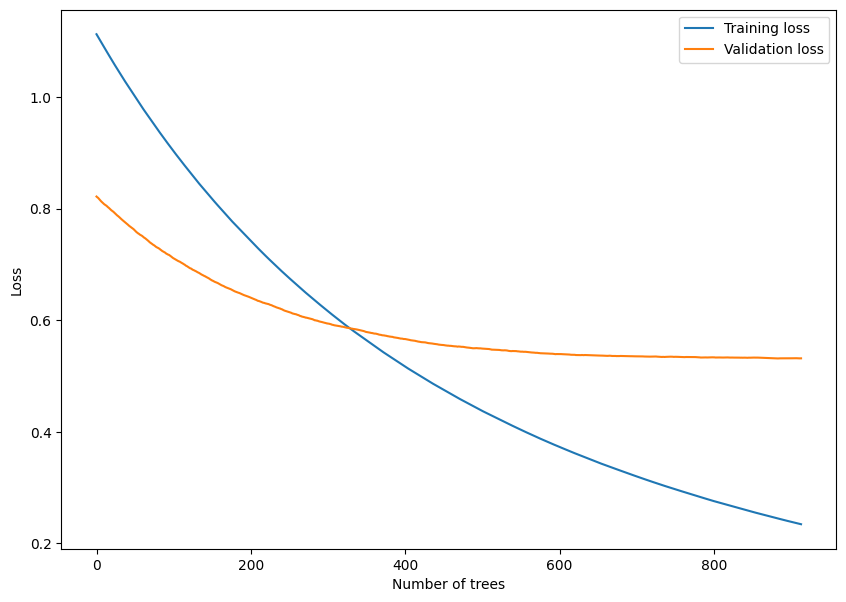

In [76]:
plt.figure(figsize=(10,7))
plt.plot(train_loss, label="Training loss")
plt.plot(test_loss, label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [ ]:
"""# Open the file in append mode
with open('gridsearch_results/xgb_results_7day.txt', 'w') as file:
    # Write the hyperparameters and evaluation metrics to the file
    file.write("Nestimators, Learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, RMSE, MSE, MAE, MAPE, Training Loss, Validation Loss, Train Error, Xtraincols\n")

    
best_rmse = float('inf')
best_options = None

# Create a list of all possible combinations of hyperparameters
hyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))

# Loop over all combinations of hyperparameters
for params in hyperparameters:
    print(f"Trying hyperparameters: {params}")
    
    
    model, evaluation_df, rmse, mse, mae, mape, trainloss, testloss, train_error = gridsearch_timeseriessplit(df_train, df, columns=cols, 
                                                                            test_size=7,n_past=14, n_future=1,
                                                                            n_estimators=params[0], learning_rate=params[1], max_depth=params[2], min_child_weight=params[3], subsample=params[4], colsample_bytree=params[5], gamma=params[6], reg_alpha=params[7], reg_lambda=params[8], early_stopping_rounds=30)
    

    with open('gridsearch_results/xgb_results_7day.txt', 'a') as file:
        file.write(f"{params[0]}, {params[1]}, {params[2]}, {params[3]}, {params[4]}, {params[5]}, {params[6]}, {params[7]}, {params[8]}, {rmse},{mse}, {mae}, {mape}, {trainloss}, {testloss}, {train_error}\n")

    
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = params

print(best_options)
print(best_rmse)
print(mse)
print(best_mae)
print(mape)"""

best
- 50	 0.9	 5	 0.1	 0.9	 1	 15	 0.1	 3
- 25	 0.9	 5	 0.1	 0.9	 1	 5	 0.1	 3


In [ ]:
evaluation_df

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(train_loss, label="Training loss")
plt.plot(test_loss, label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

## 14 DAY

In [77]:
#BEST AND FINAL OPTION
#(150, 0.1, 100, 0.1, 0.9, 0.5, 5, 0.1, 4)

import itertools


# Define hyperparameter grid
n_estimators = [1200] #250
learning_rate = [0.003] #0.0075 ## minél nagyobb, annál jobban tanul ha kisebb akkor kevésbé overfittel

max_depth = [30] #100 feletti
min_child_weight = [0]
subsample = [0.5] #0.5
colsample_bytree = [0.5]
gamma = [0]
reg_alpha = [0]
reg_lambda = [0]
best_rmse = float('inf')
best_options = None

#best : (250, 0.2, 50, 0, 0.5, 0.5, 0, 2, 2)
# Create a list of all possible combinations of hyperparameters
hyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))

print(len(hyperparameters))

1


In [78]:
for params in hyperparameters:
    print(f"Trying hyperparameters: {params}")
    
    
    model, evaluation_df, rmse, mse, mae, mape, train_loss, test_loss, train_error = gridsearch_timeseriessplit(df_train, df, columns=cols,
                                                                            test_size=14, n_past=16, n_future=1,
                                                                            n_estimators=params[0], learning_rate=params[1], max_depth=params[2], min_child_weight=params[3], subsample=params[4], colsample_bytree=params[5], gamma=params[6], reg_alpha=params[7], reg_lambda=params[8], early_stopping_rounds=30)
    

    print(model.best_ntree_limit)
    print(model.best_score)
    print(model.best_iteration)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = params

Trying hyperparameters: (1200, 0.003, 30, 0, 0.5, 0.5, 0, 0, 0)
(14, 160)
(14, 10)
[0]	validation_0-rmse:1.10918	validation_1-rmse:0.78350
[1]	validation_0-rmse:1.10681	validation_1-rmse:0.78260
[2]	validation_0-rmse:1.10443	validation_1-rmse:0.78214
[3]	validation_0-rmse:1.10213	validation_1-rmse:0.78191
[4]	validation_0-rmse:1.09980	validation_1-rmse:0.78132
[5]	validation_0-rmse:1.09748	validation_1-rmse:0.78048
[6]	validation_0-rmse:1.09512	validation_1-rmse:0.77982
[7]	validation_0-rmse:1.09281	validation_1-rmse:0.77929
[8]	validation_0-rmse:1.09045	validation_1-rmse:0.77835
[9]	validation_0-rmse:1.08827	validation_1-rmse:0.77769
[10]	validation_0-rmse:1.08594	validation_1-rmse:0.77713
[11]	validation_0-rmse:1.08357	validation_1-rmse:0.77657
[12]	validation_0-rmse:1.08120	validation_1-rmse:0.77596
[13]	validation_0-rmse:1.07886	validation_1-rmse:0.77522
[14]	validation_0-rmse:1.07650	validation_1-rmse:0.77460
[15]	validation_0-rmse:1.07417	validation_1-rmse:0.77391
[16]	validation

[142]	validation_0-rmse:0.82725	validation_1-rmse:0.71144
[143]	validation_0-rmse:0.82567	validation_1-rmse:0.71111
[144]	validation_0-rmse:0.82402	validation_1-rmse:0.71066
[145]	validation_0-rmse:0.82237	validation_1-rmse:0.71030
[146]	validation_0-rmse:0.82077	validation_1-rmse:0.70987
[147]	validation_0-rmse:0.81917	validation_1-rmse:0.70977
[148]	validation_0-rmse:0.81753	validation_1-rmse:0.70961
[149]	validation_0-rmse:0.81590	validation_1-rmse:0.70915
[150]	validation_0-rmse:0.81429	validation_1-rmse:0.70881
[151]	validation_0-rmse:0.81269	validation_1-rmse:0.70849
[152]	validation_0-rmse:0.81110	validation_1-rmse:0.70804
[153]	validation_0-rmse:0.80947	validation_1-rmse:0.70757
[154]	validation_0-rmse:0.80782	validation_1-rmse:0.70699
[155]	validation_0-rmse:0.80618	validation_1-rmse:0.70703
[156]	validation_0-rmse:0.80458	validation_1-rmse:0.70664
[157]	validation_0-rmse:0.80300	validation_1-rmse:0.70635
[158]	validation_0-rmse:0.80146	validation_1-rmse:0.70572
[159]	validati

[284]	validation_0-rmse:0.63041	validation_1-rmse:0.67981
[285]	validation_0-rmse:0.62928	validation_1-rmse:0.67952
[286]	validation_0-rmse:0.62816	validation_1-rmse:0.67938
[287]	validation_0-rmse:0.62701	validation_1-rmse:0.67925
[288]	validation_0-rmse:0.62584	validation_1-rmse:0.67931
[289]	validation_0-rmse:0.62472	validation_1-rmse:0.67957
[290]	validation_0-rmse:0.62356	validation_1-rmse:0.67946
[291]	validation_0-rmse:0.62241	validation_1-rmse:0.67939
[292]	validation_0-rmse:0.62126	validation_1-rmse:0.67908
[293]	validation_0-rmse:0.62015	validation_1-rmse:0.67902
[294]	validation_0-rmse:0.61904	validation_1-rmse:0.67918
[295]	validation_0-rmse:0.61792	validation_1-rmse:0.67891
[296]	validation_0-rmse:0.61681	validation_1-rmse:0.67907
[297]	validation_0-rmse:0.61571	validation_1-rmse:0.67908
[298]	validation_0-rmse:0.61459	validation_1-rmse:0.67887
[299]	validation_0-rmse:0.61348	validation_1-rmse:0.67881
[300]	validation_0-rmse:0.61236	validation_1-rmse:0.67860
[301]	validati

[426]	validation_0-rmse:0.49098	validation_1-rmse:0.67183
[427]	validation_0-rmse:0.49012	validation_1-rmse:0.67179
[428]	validation_0-rmse:0.48927	validation_1-rmse:0.67168
[429]	validation_0-rmse:0.48845	validation_1-rmse:0.67160
[430]	validation_0-rmse:0.48763	validation_1-rmse:0.67147
[431]	validation_0-rmse:0.48676	validation_1-rmse:0.67131
[432]	validation_0-rmse:0.48593	validation_1-rmse:0.67137
[433]	validation_0-rmse:0.48513	validation_1-rmse:0.67122
[434]	validation_0-rmse:0.48431	validation_1-rmse:0.67088
[435]	validation_0-rmse:0.48352	validation_1-rmse:0.67098
[436]	validation_0-rmse:0.48268	validation_1-rmse:0.67103
[437]	validation_0-rmse:0.48187	validation_1-rmse:0.67100
[438]	validation_0-rmse:0.48108	validation_1-rmse:0.67099
[439]	validation_0-rmse:0.48030	validation_1-rmse:0.67090
[440]	validation_0-rmse:0.47946	validation_1-rmse:0.67100
[441]	validation_0-rmse:0.47867	validation_1-rmse:0.67102
[442]	validation_0-rmse:0.47786	validation_1-rmse:0.67120
[443]	validati

[75]	validation_0-rmse:0.94660	validation_1-rmse:1.48857
[76]	validation_0-rmse:0.94467	validation_1-rmse:1.48760
[77]	validation_0-rmse:0.94271	validation_1-rmse:1.48637
[78]	validation_0-rmse:0.94088	validation_1-rmse:1.48519
[79]	validation_0-rmse:0.93904	validation_1-rmse:1.48441
[80]	validation_0-rmse:0.93711	validation_1-rmse:1.48355
[81]	validation_0-rmse:0.93520	validation_1-rmse:1.48192
[82]	validation_0-rmse:0.93322	validation_1-rmse:1.48101
[83]	validation_0-rmse:0.93136	validation_1-rmse:1.48033
[84]	validation_0-rmse:0.92942	validation_1-rmse:1.47942
[85]	validation_0-rmse:0.92750	validation_1-rmse:1.47842
[86]	validation_0-rmse:0.92555	validation_1-rmse:1.47688
[87]	validation_0-rmse:0.92362	validation_1-rmse:1.47570
[88]	validation_0-rmse:0.92176	validation_1-rmse:1.47448
[89]	validation_0-rmse:0.91987	validation_1-rmse:1.47320
[90]	validation_0-rmse:0.91798	validation_1-rmse:1.47201
[91]	validation_0-rmse:0.91609	validation_1-rmse:1.47095
[92]	validation_0-rmse:0.91425	

[217]	validation_0-rmse:0.71337	validation_1-rmse:1.38191
[218]	validation_0-rmse:0.71201	validation_1-rmse:1.38125
[219]	validation_0-rmse:0.71064	validation_1-rmse:1.38084
[220]	validation_0-rmse:0.70929	validation_1-rmse:1.38002
[221]	validation_0-rmse:0.70794	validation_1-rmse:1.37935
[222]	validation_0-rmse:0.70657	validation_1-rmse:1.37883
[223]	validation_0-rmse:0.70526	validation_1-rmse:1.37850
[224]	validation_0-rmse:0.70393	validation_1-rmse:1.37799
[225]	validation_0-rmse:0.70261	validation_1-rmse:1.37749
[226]	validation_0-rmse:0.70130	validation_1-rmse:1.37746
[227]	validation_0-rmse:0.69992	validation_1-rmse:1.37679
[228]	validation_0-rmse:0.69862	validation_1-rmse:1.37632
[229]	validation_0-rmse:0.69726	validation_1-rmse:1.37618
[230]	validation_0-rmse:0.69594	validation_1-rmse:1.37577
[231]	validation_0-rmse:0.69459	validation_1-rmse:1.37527
[232]	validation_0-rmse:0.69330	validation_1-rmse:1.37500
[233]	validation_0-rmse:0.69203	validation_1-rmse:1.37430
[234]	validati

[359]	validation_0-rmse:0.54977	validation_1-rmse:1.33629
[360]	validation_0-rmse:0.54876	validation_1-rmse:1.33640
[361]	validation_0-rmse:0.54781	validation_1-rmse:1.33649
[362]	validation_0-rmse:0.54686	validation_1-rmse:1.33626
[363]	validation_0-rmse:0.54587	validation_1-rmse:1.33627
[364]	validation_0-rmse:0.54491	validation_1-rmse:1.33588
[365]	validation_0-rmse:0.54396	validation_1-rmse:1.33564
[366]	validation_0-rmse:0.54297	validation_1-rmse:1.33522
[367]	validation_0-rmse:0.54204	validation_1-rmse:1.33549
[368]	validation_0-rmse:0.54110	validation_1-rmse:1.33514
[369]	validation_0-rmse:0.54014	validation_1-rmse:1.33490
[370]	validation_0-rmse:0.53916	validation_1-rmse:1.33484
[371]	validation_0-rmse:0.53822	validation_1-rmse:1.33473
[372]	validation_0-rmse:0.53726	validation_1-rmse:1.33452
[373]	validation_0-rmse:0.53635	validation_1-rmse:1.33392
[374]	validation_0-rmse:0.53539	validation_1-rmse:1.33350
[375]	validation_0-rmse:0.53446	validation_1-rmse:1.33334
[376]	validati

[501]	validation_0-rmse:0.43178	validation_1-rmse:1.31859
[502]	validation_0-rmse:0.43108	validation_1-rmse:1.31859
[503]	validation_0-rmse:0.43036	validation_1-rmse:1.31823
[504]	validation_0-rmse:0.42965	validation_1-rmse:1.31805
[505]	validation_0-rmse:0.42894	validation_1-rmse:1.31817
[506]	validation_0-rmse:0.42823	validation_1-rmse:1.31806
[507]	validation_0-rmse:0.42755	validation_1-rmse:1.31816
[508]	validation_0-rmse:0.42683	validation_1-rmse:1.31804
[509]	validation_0-rmse:0.42609	validation_1-rmse:1.31795
[510]	validation_0-rmse:0.42541	validation_1-rmse:1.31772
[511]	validation_0-rmse:0.42472	validation_1-rmse:1.31743
[512]	validation_0-rmse:0.42403	validation_1-rmse:1.31717
[513]	validation_0-rmse:0.42333	validation_1-rmse:1.31694
[514]	validation_0-rmse:0.42265	validation_1-rmse:1.31694
[515]	validation_0-rmse:0.42196	validation_1-rmse:1.31689
[516]	validation_0-rmse:0.42126	validation_1-rmse:1.31687
[517]	validation_0-rmse:0.42055	validation_1-rmse:1.31692
[518]	validati

[643]	validation_0-rmse:0.34442	validation_1-rmse:1.31248
[644]	validation_0-rmse:0.34387	validation_1-rmse:1.31239
[645]	validation_0-rmse:0.34335	validation_1-rmse:1.31247
[646]	validation_0-rmse:0.34281	validation_1-rmse:1.31238
[647]	validation_0-rmse:0.34228	validation_1-rmse:1.31236
[648]	validation_0-rmse:0.34176	validation_1-rmse:1.31247
[649]	validation_0-rmse:0.34122	validation_1-rmse:1.31259
[650]	validation_0-rmse:0.34071	validation_1-rmse:1.31266
[651]	validation_0-rmse:0.34020	validation_1-rmse:1.31266
[652]	validation_0-rmse:0.33967	validation_1-rmse:1.31237
[653]	validation_0-rmse:0.33911	validation_1-rmse:1.31240
[654]	validation_0-rmse:0.33857	validation_1-rmse:1.31252
[655]	validation_0-rmse:0.33807	validation_1-rmse:1.31264
[656]	validation_0-rmse:0.33753	validation_1-rmse:1.31259
[657]	validation_0-rmse:0.33699	validation_1-rmse:1.31253
Model Fitted
(1, 160)
            eth_close  unscaled_predictions  log_prediction  true_values  \
date                            

[98]	validation_0-rmse:0.90364	validation_1-rmse:0.77160
[99]	validation_0-rmse:0.90185	validation_1-rmse:0.77054
[100]	validation_0-rmse:0.89997	validation_1-rmse:0.76934
[101]	validation_0-rmse:0.89811	validation_1-rmse:0.76827
[102]	validation_0-rmse:0.89624	validation_1-rmse:0.76700
[103]	validation_0-rmse:0.89442	validation_1-rmse:0.76582
[104]	validation_0-rmse:0.89253	validation_1-rmse:0.76487
[105]	validation_0-rmse:0.89079	validation_1-rmse:0.76381
[106]	validation_0-rmse:0.88897	validation_1-rmse:0.76233
[107]	validation_0-rmse:0.88715	validation_1-rmse:0.76118
[108]	validation_0-rmse:0.88543	validation_1-rmse:0.75970
[109]	validation_0-rmse:0.88370	validation_1-rmse:0.75880
[110]	validation_0-rmse:0.88185	validation_1-rmse:0.75761
[111]	validation_0-rmse:0.88007	validation_1-rmse:0.75602
[112]	validation_0-rmse:0.87833	validation_1-rmse:0.75517
[113]	validation_0-rmse:0.87653	validation_1-rmse:0.75375
[114]	validation_0-rmse:0.87482	validation_1-rmse:0.75267
[115]	validation

[240]	validation_0-rmse:0.68392	validation_1-rmse:0.63423
[241]	validation_0-rmse:0.68263	validation_1-rmse:0.63326
[242]	validation_0-rmse:0.68132	validation_1-rmse:0.63266
[243]	validation_0-rmse:0.68003	validation_1-rmse:0.63221
[244]	validation_0-rmse:0.67874	validation_1-rmse:0.63170
[245]	validation_0-rmse:0.67745	validation_1-rmse:0.63084
[246]	validation_0-rmse:0.67614	validation_1-rmse:0.62992
[247]	validation_0-rmse:0.67489	validation_1-rmse:0.62900
[248]	validation_0-rmse:0.67361	validation_1-rmse:0.62857
[249]	validation_0-rmse:0.67228	validation_1-rmse:0.62792
[250]	validation_0-rmse:0.67104	validation_1-rmse:0.62764
[251]	validation_0-rmse:0.66982	validation_1-rmse:0.62701
[252]	validation_0-rmse:0.66856	validation_1-rmse:0.62634
[253]	validation_0-rmse:0.66728	validation_1-rmse:0.62573
[254]	validation_0-rmse:0.66602	validation_1-rmse:0.62527
[255]	validation_0-rmse:0.66476	validation_1-rmse:0.62425
[256]	validation_0-rmse:0.66356	validation_1-rmse:0.62454
[257]	validati

[382]	validation_0-rmse:0.52875	validation_1-rmse:0.56905
[383]	validation_0-rmse:0.52786	validation_1-rmse:0.56911
[384]	validation_0-rmse:0.52693	validation_1-rmse:0.56885
[385]	validation_0-rmse:0.52601	validation_1-rmse:0.56868
[386]	validation_0-rmse:0.52505	validation_1-rmse:0.56854
[387]	validation_0-rmse:0.52408	validation_1-rmse:0.56840
[388]	validation_0-rmse:0.52321	validation_1-rmse:0.56819
[389]	validation_0-rmse:0.52228	validation_1-rmse:0.56796
[390]	validation_0-rmse:0.52137	validation_1-rmse:0.56769
[391]	validation_0-rmse:0.52049	validation_1-rmse:0.56735
[392]	validation_0-rmse:0.51957	validation_1-rmse:0.56730
[393]	validation_0-rmse:0.51867	validation_1-rmse:0.56700
[394]	validation_0-rmse:0.51776	validation_1-rmse:0.56697
[395]	validation_0-rmse:0.51688	validation_1-rmse:0.56680
[396]	validation_0-rmse:0.51601	validation_1-rmse:0.56661
[397]	validation_0-rmse:0.51511	validation_1-rmse:0.56623
[398]	validation_0-rmse:0.51424	validation_1-rmse:0.56594
[399]	validati

[524]	validation_0-rmse:0.41636	validation_1-rmse:0.55040
[525]	validation_0-rmse:0.41568	validation_1-rmse:0.55023
[526]	validation_0-rmse:0.41505	validation_1-rmse:0.55017
[527]	validation_0-rmse:0.41437	validation_1-rmse:0.55011
[528]	validation_0-rmse:0.41370	validation_1-rmse:0.55000
[529]	validation_0-rmse:0.41303	validation_1-rmse:0.54998
[530]	validation_0-rmse:0.41237	validation_1-rmse:0.54986
[531]	validation_0-rmse:0.41173	validation_1-rmse:0.54949
[532]	validation_0-rmse:0.41106	validation_1-rmse:0.54946
[533]	validation_0-rmse:0.41038	validation_1-rmse:0.54943
[534]	validation_0-rmse:0.40974	validation_1-rmse:0.54938
[535]	validation_0-rmse:0.40905	validation_1-rmse:0.54922
[536]	validation_0-rmse:0.40839	validation_1-rmse:0.54906
[537]	validation_0-rmse:0.40773	validation_1-rmse:0.54894
[538]	validation_0-rmse:0.40710	validation_1-rmse:0.54876
[539]	validation_0-rmse:0.40642	validation_1-rmse:0.54865
[540]	validation_0-rmse:0.40574	validation_1-rmse:0.54876
[541]	validati

[54]	validation_0-rmse:0.99000	validation_1-rmse:0.72429
[55]	validation_0-rmse:0.98792	validation_1-rmse:0.72322
[56]	validation_0-rmse:0.98585	validation_1-rmse:0.72233
[57]	validation_0-rmse:0.98377	validation_1-rmse:0.72140
[58]	validation_0-rmse:0.98169	validation_1-rmse:0.72041
[59]	validation_0-rmse:0.97964	validation_1-rmse:0.71946
[60]	validation_0-rmse:0.97756	validation_1-rmse:0.71877
[61]	validation_0-rmse:0.97546	validation_1-rmse:0.71795
[62]	validation_0-rmse:0.97340	validation_1-rmse:0.71670
[63]	validation_0-rmse:0.97141	validation_1-rmse:0.71597
[64]	validation_0-rmse:0.96942	validation_1-rmse:0.71499
[65]	validation_0-rmse:0.96741	validation_1-rmse:0.71418
[66]	validation_0-rmse:0.96541	validation_1-rmse:0.71373
[67]	validation_0-rmse:0.96338	validation_1-rmse:0.71304
[68]	validation_0-rmse:0.96136	validation_1-rmse:0.71243
[69]	validation_0-rmse:0.95945	validation_1-rmse:0.71138
[70]	validation_0-rmse:0.95747	validation_1-rmse:0.71050
[71]	validation_0-rmse:0.95549	

[197]	validation_0-rmse:0.74384	validation_1-rmse:0.64062
[198]	validation_0-rmse:0.74243	validation_1-rmse:0.64039
[199]	validation_0-rmse:0.74101	validation_1-rmse:0.64027
[200]	validation_0-rmse:0.73961	validation_1-rmse:0.63974
[201]	validation_0-rmse:0.73823	validation_1-rmse:0.63959
[202]	validation_0-rmse:0.73681	validation_1-rmse:0.63903
[203]	validation_0-rmse:0.73539	validation_1-rmse:0.63864
[204]	validation_0-rmse:0.73399	validation_1-rmse:0.63843
[205]	validation_0-rmse:0.73260	validation_1-rmse:0.63811
[206]	validation_0-rmse:0.73125	validation_1-rmse:0.63771
[207]	validation_0-rmse:0.72987	validation_1-rmse:0.63757
[208]	validation_0-rmse:0.72852	validation_1-rmse:0.63734
[209]	validation_0-rmse:0.72713	validation_1-rmse:0.63712
[210]	validation_0-rmse:0.72578	validation_1-rmse:0.63665
[211]	validation_0-rmse:0.72438	validation_1-rmse:0.63641
[212]	validation_0-rmse:0.72297	validation_1-rmse:0.63611
[213]	validation_0-rmse:0.72159	validation_1-rmse:0.63588
[214]	validati

[339]	validation_0-rmse:0.57238	validation_1-rmse:0.60912
[340]	validation_0-rmse:0.57137	validation_1-rmse:0.60903
[341]	validation_0-rmse:0.57031	validation_1-rmse:0.60890
[342]	validation_0-rmse:0.56932	validation_1-rmse:0.60886
[343]	validation_0-rmse:0.56832	validation_1-rmse:0.60871
[344]	validation_0-rmse:0.56734	validation_1-rmse:0.60862
[345]	validation_0-rmse:0.56633	validation_1-rmse:0.60863
[346]	validation_0-rmse:0.56532	validation_1-rmse:0.60862
[347]	validation_0-rmse:0.56430	validation_1-rmse:0.60857
[348]	validation_0-rmse:0.56323	validation_1-rmse:0.60853
[349]	validation_0-rmse:0.56223	validation_1-rmse:0.60836
[350]	validation_0-rmse:0.56125	validation_1-rmse:0.60791
[351]	validation_0-rmse:0.56025	validation_1-rmse:0.60769
[352]	validation_0-rmse:0.55924	validation_1-rmse:0.60743
[353]	validation_0-rmse:0.55828	validation_1-rmse:0.60762
[354]	validation_0-rmse:0.55729	validation_1-rmse:0.60756
[355]	validation_0-rmse:0.55633	validation_1-rmse:0.60756
[356]	validati

[481]	validation_0-rmse:0.44855	validation_1-rmse:0.59954
[482]	validation_0-rmse:0.44777	validation_1-rmse:0.59938
[483]	validation_0-rmse:0.44702	validation_1-rmse:0.59946
[484]	validation_0-rmse:0.44629	validation_1-rmse:0.59938
[485]	validation_0-rmse:0.44554	validation_1-rmse:0.59950
[486]	validation_0-rmse:0.44483	validation_1-rmse:0.59950
[487]	validation_0-rmse:0.44408	validation_1-rmse:0.59946
[488]	validation_0-rmse:0.44333	validation_1-rmse:0.59938
[489]	validation_0-rmse:0.44262	validation_1-rmse:0.59929
[490]	validation_0-rmse:0.44193	validation_1-rmse:0.59938
[491]	validation_0-rmse:0.44123	validation_1-rmse:0.59930
[492]	validation_0-rmse:0.44049	validation_1-rmse:0.59928
[493]	validation_0-rmse:0.43976	validation_1-rmse:0.59920
[494]	validation_0-rmse:0.43904	validation_1-rmse:0.59942
[495]	validation_0-rmse:0.43833	validation_1-rmse:0.59934
[496]	validation_0-rmse:0.43759	validation_1-rmse:0.59946
[497]	validation_0-rmse:0.43688	validation_1-rmse:0.59949
[498]	validati

[623]	validation_0-rmse:0.35683	validation_1-rmse:0.59643
[624]	validation_0-rmse:0.35629	validation_1-rmse:0.59651
Model Fitted
(1, 160)
            eth_close  unscaled_predictions  log_prediction  true_values  \
date                                                                       
2022-11-30   7.165849              0.003208        7.106933      1294.46   
2022-12-01   7.151807              0.004529        7.111463      1276.41   
2022-12-02   7.166721              0.004466        7.115929      1295.59   
2022-12-03   7.123278             -0.000815        7.115113      1240.51   
2022-12-04   7.154154              0.004882        7.119996      1279.41   
2022-12-05   7.138399              0.001820        7.121815      1259.41   
2022-12-06   7.147811             -0.000593        7.121222      1271.32   
2022-12-07   7.115728              0.008241        7.129464      1231.18   
2022-12-08   7.154756              0.005946        7.135410      1280.18   
2022-12-09   7.141324     

[111]	validation_0-rmse:0.87955	validation_1-rmse:0.78868
[112]	validation_0-rmse:0.87773	validation_1-rmse:0.78761
[113]	validation_0-rmse:0.87599	validation_1-rmse:0.78701
[114]	validation_0-rmse:0.87416	validation_1-rmse:0.78596
[115]	validation_0-rmse:0.87240	validation_1-rmse:0.78520
[116]	validation_0-rmse:0.87065	validation_1-rmse:0.78413
[117]	validation_0-rmse:0.86890	validation_1-rmse:0.78303
[118]	validation_0-rmse:0.86719	validation_1-rmse:0.78224
[119]	validation_0-rmse:0.86545	validation_1-rmse:0.78136
[120]	validation_0-rmse:0.86375	validation_1-rmse:0.78043
[121]	validation_0-rmse:0.86201	validation_1-rmse:0.77962
[122]	validation_0-rmse:0.86025	validation_1-rmse:0.77897
[123]	validation_0-rmse:0.85845	validation_1-rmse:0.77790
[124]	validation_0-rmse:0.85678	validation_1-rmse:0.77731
[125]	validation_0-rmse:0.85505	validation_1-rmse:0.77645
[126]	validation_0-rmse:0.85332	validation_1-rmse:0.77554
[127]	validation_0-rmse:0.85160	validation_1-rmse:0.77468
[128]	validati

[253]	validation_0-rmse:0.66792	validation_1-rmse:0.69743
[254]	validation_0-rmse:0.66679	validation_1-rmse:0.69714
[255]	validation_0-rmse:0.66551	validation_1-rmse:0.69667
[256]	validation_0-rmse:0.66428	validation_1-rmse:0.69642
[257]	validation_0-rmse:0.66305	validation_1-rmse:0.69615
[258]	validation_0-rmse:0.66181	validation_1-rmse:0.69564
[259]	validation_0-rmse:0.66059	validation_1-rmse:0.69544
[260]	validation_0-rmse:0.65934	validation_1-rmse:0.69509
[261]	validation_0-rmse:0.65813	validation_1-rmse:0.69466
[262]	validation_0-rmse:0.65688	validation_1-rmse:0.69417
[263]	validation_0-rmse:0.65570	validation_1-rmse:0.69376
[264]	validation_0-rmse:0.65446	validation_1-rmse:0.69319
[265]	validation_0-rmse:0.65330	validation_1-rmse:0.69268
[266]	validation_0-rmse:0.65207	validation_1-rmse:0.69220
[267]	validation_0-rmse:0.65086	validation_1-rmse:0.69174
[268]	validation_0-rmse:0.64968	validation_1-rmse:0.69143
[269]	validation_0-rmse:0.64845	validation_1-rmse:0.69112
[270]	validati

[395]	validation_0-rmse:0.51769	validation_1-rmse:0.64964
[396]	validation_0-rmse:0.51678	validation_1-rmse:0.64944
[397]	validation_0-rmse:0.51589	validation_1-rmse:0.64938
[398]	validation_0-rmse:0.51501	validation_1-rmse:0.64916
[399]	validation_0-rmse:0.51411	validation_1-rmse:0.64875
[400]	validation_0-rmse:0.51321	validation_1-rmse:0.64848
[401]	validation_0-rmse:0.51231	validation_1-rmse:0.64801
[402]	validation_0-rmse:0.51143	validation_1-rmse:0.64765
[403]	validation_0-rmse:0.51055	validation_1-rmse:0.64738
[404]	validation_0-rmse:0.50968	validation_1-rmse:0.64714
[405]	validation_0-rmse:0.50881	validation_1-rmse:0.64704
[406]	validation_0-rmse:0.50791	validation_1-rmse:0.64657
[407]	validation_0-rmse:0.50704	validation_1-rmse:0.64646
[408]	validation_0-rmse:0.50619	validation_1-rmse:0.64630
[409]	validation_0-rmse:0.50528	validation_1-rmse:0.64607
[410]	validation_0-rmse:0.50441	validation_1-rmse:0.64577
[411]	validation_0-rmse:0.50352	validation_1-rmse:0.64565
[412]	validati

[537]	validation_0-rmse:0.40850	validation_1-rmse:0.62280
[538]	validation_0-rmse:0.40779	validation_1-rmse:0.62269
[539]	validation_0-rmse:0.40713	validation_1-rmse:0.62268
[540]	validation_0-rmse:0.40650	validation_1-rmse:0.62270
[541]	validation_0-rmse:0.40582	validation_1-rmse:0.62254
[542]	validation_0-rmse:0.40518	validation_1-rmse:0.62256
[543]	validation_0-rmse:0.40450	validation_1-rmse:0.62240
[544]	validation_0-rmse:0.40390	validation_1-rmse:0.62208
[545]	validation_0-rmse:0.40328	validation_1-rmse:0.62200
[546]	validation_0-rmse:0.40264	validation_1-rmse:0.62182
[547]	validation_0-rmse:0.40199	validation_1-rmse:0.62177
[548]	validation_0-rmse:0.40133	validation_1-rmse:0.62161
[549]	validation_0-rmse:0.40073	validation_1-rmse:0.62157
[550]	validation_0-rmse:0.40011	validation_1-rmse:0.62134
[551]	validation_0-rmse:0.39948	validation_1-rmse:0.62116
[552]	validation_0-rmse:0.39884	validation_1-rmse:0.62111
[553]	validation_0-rmse:0.39819	validation_1-rmse:0.62083
[554]	validati

[679]	validation_0-rmse:0.32688	validation_1-rmse:0.60968
[680]	validation_0-rmse:0.32638	validation_1-rmse:0.60971
[681]	validation_0-rmse:0.32588	validation_1-rmse:0.60958
[682]	validation_0-rmse:0.32535	validation_1-rmse:0.60962
[683]	validation_0-rmse:0.32487	validation_1-rmse:0.60941
[684]	validation_0-rmse:0.32438	validation_1-rmse:0.60913
[685]	validation_0-rmse:0.32389	validation_1-rmse:0.60912
[686]	validation_0-rmse:0.32338	validation_1-rmse:0.60901
[687]	validation_0-rmse:0.32291	validation_1-rmse:0.60885
[688]	validation_0-rmse:0.32243	validation_1-rmse:0.60896
[689]	validation_0-rmse:0.32194	validation_1-rmse:0.60876
[690]	validation_0-rmse:0.32145	validation_1-rmse:0.60876
[691]	validation_0-rmse:0.32094	validation_1-rmse:0.60870
[692]	validation_0-rmse:0.32046	validation_1-rmse:0.60859
[693]	validation_0-rmse:0.31997	validation_1-rmse:0.60853
[694]	validation_0-rmse:0.31951	validation_1-rmse:0.60853
[695]	validation_0-rmse:0.31903	validation_1-rmse:0.60849
[696]	validati

[821]	validation_0-rmse:0.26470	validation_1-rmse:0.60092
[822]	validation_0-rmse:0.26430	validation_1-rmse:0.60089
[823]	validation_0-rmse:0.26393	validation_1-rmse:0.60079
[824]	validation_0-rmse:0.26353	validation_1-rmse:0.60070
[825]	validation_0-rmse:0.26318	validation_1-rmse:0.60063
[826]	validation_0-rmse:0.26281	validation_1-rmse:0.60061
[827]	validation_0-rmse:0.26241	validation_1-rmse:0.60063
[828]	validation_0-rmse:0.26203	validation_1-rmse:0.60056
[829]	validation_0-rmse:0.26165	validation_1-rmse:0.60051
[830]	validation_0-rmse:0.26127	validation_1-rmse:0.60044
[831]	validation_0-rmse:0.26090	validation_1-rmse:0.60044
[832]	validation_0-rmse:0.26052	validation_1-rmse:0.60031
[833]	validation_0-rmse:0.26014	validation_1-rmse:0.60024
[834]	validation_0-rmse:0.25975	validation_1-rmse:0.60023
[835]	validation_0-rmse:0.25936	validation_1-rmse:0.60021
[836]	validation_0-rmse:0.25898	validation_1-rmse:0.60023
[837]	validation_0-rmse:0.25857	validation_1-rmse:0.60009
[838]	validati

[963]	validation_0-rmse:0.21599	validation_1-rmse:0.59718
[964]	validation_0-rmse:0.21569	validation_1-rmse:0.59716
[965]	validation_0-rmse:0.21539	validation_1-rmse:0.59712
[966]	validation_0-rmse:0.21510	validation_1-rmse:0.59711
[967]	validation_0-rmse:0.21480	validation_1-rmse:0.59715
[968]	validation_0-rmse:0.21450	validation_1-rmse:0.59716
[969]	validation_0-rmse:0.21421	validation_1-rmse:0.59717
[970]	validation_0-rmse:0.21390	validation_1-rmse:0.59717
[971]	validation_0-rmse:0.21357	validation_1-rmse:0.59711
[972]	validation_0-rmse:0.21325	validation_1-rmse:0.59707
[973]	validation_0-rmse:0.21293	validation_1-rmse:0.59708
[974]	validation_0-rmse:0.21261	validation_1-rmse:0.59709
[975]	validation_0-rmse:0.21232	validation_1-rmse:0.59706
[976]	validation_0-rmse:0.21202	validation_1-rmse:0.59706
[977]	validation_0-rmse:0.21171	validation_1-rmse:0.59702
[978]	validation_0-rmse:0.21142	validation_1-rmse:0.59708
[979]	validation_0-rmse:0.21112	validation_1-rmse:0.59712
[980]	validati

[69]	validation_0-rmse:0.95886	validation_1-rmse:0.55776
[70]	validation_0-rmse:0.95689	validation_1-rmse:0.55708
[71]	validation_0-rmse:0.95491	validation_1-rmse:0.55648
[72]	validation_0-rmse:0.95295	validation_1-rmse:0.55561
[73]	validation_0-rmse:0.95113	validation_1-rmse:0.55501
[74]	validation_0-rmse:0.94919	validation_1-rmse:0.55431
[75]	validation_0-rmse:0.94719	validation_1-rmse:0.55385
[76]	validation_0-rmse:0.94521	validation_1-rmse:0.55323
[77]	validation_0-rmse:0.94324	validation_1-rmse:0.55245
[78]	validation_0-rmse:0.94131	validation_1-rmse:0.55173
[79]	validation_0-rmse:0.93930	validation_1-rmse:0.55111
[80]	validation_0-rmse:0.93731	validation_1-rmse:0.55047
[81]	validation_0-rmse:0.93536	validation_1-rmse:0.54976
[82]	validation_0-rmse:0.93340	validation_1-rmse:0.54869
[83]	validation_0-rmse:0.93145	validation_1-rmse:0.54786
[84]	validation_0-rmse:0.92952	validation_1-rmse:0.54736
[85]	validation_0-rmse:0.92760	validation_1-rmse:0.54657
[86]	validation_0-rmse:0.92574	

[211]	validation_0-rmse:0.72222	validation_1-rmse:0.48952
[212]	validation_0-rmse:0.72080	validation_1-rmse:0.48904
[213]	validation_0-rmse:0.71947	validation_1-rmse:0.48862
[214]	validation_0-rmse:0.71810	validation_1-rmse:0.48834
[215]	validation_0-rmse:0.71676	validation_1-rmse:0.48819
[216]	validation_0-rmse:0.71538	validation_1-rmse:0.48793
[217]	validation_0-rmse:0.71402	validation_1-rmse:0.48769
[218]	validation_0-rmse:0.71267	validation_1-rmse:0.48744
[219]	validation_0-rmse:0.71134	validation_1-rmse:0.48735
[220]	validation_0-rmse:0.70998	validation_1-rmse:0.48692
[221]	validation_0-rmse:0.70859	validation_1-rmse:0.48637
[222]	validation_0-rmse:0.70721	validation_1-rmse:0.48606
[223]	validation_0-rmse:0.70581	validation_1-rmse:0.48583
[224]	validation_0-rmse:0.70445	validation_1-rmse:0.48577
[225]	validation_0-rmse:0.70314	validation_1-rmse:0.48554
[226]	validation_0-rmse:0.70179	validation_1-rmse:0.48522
[227]	validation_0-rmse:0.70047	validation_1-rmse:0.48515
[228]	validati

[353]	validation_0-rmse:0.55628	validation_1-rmse:0.46068
[354]	validation_0-rmse:0.55532	validation_1-rmse:0.46052
[355]	validation_0-rmse:0.55434	validation_1-rmse:0.46046
[356]	validation_0-rmse:0.55333	validation_1-rmse:0.46034
[357]	validation_0-rmse:0.55232	validation_1-rmse:0.45998
[358]	validation_0-rmse:0.55136	validation_1-rmse:0.45975
[359]	validation_0-rmse:0.55037	validation_1-rmse:0.45979
[360]	validation_0-rmse:0.54943	validation_1-rmse:0.45965
[361]	validation_0-rmse:0.54844	validation_1-rmse:0.45950
[362]	validation_0-rmse:0.54747	validation_1-rmse:0.45940
[363]	validation_0-rmse:0.54652	validation_1-rmse:0.45921
[364]	validation_0-rmse:0.54555	validation_1-rmse:0.45911
[365]	validation_0-rmse:0.54462	validation_1-rmse:0.45868
[366]	validation_0-rmse:0.54363	validation_1-rmse:0.45851
[367]	validation_0-rmse:0.54269	validation_1-rmse:0.45850
[368]	validation_0-rmse:0.54179	validation_1-rmse:0.45844
[369]	validation_0-rmse:0.54086	validation_1-rmse:0.45840
[370]	validati

[495]	validation_0-rmse:0.43667	validation_1-rmse:0.45200
[496]	validation_0-rmse:0.43599	validation_1-rmse:0.45191
[497]	validation_0-rmse:0.43525	validation_1-rmse:0.45217
[498]	validation_0-rmse:0.43449	validation_1-rmse:0.45233
[499]	validation_0-rmse:0.43379	validation_1-rmse:0.45227
[500]	validation_0-rmse:0.43312	validation_1-rmse:0.45230
[501]	validation_0-rmse:0.43242	validation_1-rmse:0.45238
[502]	validation_0-rmse:0.43174	validation_1-rmse:0.45236
[503]	validation_0-rmse:0.43101	validation_1-rmse:0.45234
[504]	validation_0-rmse:0.43031	validation_1-rmse:0.45227
[505]	validation_0-rmse:0.42959	validation_1-rmse:0.45227
[506]	validation_0-rmse:0.42885	validation_1-rmse:0.45202
[507]	validation_0-rmse:0.42813	validation_1-rmse:0.45195
[508]	validation_0-rmse:0.42742	validation_1-rmse:0.45198
[509]	validation_0-rmse:0.42673	validation_1-rmse:0.45179
[510]	validation_0-rmse:0.42603	validation_1-rmse:0.45160
[511]	validation_0-rmse:0.42533	validation_1-rmse:0.45148
[512]	validati

[62]	validation_0-rmse:0.97250	validation_1-rmse:0.65115
[63]	validation_0-rmse:0.97048	validation_1-rmse:0.65048
[64]	validation_0-rmse:0.96848	validation_1-rmse:0.64972
[65]	validation_0-rmse:0.96646	validation_1-rmse:0.64892
[66]	validation_0-rmse:0.96436	validation_1-rmse:0.64827
[67]	validation_0-rmse:0.96236	validation_1-rmse:0.64777
[68]	validation_0-rmse:0.96041	validation_1-rmse:0.64727
[69]	validation_0-rmse:0.95830	validation_1-rmse:0.64692
[70]	validation_0-rmse:0.95632	validation_1-rmse:0.64646
[71]	validation_0-rmse:0.95442	validation_1-rmse:0.64601
[72]	validation_0-rmse:0.95244	validation_1-rmse:0.64545
[73]	validation_0-rmse:0.95047	validation_1-rmse:0.64480
[74]	validation_0-rmse:0.94843	validation_1-rmse:0.64418
[75]	validation_0-rmse:0.94652	validation_1-rmse:0.64349
[76]	validation_0-rmse:0.94463	validation_1-rmse:0.64291
[77]	validation_0-rmse:0.94265	validation_1-rmse:0.64232
[78]	validation_0-rmse:0.94069	validation_1-rmse:0.64169
[79]	validation_0-rmse:0.93870	

[204]	validation_0-rmse:0.73284	validation_1-rmse:0.59725
[205]	validation_0-rmse:0.73150	validation_1-rmse:0.59716
[206]	validation_0-rmse:0.73011	validation_1-rmse:0.59700
[207]	validation_0-rmse:0.72866	validation_1-rmse:0.59681
[208]	validation_0-rmse:0.72731	validation_1-rmse:0.59668
[209]	validation_0-rmse:0.72588	validation_1-rmse:0.59655
[210]	validation_0-rmse:0.72455	validation_1-rmse:0.59601
[211]	validation_0-rmse:0.72317	validation_1-rmse:0.59582
[212]	validation_0-rmse:0.72181	validation_1-rmse:0.59552
[213]	validation_0-rmse:0.72044	validation_1-rmse:0.59545
[214]	validation_0-rmse:0.71906	validation_1-rmse:0.59520
[215]	validation_0-rmse:0.71772	validation_1-rmse:0.59501
[216]	validation_0-rmse:0.71633	validation_1-rmse:0.59477
[217]	validation_0-rmse:0.71498	validation_1-rmse:0.59458
[218]	validation_0-rmse:0.71361	validation_1-rmse:0.59434
[219]	validation_0-rmse:0.71223	validation_1-rmse:0.59407
[220]	validation_0-rmse:0.71089	validation_1-rmse:0.59404
[221]	validati

[346]	validation_0-rmse:0.56453	validation_1-rmse:0.57990
[347]	validation_0-rmse:0.56358	validation_1-rmse:0.57980
[348]	validation_0-rmse:0.56256	validation_1-rmse:0.57978
[349]	validation_0-rmse:0.56155	validation_1-rmse:0.57966
[350]	validation_0-rmse:0.56056	validation_1-rmse:0.57956
[351]	validation_0-rmse:0.55960	validation_1-rmse:0.57950
[352]	validation_0-rmse:0.55859	validation_1-rmse:0.57940
[353]	validation_0-rmse:0.55759	validation_1-rmse:0.57938
[354]	validation_0-rmse:0.55662	validation_1-rmse:0.57933
[355]	validation_0-rmse:0.55569	validation_1-rmse:0.57921
[356]	validation_0-rmse:0.55471	validation_1-rmse:0.57926
[357]	validation_0-rmse:0.55377	validation_1-rmse:0.57907
[358]	validation_0-rmse:0.55283	validation_1-rmse:0.57888
[359]	validation_0-rmse:0.55188	validation_1-rmse:0.57869
[360]	validation_0-rmse:0.55092	validation_1-rmse:0.57872
[361]	validation_0-rmse:0.54996	validation_1-rmse:0.57873
[362]	validation_0-rmse:0.54899	validation_1-rmse:0.57857
[363]	validati

[488]	validation_0-rmse:0.44281	validation_1-rmse:0.57386
[489]	validation_0-rmse:0.44212	validation_1-rmse:0.57393
[490]	validation_0-rmse:0.44139	validation_1-rmse:0.57371
[491]	validation_0-rmse:0.44069	validation_1-rmse:0.57369
[492]	validation_0-rmse:0.44000	validation_1-rmse:0.57359
[493]	validation_0-rmse:0.43925	validation_1-rmse:0.57366
[494]	validation_0-rmse:0.43852	validation_1-rmse:0.57352
[495]	validation_0-rmse:0.43781	validation_1-rmse:0.57349
[496]	validation_0-rmse:0.43708	validation_1-rmse:0.57339
[497]	validation_0-rmse:0.43634	validation_1-rmse:0.57340
[498]	validation_0-rmse:0.43564	validation_1-rmse:0.57336
[499]	validation_0-rmse:0.43494	validation_1-rmse:0.57335
[500]	validation_0-rmse:0.43422	validation_1-rmse:0.57327
[501]	validation_0-rmse:0.43351	validation_1-rmse:0.57316
[502]	validation_0-rmse:0.43283	validation_1-rmse:0.57323
[503]	validation_0-rmse:0.43213	validation_1-rmse:0.57301
[504]	validation_0-rmse:0.43141	validation_1-rmse:0.57299
[505]	validati

[23]	validation_0-rmse:1.05611	validation_1-rmse:0.69793
[24]	validation_0-rmse:1.05385	validation_1-rmse:0.69736
[25]	validation_0-rmse:1.05155	validation_1-rmse:0.69640
[26]	validation_0-rmse:1.04929	validation_1-rmse:0.69574
[27]	validation_0-rmse:1.04704	validation_1-rmse:0.69468
[28]	validation_0-rmse:1.04479	validation_1-rmse:0.69413
[29]	validation_0-rmse:1.04257	validation_1-rmse:0.69311
[30]	validation_0-rmse:1.04036	validation_1-rmse:0.69265
[31]	validation_0-rmse:1.03814	validation_1-rmse:0.69167
[32]	validation_0-rmse:1.03592	validation_1-rmse:0.69091
[33]	validation_0-rmse:1.03372	validation_1-rmse:0.68962
[34]	validation_0-rmse:1.03155	validation_1-rmse:0.68890
[35]	validation_0-rmse:1.02943	validation_1-rmse:0.68804
[36]	validation_0-rmse:1.02727	validation_1-rmse:0.68715
[37]	validation_0-rmse:1.02513	validation_1-rmse:0.68666
[38]	validation_0-rmse:1.02301	validation_1-rmse:0.68636
[39]	validation_0-rmse:1.02082	validation_1-rmse:0.68557
[40]	validation_0-rmse:1.01864	

[166]	validation_0-rmse:0.78890	validation_1-rmse:0.61419
[167]	validation_0-rmse:0.78740	validation_1-rmse:0.61385
[168]	validation_0-rmse:0.78584	validation_1-rmse:0.61330
[169]	validation_0-rmse:0.78431	validation_1-rmse:0.61288
[170]	validation_0-rmse:0.78278	validation_1-rmse:0.61250
[171]	validation_0-rmse:0.78134	validation_1-rmse:0.61229
[172]	validation_0-rmse:0.77983	validation_1-rmse:0.61190
[173]	validation_0-rmse:0.77830	validation_1-rmse:0.61147
[174]	validation_0-rmse:0.77680	validation_1-rmse:0.61127
[175]	validation_0-rmse:0.77530	validation_1-rmse:0.61076
[176]	validation_0-rmse:0.77373	validation_1-rmse:0.61052
[177]	validation_0-rmse:0.77221	validation_1-rmse:0.61015
[178]	validation_0-rmse:0.77077	validation_1-rmse:0.60978
[179]	validation_0-rmse:0.76931	validation_1-rmse:0.60946
[180]	validation_0-rmse:0.76785	validation_1-rmse:0.60912
[181]	validation_0-rmse:0.76636	validation_1-rmse:0.60889
[182]	validation_0-rmse:0.76488	validation_1-rmse:0.60842
[183]	validati

[308]	validation_0-rmse:0.60416	validation_1-rmse:0.58029
[309]	validation_0-rmse:0.60309	validation_1-rmse:0.58060
[310]	validation_0-rmse:0.60200	validation_1-rmse:0.58044
[311]	validation_0-rmse:0.60090	validation_1-rmse:0.58030
[312]	validation_0-rmse:0.59985	validation_1-rmse:0.58035
[313]	validation_0-rmse:0.59876	validation_1-rmse:0.58036
[314]	validation_0-rmse:0.59766	validation_1-rmse:0.58028
[315]	validation_0-rmse:0.59657	validation_1-rmse:0.58044
[316]	validation_0-rmse:0.59553	validation_1-rmse:0.58034
[317]	validation_0-rmse:0.59441	validation_1-rmse:0.58026
[318]	validation_0-rmse:0.59338	validation_1-rmse:0.58023
[319]	validation_0-rmse:0.59232	validation_1-rmse:0.58050
[320]	validation_0-rmse:0.59124	validation_1-rmse:0.58041
[321]	validation_0-rmse:0.59024	validation_1-rmse:0.58029
[322]	validation_0-rmse:0.58920	validation_1-rmse:0.58011
[323]	validation_0-rmse:0.58814	validation_1-rmse:0.57992
[324]	validation_0-rmse:0.58707	validation_1-rmse:0.57979
[325]	validati

[450]	validation_0-rmse:0.47183	validation_1-rmse:0.57034
[451]	validation_0-rmse:0.47101	validation_1-rmse:0.57034
[452]	validation_0-rmse:0.47023	validation_1-rmse:0.57013
[453]	validation_0-rmse:0.46948	validation_1-rmse:0.57007
[454]	validation_0-rmse:0.46872	validation_1-rmse:0.57011
[455]	validation_0-rmse:0.46796	validation_1-rmse:0.57013
[456]	validation_0-rmse:0.46718	validation_1-rmse:0.57004
[457]	validation_0-rmse:0.46634	validation_1-rmse:0.57013
[458]	validation_0-rmse:0.46551	validation_1-rmse:0.56999
[459]	validation_0-rmse:0.46474	validation_1-rmse:0.57004
[460]	validation_0-rmse:0.46396	validation_1-rmse:0.57000
[461]	validation_0-rmse:0.46317	validation_1-rmse:0.56992
[462]	validation_0-rmse:0.46238	validation_1-rmse:0.57003
[463]	validation_0-rmse:0.46163	validation_1-rmse:0.56997
[464]	validation_0-rmse:0.46085	validation_1-rmse:0.57011
[465]	validation_0-rmse:0.46003	validation_1-rmse:0.56983
[466]	validation_0-rmse:0.45924	validation_1-rmse:0.56976
[467]	validati

[0]	validation_0-rmse:1.10927	validation_1-rmse:0.87841
[1]	validation_0-rmse:1.10691	validation_1-rmse:0.87732
[2]	validation_0-rmse:1.10453	validation_1-rmse:0.87582
[3]	validation_0-rmse:1.10220	validation_1-rmse:0.87472
[4]	validation_0-rmse:1.09979	validation_1-rmse:0.87353
[5]	validation_0-rmse:1.09739	validation_1-rmse:0.87229
[6]	validation_0-rmse:1.09508	validation_1-rmse:0.87087
[7]	validation_0-rmse:1.09274	validation_1-rmse:0.86973
[8]	validation_0-rmse:1.09038	validation_1-rmse:0.86867
[9]	validation_0-rmse:1.08808	validation_1-rmse:0.86752
[10]	validation_0-rmse:1.08573	validation_1-rmse:0.86653
[11]	validation_0-rmse:1.08351	validation_1-rmse:0.86553
[12]	validation_0-rmse:1.08112	validation_1-rmse:0.86442
[13]	validation_0-rmse:1.07877	validation_1-rmse:0.86309
[14]	validation_0-rmse:1.07657	validation_1-rmse:0.86200
[15]	validation_0-rmse:1.07425	validation_1-rmse:0.86083
[16]	validation_0-rmse:1.07202	validation_1-rmse:0.85958
[17]	validation_0-rmse:1.06972	validation

[144]	validation_0-rmse:0.82373	validation_1-rmse:0.74630
[145]	validation_0-rmse:0.82210	validation_1-rmse:0.74568
[146]	validation_0-rmse:0.82048	validation_1-rmse:0.74501
[147]	validation_0-rmse:0.81885	validation_1-rmse:0.74427
[148]	validation_0-rmse:0.81723	validation_1-rmse:0.74351
[149]	validation_0-rmse:0.81560	validation_1-rmse:0.74279
[150]	validation_0-rmse:0.81395	validation_1-rmse:0.74204
[151]	validation_0-rmse:0.81238	validation_1-rmse:0.74139
[152]	validation_0-rmse:0.81075	validation_1-rmse:0.74093
[153]	validation_0-rmse:0.80913	validation_1-rmse:0.74046
[154]	validation_0-rmse:0.80753	validation_1-rmse:0.73977
[155]	validation_0-rmse:0.80595	validation_1-rmse:0.73902
[156]	validation_0-rmse:0.80434	validation_1-rmse:0.73832
[157]	validation_0-rmse:0.80277	validation_1-rmse:0.73787
[158]	validation_0-rmse:0.80118	validation_1-rmse:0.73732
[159]	validation_0-rmse:0.79957	validation_1-rmse:0.73663
[160]	validation_0-rmse:0.79798	validation_1-rmse:0.73589
[161]	validati

[286]	validation_0-rmse:0.62808	validation_1-rmse:0.67801
[287]	validation_0-rmse:0.62692	validation_1-rmse:0.67758
[288]	validation_0-rmse:0.62569	validation_1-rmse:0.67758
[289]	validation_0-rmse:0.62458	validation_1-rmse:0.67716
[290]	validation_0-rmse:0.62347	validation_1-rmse:0.67694
[291]	validation_0-rmse:0.62234	validation_1-rmse:0.67646
[292]	validation_0-rmse:0.62121	validation_1-rmse:0.67607
[293]	validation_0-rmse:0.62003	validation_1-rmse:0.67579
[294]	validation_0-rmse:0.61891	validation_1-rmse:0.67555
[295]	validation_0-rmse:0.61781	validation_1-rmse:0.67522
[296]	validation_0-rmse:0.61666	validation_1-rmse:0.67499
[297]	validation_0-rmse:0.61552	validation_1-rmse:0.67484
[298]	validation_0-rmse:0.61441	validation_1-rmse:0.67476
[299]	validation_0-rmse:0.61330	validation_1-rmse:0.67460
[300]	validation_0-rmse:0.61222	validation_1-rmse:0.67397
[301]	validation_0-rmse:0.61109	validation_1-rmse:0.67370
[302]	validation_0-rmse:0.60996	validation_1-rmse:0.67300
[303]	validati

[428]	validation_0-rmse:0.48918	validation_1-rmse:0.64372
[429]	validation_0-rmse:0.48837	validation_1-rmse:0.64340
[430]	validation_0-rmse:0.48752	validation_1-rmse:0.64313
[431]	validation_0-rmse:0.48667	validation_1-rmse:0.64296
[432]	validation_0-rmse:0.48586	validation_1-rmse:0.64277
[433]	validation_0-rmse:0.48504	validation_1-rmse:0.64284
[434]	validation_0-rmse:0.48427	validation_1-rmse:0.64259
[435]	validation_0-rmse:0.48345	validation_1-rmse:0.64235
[436]	validation_0-rmse:0.48263	validation_1-rmse:0.64222
[437]	validation_0-rmse:0.48180	validation_1-rmse:0.64201
[438]	validation_0-rmse:0.48098	validation_1-rmse:0.64178
[439]	validation_0-rmse:0.48018	validation_1-rmse:0.64152
[440]	validation_0-rmse:0.47943	validation_1-rmse:0.64144
[441]	validation_0-rmse:0.47860	validation_1-rmse:0.64109
[442]	validation_0-rmse:0.47781	validation_1-rmse:0.64086
[443]	validation_0-rmse:0.47699	validation_1-rmse:0.64071
[444]	validation_0-rmse:0.47620	validation_1-rmse:0.64056
[445]	validati

[570]	validation_0-rmse:0.38709	validation_1-rmse:0.62486
[571]	validation_0-rmse:0.38646	validation_1-rmse:0.62473
[572]	validation_0-rmse:0.38585	validation_1-rmse:0.62456
[573]	validation_0-rmse:0.38524	validation_1-rmse:0.62440
[574]	validation_0-rmse:0.38461	validation_1-rmse:0.62428
[575]	validation_0-rmse:0.38399	validation_1-rmse:0.62411
[576]	validation_0-rmse:0.38337	validation_1-rmse:0.62394
[577]	validation_0-rmse:0.38274	validation_1-rmse:0.62395
[578]	validation_0-rmse:0.38211	validation_1-rmse:0.62372
[579]	validation_0-rmse:0.38150	validation_1-rmse:0.62352
[580]	validation_0-rmse:0.38090	validation_1-rmse:0.62346
[581]	validation_0-rmse:0.38029	validation_1-rmse:0.62354
[582]	validation_0-rmse:0.37966	validation_1-rmse:0.62324
[583]	validation_0-rmse:0.37907	validation_1-rmse:0.62304
[584]	validation_0-rmse:0.37844	validation_1-rmse:0.62288
[585]	validation_0-rmse:0.37785	validation_1-rmse:0.62267
[586]	validation_0-rmse:0.37725	validation_1-rmse:0.62254
[587]	validati

[712]	validation_0-rmse:0.31052	validation_1-rmse:0.61398
[713]	validation_0-rmse:0.31004	validation_1-rmse:0.61390
[714]	validation_0-rmse:0.30956	validation_1-rmse:0.61389
[715]	validation_0-rmse:0.30909	validation_1-rmse:0.61381
[716]	validation_0-rmse:0.30861	validation_1-rmse:0.61365
[717]	validation_0-rmse:0.30815	validation_1-rmse:0.61363
[718]	validation_0-rmse:0.30769	validation_1-rmse:0.61342
[719]	validation_0-rmse:0.30721	validation_1-rmse:0.61331
[720]	validation_0-rmse:0.30675	validation_1-rmse:0.61329
[721]	validation_0-rmse:0.30629	validation_1-rmse:0.61337
[722]	validation_0-rmse:0.30583	validation_1-rmse:0.61334
[723]	validation_0-rmse:0.30536	validation_1-rmse:0.61307
[724]	validation_0-rmse:0.30490	validation_1-rmse:0.61310
[725]	validation_0-rmse:0.30442	validation_1-rmse:0.61308
[726]	validation_0-rmse:0.30396	validation_1-rmse:0.61300
[727]	validation_0-rmse:0.30352	validation_1-rmse:0.61298
[728]	validation_0-rmse:0.30309	validation_1-rmse:0.61290
[729]	validati

[854]	validation_0-rmse:0.25157	validation_1-rmse:0.60864
[855]	validation_0-rmse:0.25121	validation_1-rmse:0.60852
[856]	validation_0-rmse:0.25085	validation_1-rmse:0.60849
[857]	validation_0-rmse:0.25050	validation_1-rmse:0.60841
[858]	validation_0-rmse:0.25013	validation_1-rmse:0.60836
[859]	validation_0-rmse:0.24976	validation_1-rmse:0.60831
[860]	validation_0-rmse:0.24940	validation_1-rmse:0.60830
[861]	validation_0-rmse:0.24905	validation_1-rmse:0.60827
[862]	validation_0-rmse:0.24871	validation_1-rmse:0.60812
[863]	validation_0-rmse:0.24835	validation_1-rmse:0.60806
[864]	validation_0-rmse:0.24801	validation_1-rmse:0.60797
[865]	validation_0-rmse:0.24766	validation_1-rmse:0.60804
[866]	validation_0-rmse:0.24732	validation_1-rmse:0.60813
[867]	validation_0-rmse:0.24696	validation_1-rmse:0.60806
[868]	validation_0-rmse:0.24663	validation_1-rmse:0.60803
[869]	validation_0-rmse:0.24625	validation_1-rmse:0.60803
[870]	validation_0-rmse:0.24588	validation_1-rmse:0.60800
[871]	validati

[996]	validation_0-rmse:0.20553	validation_1-rmse:0.60526
[997]	validation_0-rmse:0.20524	validation_1-rmse:0.60535
[998]	validation_0-rmse:0.20493	validation_1-rmse:0.60527
[999]	validation_0-rmse:0.20464	validation_1-rmse:0.60527
[1000]	validation_0-rmse:0.20436	validation_1-rmse:0.60522
[1001]	validation_0-rmse:0.20407	validation_1-rmse:0.60538
[1002]	validation_0-rmse:0.20379	validation_1-rmse:0.60541
[1003]	validation_0-rmse:0.20350	validation_1-rmse:0.60534
[1004]	validation_0-rmse:0.20321	validation_1-rmse:0.60523
[1005]	validation_0-rmse:0.20292	validation_1-rmse:0.60515
[1006]	validation_0-rmse:0.20263	validation_1-rmse:0.60515
[1007]	validation_0-rmse:0.20232	validation_1-rmse:0.60512
[1008]	validation_0-rmse:0.20204	validation_1-rmse:0.60514
[1009]	validation_0-rmse:0.20177	validation_1-rmse:0.60503
[1010]	validation_0-rmse:0.20150	validation_1-rmse:0.60500
[1011]	validation_0-rmse:0.20122	validation_1-rmse:0.60490
[1012]	validation_0-rmse:0.20093	validation_1-rmse:0.60496
[

[0]	validation_0-rmse:1.10932	validation_1-rmse:0.77155
[1]	validation_0-rmse:1.10688	validation_1-rmse:0.77016
[2]	validation_0-rmse:1.10451	validation_1-rmse:0.76870
[3]	validation_0-rmse:1.10214	validation_1-rmse:0.76718
[4]	validation_0-rmse:1.09980	validation_1-rmse:0.76583
[5]	validation_0-rmse:1.09749	validation_1-rmse:0.76463
[6]	validation_0-rmse:1.09512	validation_1-rmse:0.76314
[7]	validation_0-rmse:1.09269	validation_1-rmse:0.76179
[8]	validation_0-rmse:1.09033	validation_1-rmse:0.76038
[9]	validation_0-rmse:1.08794	validation_1-rmse:0.75895
[10]	validation_0-rmse:1.08564	validation_1-rmse:0.75786
[11]	validation_0-rmse:1.08330	validation_1-rmse:0.75666
[12]	validation_0-rmse:1.08097	validation_1-rmse:0.75531
[13]	validation_0-rmse:1.07866	validation_1-rmse:0.75401
[14]	validation_0-rmse:1.07635	validation_1-rmse:0.75265
[15]	validation_0-rmse:1.07404	validation_1-rmse:0.75106
[16]	validation_0-rmse:1.07180	validation_1-rmse:0.75014
[17]	validation_0-rmse:1.06952	validation

[144]	validation_0-rmse:0.82389	validation_1-rmse:0.62240
[145]	validation_0-rmse:0.82223	validation_1-rmse:0.62173
[146]	validation_0-rmse:0.82067	validation_1-rmse:0.62110
[147]	validation_0-rmse:0.81914	validation_1-rmse:0.62036
[148]	validation_0-rmse:0.81761	validation_1-rmse:0.61969
[149]	validation_0-rmse:0.81596	validation_1-rmse:0.61881
[150]	validation_0-rmse:0.81436	validation_1-rmse:0.61795
[151]	validation_0-rmse:0.81272	validation_1-rmse:0.61720
[152]	validation_0-rmse:0.81117	validation_1-rmse:0.61662
[153]	validation_0-rmse:0.80955	validation_1-rmse:0.61582
[154]	validation_0-rmse:0.80800	validation_1-rmse:0.61487
[155]	validation_0-rmse:0.80638	validation_1-rmse:0.61435
[156]	validation_0-rmse:0.80477	validation_1-rmse:0.61348
[157]	validation_0-rmse:0.80316	validation_1-rmse:0.61301
[158]	validation_0-rmse:0.80155	validation_1-rmse:0.61256
[159]	validation_0-rmse:0.80000	validation_1-rmse:0.61179
[160]	validation_0-rmse:0.79840	validation_1-rmse:0.61093
[161]	validati

[286]	validation_0-rmse:0.62838	validation_1-rmse:0.53995
[287]	validation_0-rmse:0.62722	validation_1-rmse:0.53954
[288]	validation_0-rmse:0.62606	validation_1-rmse:0.53903
[289]	validation_0-rmse:0.62488	validation_1-rmse:0.53900
[290]	validation_0-rmse:0.62372	validation_1-rmse:0.53865
[291]	validation_0-rmse:0.62258	validation_1-rmse:0.53838
[292]	validation_0-rmse:0.62143	validation_1-rmse:0.53781
[293]	validation_0-rmse:0.62034	validation_1-rmse:0.53743
[294]	validation_0-rmse:0.61915	validation_1-rmse:0.53710
[295]	validation_0-rmse:0.61803	validation_1-rmse:0.53677
[296]	validation_0-rmse:0.61690	validation_1-rmse:0.53630
[297]	validation_0-rmse:0.61576	validation_1-rmse:0.53570
[298]	validation_0-rmse:0.61465	validation_1-rmse:0.53528
[299]	validation_0-rmse:0.61352	validation_1-rmse:0.53474
[300]	validation_0-rmse:0.61235	validation_1-rmse:0.53415
[301]	validation_0-rmse:0.61128	validation_1-rmse:0.53385
[302]	validation_0-rmse:0.61017	validation_1-rmse:0.53321
[303]	validati

[428]	validation_0-rmse:0.48919	validation_1-rmse:0.50055
[429]	validation_0-rmse:0.48834	validation_1-rmse:0.50037
[430]	validation_0-rmse:0.48752	validation_1-rmse:0.50002
[431]	validation_0-rmse:0.48667	validation_1-rmse:0.50003
[432]	validation_0-rmse:0.48585	validation_1-rmse:0.49961
[433]	validation_0-rmse:0.48505	validation_1-rmse:0.49952
[434]	validation_0-rmse:0.48424	validation_1-rmse:0.49920
[435]	validation_0-rmse:0.48348	validation_1-rmse:0.49889
[436]	validation_0-rmse:0.48264	validation_1-rmse:0.49870
[437]	validation_0-rmse:0.48185	validation_1-rmse:0.49842
[438]	validation_0-rmse:0.48103	validation_1-rmse:0.49794
[439]	validation_0-rmse:0.48022	validation_1-rmse:0.49785
[440]	validation_0-rmse:0.47941	validation_1-rmse:0.49770
[441]	validation_0-rmse:0.47860	validation_1-rmse:0.49735
[442]	validation_0-rmse:0.47778	validation_1-rmse:0.49704
[443]	validation_0-rmse:0.47699	validation_1-rmse:0.49665
[444]	validation_0-rmse:0.47619	validation_1-rmse:0.49640
[445]	validati

[570]	validation_0-rmse:0.38763	validation_1-rmse:0.48085
[571]	validation_0-rmse:0.38702	validation_1-rmse:0.48064
[572]	validation_0-rmse:0.38642	validation_1-rmse:0.48040
[573]	validation_0-rmse:0.38579	validation_1-rmse:0.48047
[574]	validation_0-rmse:0.38517	validation_1-rmse:0.48038
[575]	validation_0-rmse:0.38456	validation_1-rmse:0.48023
[576]	validation_0-rmse:0.38394	validation_1-rmse:0.48022
[577]	validation_0-rmse:0.38336	validation_1-rmse:0.48015
[578]	validation_0-rmse:0.38274	validation_1-rmse:0.48005
[579]	validation_0-rmse:0.38212	validation_1-rmse:0.47989
[580]	validation_0-rmse:0.38153	validation_1-rmse:0.47975
[581]	validation_0-rmse:0.38091	validation_1-rmse:0.47965
[582]	validation_0-rmse:0.38031	validation_1-rmse:0.47954
[583]	validation_0-rmse:0.37974	validation_1-rmse:0.47943
[584]	validation_0-rmse:0.37915	validation_1-rmse:0.47909
[585]	validation_0-rmse:0.37855	validation_1-rmse:0.47901
[586]	validation_0-rmse:0.37796	validation_1-rmse:0.47898
[587]	validati

[712]	validation_0-rmse:0.31085	validation_1-rmse:0.47113
[713]	validation_0-rmse:0.31040	validation_1-rmse:0.47101
[714]	validation_0-rmse:0.30994	validation_1-rmse:0.47085
[715]	validation_0-rmse:0.30948	validation_1-rmse:0.47068
[716]	validation_0-rmse:0.30901	validation_1-rmse:0.47041
[717]	validation_0-rmse:0.30857	validation_1-rmse:0.47039
[718]	validation_0-rmse:0.30812	validation_1-rmse:0.47047
[719]	validation_0-rmse:0.30765	validation_1-rmse:0.47035
[720]	validation_0-rmse:0.30719	validation_1-rmse:0.47040
[721]	validation_0-rmse:0.30674	validation_1-rmse:0.47041
[722]	validation_0-rmse:0.30627	validation_1-rmse:0.47032
[723]	validation_0-rmse:0.30582	validation_1-rmse:0.47033
[724]	validation_0-rmse:0.30536	validation_1-rmse:0.47020
[725]	validation_0-rmse:0.30487	validation_1-rmse:0.47017
[726]	validation_0-rmse:0.30441	validation_1-rmse:0.47015
[727]	validation_0-rmse:0.30396	validation_1-rmse:0.47009
[728]	validation_0-rmse:0.30350	validation_1-rmse:0.47007
[729]	validati

[854]	validation_0-rmse:0.25216	validation_1-rmse:0.46554
[855]	validation_0-rmse:0.25180	validation_1-rmse:0.46558
[856]	validation_0-rmse:0.25146	validation_1-rmse:0.46566
[857]	validation_0-rmse:0.25112	validation_1-rmse:0.46563
[858]	validation_0-rmse:0.25076	validation_1-rmse:0.46557
[859]	validation_0-rmse:0.25040	validation_1-rmse:0.46560
[860]	validation_0-rmse:0.25006	validation_1-rmse:0.46569
[861]	validation_0-rmse:0.24970	validation_1-rmse:0.46562
[862]	validation_0-rmse:0.24932	validation_1-rmse:0.46554
[863]	validation_0-rmse:0.24896	validation_1-rmse:0.46544
[864]	validation_0-rmse:0.24859	validation_1-rmse:0.46548
[865]	validation_0-rmse:0.24822	validation_1-rmse:0.46553
[866]	validation_0-rmse:0.24789	validation_1-rmse:0.46545
[867]	validation_0-rmse:0.24753	validation_1-rmse:0.46542
[868]	validation_0-rmse:0.24715	validation_1-rmse:0.46535
[869]	validation_0-rmse:0.24681	validation_1-rmse:0.46517
[870]	validation_0-rmse:0.24646	validation_1-rmse:0.46514
[871]	validati

953
0.4639939643200714
952
RMSE: 118.8046, MSE: 21482.4455, MAE: 103.7346, MAPE: 7.5983
Best RMSE so far: 118.8046


In [79]:
"""# Open the file in append mode
with open('gridsearch_results/xgb_results_14day.txt', 'w') as file:
    # Write the hyperparameters and evaluation metrics to the file
    file.write("Nestimators, Learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, RMSE, MSE, MAE, MAPE, Training Loss, Validation Loss, Train Error\n")

    
best_rmse = float('inf')
best_options = None

# Create a list of all possible combinations of hyperparameters
hyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))

# Loop over all combinations of hyperparameters
for params in hyperparameters:
    print(f"Trying hyperparameters: {params}")
    
    
    model, evaluation_df, rmse, mse, mae, mape, train_loss, test_loss, train_error = gridsearch_timeseriessplit(df_train, df, columns=cols, 
                                                                            test_size=14, n_past=30, 
                                                                            n_estimators=params[0], learning_rate=params[1], max_depth=params[2], min_child_weight=params[3], subsample=params[4], colsample_bytree=params[5], gamma=params[6], reg_alpha=params[7], reg_lambda=params[8])
    

    with open('gridsearch_results/xgb_results_14day.txt', 'a') as file:
        file.write(f"{params[0]}, {params[1]}, {params[2]}, {params[3]}, {params[4]}, {params[5]}, {params[6]}, {params[7]}, {params[8]}, {rmse},{mse}, {mae}, {mape}, {trainloss}, {testloss}, {train_error}\n")

    
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = params

print(best_options)
print(best_rmse)
print(mse)
print(best_mae)
print(mape)"""

'# Open the file in append mode\nwith open(\'gridsearch_results/xgb_results_14day.txt\', \'w\') as file:\n    # Write the hyperparameters and evaluation metrics to the file\n    file.write("Nestimators, Learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, RMSE, MSE, MAE, MAPE, Training Loss, Validation Loss, Train Error\n")\n\n    \nbest_rmse = float(\'inf\')\nbest_options = None\n\n# Create a list of all possible combinations of hyperparameters\nhyperparameters = list(itertools.product(n_estimators, learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda))\n\n# Loop over all combinations of hyperparameters\nfor params in hyperparameters:\n    print(f"Trying hyperparameters: {params}")\n    \n    \n    model, evaluation_df, rmse, mse, mae, mape, train_loss, test_loss, train_error = gridsearch_timeseriessplit(df_train, df, columns=cols, \n                                                      

In [80]:
evaluation_df

,eth_close,unscaled_predictions,log_prediction,true_values,predicted_values
date,,,,,
2023-02-22,7.404364,0.001372,7.415800,1643.14,1662.038425
2023-02-23,7.408852,0.002143,7.417943,1650.53,1665.603836
2023-02-24,7.382622,-0.003772,7.414171,1607.80,1659.332583
2023-02-25,7.374366,0.001653,7.415823,1594.58,1662.077259
2023-02-26,7.403280,0.005561,7.421385,1641.36,1671.346405
2023-02-27,7.398450,0.014403,7.435787,1633.45,1695.591965
2023-02-28,7.381022,0.007993,7.443780,1605.23,1709.198704
2023-03-01,7.417713,0.003318,7.447098,1665.22,1714.879775
2023-03-02,7.407233,0.002772,7.449870,1647.86,1719.639766


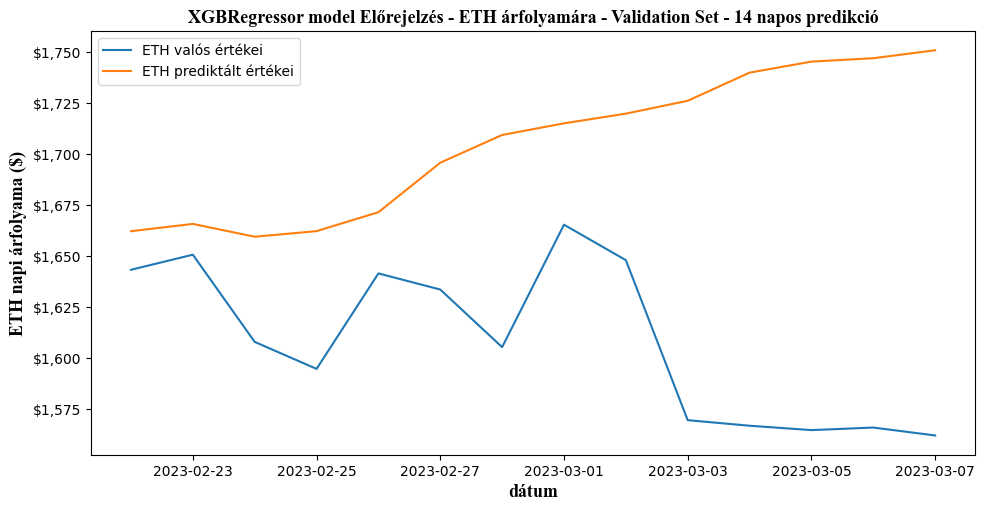

In [81]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(evaluation_df.true_values, label="ETH valós értékei")
ax.plot(evaluation_df.predicted_values, label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)
plt.tight_layout()
ax.set_title("XGBRegressor model Előrejelzés - ETH árfolyamára - Validation Set - 14 napos predikció", **font)
plt.savefig("charts/forecast/xgb_forecast_example.png")
plt.show()

## REAL WORLD PREDICTION

### 1 DAY

In [82]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)
eth_current_price.index = pd.to_datetime(eth_current_price.index)
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=0)] ## 1 day
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)
eth_current_price = eth_current_price[["eth_close"]]
eth_current_price = pd.concat([df.iloc[-1:][["eth_close"]], eth_current_price])
eth_current_price["logclose"] = np.log(eth_current_price.eth_close)
eth_current_price = pd.DataFrame(eth_current_price[["eth_close", "logclose"]])
eth_current_price

,eth_close,logclose
2023-03-07,1561.960000,7.353697
2023-03-08,1534.088257,7.335692


In [84]:
df_train

,eth_low,eth_high,eth_open,eth_volume,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,btc_close,btc_volume,...,us_treasury_10yt2y_diff,us_treasury_10yt3m_diff,news_sentiment,reddit_sentiment,twitter_sentiment,macd,signal,hist,obv,eth_close
date,,,,,,,,,,,,,,,,,,,,,
2017-09-02,-0.179934,-0.000178,0.005522,0.674269,0.574310,0.689382,0.453151,0.353899,-0.077995,0.505143,...,0.00,0.00,0.000000,0.405300,-0.034154,-2.470007,0.575782,-3.045789,-8240.32724,-0.124052
2017-09-03,0.000000,-0.071038,-0.123137,-0.450122,-0.477360,-0.289265,-0.093547,-0.123044,0.008226,-0.295816,...,0.00,0.00,0.000000,-0.279555,0.079918,-2.235462,0.013533,-2.248995,-5253.62211,-0.004001
2017-09-04,-0.177808,-0.063885,-0.012507,0.248817,0.105637,0.184946,0.276332,0.132810,-0.095079,0.701942,...,0.00,0.00,0.000000,0.071577,-0.140998,-6.543719,-1.297918,-5.245802,-6737.81061,-0.185974
2017-09-05,-0.128840,-0.069179,-0.168035,0.213858,0.180053,0.195228,0.378410,0.355945,0.062941,-0.126489,...,-0.04,-0.10,-0.217875,0.086044,0.057875,-2.958636,-1.630061,-1.328575,8344.41924,0.095128
2017-09-06,0.281368,0.045063,0.088309,-0.419337,-0.289996,-0.238569,-0.680628,-0.562807,0.056390,-0.420132,...,0.03,-0.01,0.000000,-0.127736,0.078222,-0.547661,-1.413581,0.865920,5486.30988,0.070839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-03,-0.047291,-0.017199,-0.010486,0.563021,0.518829,0.447536,0.528380,0.483844,-0.048503,0.290395,...,-0.08,-0.11,0.145015,-0.376600,-0.050198,-6.557431,-2.153053,-4.404378,-742816.59760,-0.048752
2023-03-04,0.003058,-0.044460,-0.048752,-1.139691,-1.143294,-0.824188,-1.134270,-1.137265,-0.000348,-0.970262,...,0.00,0.00,0.000000,0.000000,0.035352,-5.462718,-2.814986,-2.647732,-237640.26060,-0.001735
2023-03-05,0.002534,0.007100,-0.001728,0.230490,0.233624,0.132958,0.244556,0.247540,0.003737,0.244488,...,0.00,0.00,-0.548475,0.376600,-0.024841,-4.497313,-3.151451,-1.345862,-299240.74150,-0.001373


In [85]:
cols = ["eth_low", "eth_high", "eth_open", "ma_12", "ma_26", "rsi", "nasdaq_close","sp500_close", "btc_close", "eth_close"]

In [86]:
n_estimators = 1200 #250
learning_rate = 0.003 #0.0025 ## minél nagyobb, annál jobban tanul ha kisebb akkor kevésbé overfittel
max_depth = 30
min_child_weight = 0
subsample = 0.5 #0.5
colsample_bytree = 0.5
gamma = 0
reg_alpha = 0
reg_lambda = 0


In [108]:
scaler = StandardScaler()
train = df_train[cols]
scaler.fit(train)
train = scaler.transform(train)
n_past = 3
last_x = train[-n_past:]
last_x = last_x.flatten().reshape(1, train.shape[1]*n_past)
forecast_size = 1
n_future=1

In [92]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

# FOR TRAINING
for i in range(n_past, len(train) - n_future +1):
    trainX.append(train[i - n_past:i, :].flatten())
    trainY.append(train[i:i+1, :].flatten()) ## one step ahead always since incremental

trainX, trainY = np.array(trainX), np.array(trainY)

In [94]:
trainX.shape

(2010, 30)

In [95]:
trainY.shape ## első hármat ugye mindehol kivesszük.

(2010, 10)

In [97]:
# Fit XGBRegressor model on training set
model = XGBRegressor(n_estimators = n_estimators, learning_rate = learning_rate, max_depth=max_depth, min_child_weight = min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda, n_jobs=-1)
model.fit(trainX, trainY)
print("Model Fitted")

Model Fitted


In [109]:
last_x.shape

(1, 30)

In [111]:
eth_current_price

,eth_close,logclose
2023-03-07,1561.960000,7.353697
2023-03-08,1534.088257,7.335692


In [117]:
# multi-step forecast - Incremental
multistep_predictions = [] ##csak úgy tud prediktálni, ha megadom neki az elmúlt 14 napot mindig!:)

while len(multistep_predictions) < forecast_size:
    p = model.predict(last_x)
  # update the predictions list
    multistep_predictions.append(p)
    p = p.reshape(1, trainY.shape[1])
    train = np.concatenate([train, p])
    last_x = train[-n_past:]
    last_x = last_x.reshape(1, trainX.shape[1])

raw_all_prediction = pd.DataFrame(np.vstack(multistep_predictions))
raw_all_prediction = scaler.inverse_transform(raw_all_prediction) 

prediction = pd.DataFrame(raw_all_prediction).iloc[:, -1:]
prediction.index = eth_current_price.iloc[1:].index
prediction.columns = ["unscaled_predictions"]

evaluation_df = pd.merge(eth_current_price[["logclose"]], prediction, how="left", left_index=True, right_index=True)

##UN-DIFFERENCING here eth close is log close, ambigous little bit
x, x_diff = evaluation_df['logclose'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff

##EXP
evaluation_df["true_values"] = np.exp(evaluation_df.logclose)
evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
evaluation_df = evaluation_df[1:]

print(evaluation_df)
rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)    
mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])


print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

            logclose  unscaled_predictions  log_prediction  true_values  \
2023-03-08  7.335692              0.001787        7.355484  1534.088257   

            predicted_values  
2023-03-08       1564.754167  
RMSE: 30.6659
MSE: 940.398
MAE: 30.6659
MAPE: 1.999%


### 3 DAY

In [118]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)
eth_current_price.index = pd.to_datetime(eth_current_price.index)
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=2)] ## 3 day
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)
eth_current_price = eth_current_price[["eth_close"]]
eth_current_price = pd.concat([df.iloc[-1:][["eth_close"]], eth_current_price])
eth_current_price["logclose"] = np.log(eth_current_price.eth_close)
eth_current_price = pd.DataFrame(eth_current_price[["eth_close", "logclose"]])
eth_current_price

,eth_close,logclose
2023-03-07,1561.960000,7.353697
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841


In [122]:
df_train.head()

,eth_low,eth_high,eth_open,eth_volume,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,btc_close,btc_volume,...,us_treasury_10yt2y_diff,us_treasury_10yt3m_diff,news_sentiment,reddit_sentiment,twitter_sentiment,macd,signal,hist,obv,eth_close
date,,,,,,,,,,,,,,,,,,,,,
2017-09-02,-0.179934,-0.000178,0.005522,0.674269,0.574310,0.689382,0.453151,0.353899,-0.077995,0.505143,...,0.00,0.00,0.000000,0.405300,-0.034154,-2.470007,0.575782,-3.045789,-8240.32724,-0.124052
2017-09-03,0.000000,-0.071038,-0.123137,-0.450122,-0.477360,-0.289265,-0.093547,-0.123044,0.008226,-0.295816,...,0.00,0.00,0.000000,-0.279555,0.079918,-2.235462,0.013533,-2.248995,-5253.62211,-0.004001
2017-09-04,-0.177808,-0.063885,-0.012507,0.248817,0.105637,0.184946,0.276332,0.132810,-0.095079,0.701942,...,0.00,0.00,0.000000,0.071577,-0.140998,-6.543719,-1.297918,-5.245802,-6737.81061,-0.185974
2017-09-05,-0.128840,-0.069179,-0.168035,0.213858,0.180053,0.195228,0.378410,0.355945,0.062941,-0.126489,...,-0.04,-0.10,-0.217875,0.086044,0.057875,-2.958636,-1.630061,-1.328575,8344.41924,0.095128
2017-09-06,0.281368,0.045063,0.088309,-0.419337,-0.289996,-0.238569,-0.680628,-0.562807,0.056390,-0.420132,...,0.03,-0.01,0.000000,-0.127736,0.078222,-0.547661,-1.413581,0.865920,5486.30988,0.070839


In [123]:
cols = ["eth_low", "eth_high", "eth_open", "ma_12", "ma_26", "rsi", "nasdaq_close","sp500_close", "btc_close", "eth_close"]

In [124]:
n_estimators = 1200 #250
learning_rate = 0.003 #0.0025 ## minél nagyobb, annál jobban tanul ha kisebb akkor kevésbé overfittel
max_depth = 30
min_child_weight = 0
subsample = 0.5 #0.5
colsample_bytree = 0.5
gamma = 0
reg_alpha = 0
reg_lambda = 0


In [138]:
scaler = StandardScaler()
train = df_train[cols]
scaler.fit(train)
train = scaler.transform(train)
n_past = 5
last_x = train[-n_past:]
last_x = last_x.flatten().reshape(1, train.shape[1]*n_past)
forecast_size = 3
n_future=1

In [126]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

# FOR TRAINING
for i in range(n_past, len(train) - n_future +1):
    trainX.append(train[i - n_past:i, :].flatten())
    trainY.append(train[i:i+1, :].flatten()) ## one step ahead always since incremental

trainX, trainY = np.array(trainX), np.array(trainY)

In [127]:
trainX.shape

(2008, 50)

In [128]:
trainY.shape ## első hármat ugye mindehol kivesszük.

(2008, 10)

In [134]:
# Fit XGBRegressor model on training set
model = XGBRegressor(n_estimators = n_estimators, learning_rate = learning_rate, max_depth=max_depth, min_child_weight = min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda, n_jobs=-1)
model.fit(trainX, trainY)
print("Model Fitted")

Model Fitted


In [135]:
last_x.shape

(1, 50)

In [136]:
eth_current_price

,eth_close,logclose
2023-03-07,1561.960000,7.353697
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841


In [139]:
# multi-step forecast - Incremental
multistep_predictions = [] ##csak úgy tud prediktálni, ha megadom neki az elmúlt 14 napot mindig!:)

while len(multistep_predictions) < forecast_size:
    p = model.predict(last_x)
  # update the predictions list
    multistep_predictions.append(p)
    p = p.reshape(1, trainY.shape[1])
    train = np.concatenate([train, p])
    last_x = train[-n_past:]
    last_x = last_x.reshape(1, trainX.shape[1])

raw_all_prediction = pd.DataFrame(np.vstack(multistep_predictions))
raw_all_prediction = scaler.inverse_transform(raw_all_prediction) 

prediction = pd.DataFrame(raw_all_prediction).iloc[:, -1:]
prediction.index = eth_current_price.iloc[1:].index
prediction.columns = ["unscaled_predictions"]

evaluation_df = pd.merge(eth_current_price[["logclose"]], prediction, how="left", left_index=True, right_index=True)

##UN-DIFFERENCING here eth close is log close, ambigous little bit
x, x_diff = evaluation_df['logclose'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff

##EXP
evaluation_df["true_values"] = np.exp(evaluation_df.logclose)
evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
evaluation_df = evaluation_df[1:]

print(evaluation_df)
rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)    
mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])


print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

            logclose  unscaled_predictions  log_prediction  true_values  \
2023-03-08  7.335692              0.006821        7.360518  1534.088257   
2023-03-09  7.271468              0.003563        7.364081  1438.660767   
2023-03-10  7.264841             -0.001690        7.362391  1429.158081   

            predicted_values  
2023-03-08       1572.650952  
2023-03-09       1578.264939  
2023-03-10       1575.600064  
RMSE: 118.9141
MSE: 14140.5536
MAE: 108.203
MAPE: 7.4881%


### 7 DAY

In [190]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)
eth_current_price.index = pd.to_datetime(eth_current_price.index)
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=6)] ## 7 day
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)
eth_current_price = eth_current_price[["eth_close"]]
eth_current_price = pd.concat([df.iloc[-1:][["eth_close"]], eth_current_price])
eth_current_price["logclose"] = np.log(eth_current_price.eth_close)
eth_current_price = pd.DataFrame(eth_current_price[["eth_close", "logclose"]])
eth_current_price

,eth_close,logclose
2023-03-07,1561.960000,7.353697
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841
2023-03-11,1482.616699,7.301564
2023-03-12,1590.292969,7.371674
2023-03-13,1680.308960,7.426733
2023-03-14,1703.507080,7.440444


In [191]:
df_train

,eth_low,eth_high,eth_open,eth_volume,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,btc_close,btc_volume,...,us_treasury_10yt2y_diff,us_treasury_10yt3m_diff,news_sentiment,reddit_sentiment,twitter_sentiment,macd,signal,hist,obv,eth_close
date,,,,,,,,,,,,,,,,,,,,,
2017-09-02,-0.179934,-0.000178,0.005522,0.674269,0.574310,0.689382,0.453151,0.353899,-0.077995,0.505143,...,0.00,0.00,0.000000,0.405300,-0.034154,-2.470007,0.575782,-3.045789,-8240.32724,-0.124052
2017-09-03,0.000000,-0.071038,-0.123137,-0.450122,-0.477360,-0.289265,-0.093547,-0.123044,0.008226,-0.295816,...,0.00,0.00,0.000000,-0.279555,0.079918,-2.235462,0.013533,-2.248995,-5253.62211,-0.004001
2017-09-04,-0.177808,-0.063885,-0.012507,0.248817,0.105637,0.184946,0.276332,0.132810,-0.095079,0.701942,...,0.00,0.00,0.000000,0.071577,-0.140998,-6.543719,-1.297918,-5.245802,-6737.81061,-0.185974
2017-09-05,-0.128840,-0.069179,-0.168035,0.213858,0.180053,0.195228,0.378410,0.355945,0.062941,-0.126489,...,-0.04,-0.10,-0.217875,0.086044,0.057875,-2.958636,-1.630061,-1.328575,8344.41924,0.095128
2017-09-06,0.281368,0.045063,0.088309,-0.419337,-0.289996,-0.238569,-0.680628,-0.562807,0.056390,-0.420132,...,0.03,-0.01,0.000000,-0.127736,0.078222,-0.547661,-1.413581,0.865920,5486.30988,0.070839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-03,-0.047291,-0.017199,-0.010486,0.563021,0.518829,0.447536,0.528380,0.483844,-0.048503,0.290395,...,-0.08,-0.11,0.145015,-0.376600,-0.050198,-6.557431,-2.153053,-4.404378,-742816.59760,-0.048752
2023-03-04,0.003058,-0.044460,-0.048752,-1.139691,-1.143294,-0.824188,-1.134270,-1.137265,-0.000348,-0.970262,...,0.00,0.00,0.000000,0.000000,0.035352,-5.462718,-2.814986,-2.647732,-237640.26060,-0.001735
2023-03-05,0.002534,0.007100,-0.001728,0.230490,0.233624,0.132958,0.244556,0.247540,0.003737,0.244488,...,0.00,0.00,-0.548475,0.376600,-0.024841,-4.497313,-3.151451,-1.345862,-299240.74150,-0.001373


In [192]:
cols = ["eth_close"]

In [193]:
n_estimators = 1200 #250
learning_rate = 0.003 #0.0025 ## minél nagyobb, annál jobban tanul ha kisebb akkor kevésbé overfittel
max_depth = 30
min_child_weight = 0
subsample = 0.5 #0.5
colsample_bytree = 0.5
gamma = 0
reg_alpha = 0
reg_lambda = 0


In [194]:
scaler = StandardScaler()
train = df_train[cols]
scaler.fit(train)
train = scaler.transform(train)
n_past = 14
last_x = train[-n_past:]
last_x = last_x.flatten().reshape(1, train.shape[1]*n_past)
forecast_size = 7
n_future=1

In [195]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

# FOR TRAINING
for i in range(n_past, len(train) - n_future +1):
    trainX.append(train[i - n_past:i, :].flatten())
    trainY.append(train[i:i+1, :].flatten()) ## one step ahead always since incremental

trainX, trainY = np.array(trainX), np.array(trainY)

In [196]:
trainX.shape

(1999, 14)

In [197]:
trainY.shape ## első hármat ugye mindehol kivesszük.

(1999, 1)

In [198]:
# Fit XGBRegressor model on training set
model = XGBRegressor(n_estimators = n_estimators, learning_rate = learning_rate, max_depth=max_depth, min_child_weight = min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda, n_jobs=-1)
model.fit(trainX, trainY)
print("Model Fitted")

Model Fitted


In [199]:
last_x.shape

(1, 14)

In [200]:
eth_current_price

,eth_close,logclose
2023-03-07,1561.960000,7.353697
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841
2023-03-11,1482.616699,7.301564
2023-03-12,1590.292969,7.371674
2023-03-13,1680.308960,7.426733
2023-03-14,1703.507080,7.440444


In [201]:
# multi-step forecast - Incremental
multistep_predictions = [] ##csak úgy tud prediktálni, ha megadom neki az elmúlt 14 napot mindig!:)

while len(multistep_predictions) < forecast_size:
    p = model.predict(last_x)
  # update the predictions list
    multistep_predictions.append(p)
    p = p.reshape(1, trainY.shape[1])
    train = np.concatenate([train, p])
    last_x = train[-n_past:]
    last_x = last_x.reshape(1, trainX.shape[1])

raw_all_prediction = pd.DataFrame(np.vstack(multistep_predictions))
raw_all_prediction = scaler.inverse_transform(raw_all_prediction) 

prediction = pd.DataFrame(raw_all_prediction).iloc[:, -1:]
prediction.index = eth_current_price.iloc[1:].index
prediction.columns = ["unscaled_predictions"]

evaluation_df = pd.merge(eth_current_price[["logclose"]], prediction, how="left", left_index=True, right_index=True)

##UN-DIFFERENCING here eth close is log close, ambigous little bit
x, x_diff = evaluation_df['logclose'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff

##EXP
evaluation_df["true_values"] = np.exp(evaluation_df.logclose)
evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
evaluation_df = evaluation_df[1:]

print(evaluation_df)
rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)    
mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])


print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

            logclose  unscaled_predictions  log_prediction  true_values  \
2023-03-08  7.335692              0.011022        7.364719  1534.088257   
2023-03-09  7.271468              0.004482        7.369201  1438.660767   
2023-03-10  7.264841             -0.004651        7.364550  1429.158081   
2023-03-11  7.301564              0.007385        7.371934  1482.616699   
2023-03-12  7.371674              0.007809        7.379744  1590.292969   
2023-03-13  7.426733              0.001426        7.381170  1680.308960   
2023-03-14  7.440444              0.007151        7.388321  1703.507080   

            predicted_values  
2023-03-08       1579.271453  
2023-03-09       1586.366061  
2023-03-10       1579.004141  
2023-03-11       1590.707138  
2023-03-12       1603.178622  
2023-03-13       1605.467504  
2023-03-14       1616.989554  
RMSE: 100.8877
MSE: 10178.3322
MAE: 89.2957
MAPE: 5.9044%


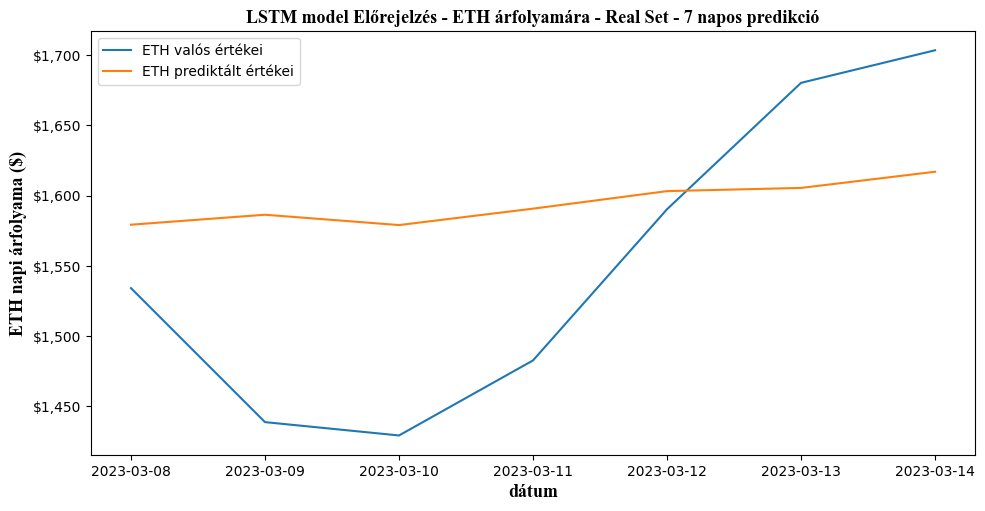

In [204]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(evaluation_df["true_values"], label="ETH valós értékei")
ax.plot(evaluation_df["predicted_values"], label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)
plt.tight_layout()
ax.set_title("LSTM model Előrejelzés - ETH árfolyamára - Real Set - 7 napos predikció", **font)
plt.savefig("charts/forecast/xgb_realword_7.png")
plt.show()

### 14 DAY

In [205]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)
eth_current_price.index = pd.to_datetime(eth_current_price.index)
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=13)] ## 1 day
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)
eth_current_price = eth_current_price[["eth_close"]]
eth_current_price = pd.concat([df.iloc[-1:][["eth_close"]], eth_current_price])
eth_current_price["logclose"] = np.log(eth_current_price.eth_close)
eth_current_price = pd.DataFrame(eth_current_price[["eth_close", "logclose"]])
eth_current_price

,eth_close,logclose
2023-03-07,1561.960000,7.353697
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841
2023-03-11,1482.616699,7.301564
2023-03-12,1590.292969,7.371674
2023-03-13,1680.308960,7.426733
2023-03-14,1703.507080,7.440444
2023-03-15,1656.180542,7.412269
2023-03-16,1677.215454,7.424890


In [206]:
df_train

,eth_low,eth_high,eth_open,eth_volume,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,btc_close,btc_volume,...,us_treasury_10yt2y_diff,us_treasury_10yt3m_diff,news_sentiment,reddit_sentiment,twitter_sentiment,macd,signal,hist,obv,eth_close
date,,,,,,,,,,,,,,,,,,,,,
2017-09-02,-0.179934,-0.000178,0.005522,0.674269,0.574310,0.689382,0.453151,0.353899,-0.077995,0.505143,...,0.00,0.00,0.000000,0.405300,-0.034154,-2.470007,0.575782,-3.045789,-8240.32724,-0.124052
2017-09-03,0.000000,-0.071038,-0.123137,-0.450122,-0.477360,-0.289265,-0.093547,-0.123044,0.008226,-0.295816,...,0.00,0.00,0.000000,-0.279555,0.079918,-2.235462,0.013533,-2.248995,-5253.62211,-0.004001
2017-09-04,-0.177808,-0.063885,-0.012507,0.248817,0.105637,0.184946,0.276332,0.132810,-0.095079,0.701942,...,0.00,0.00,0.000000,0.071577,-0.140998,-6.543719,-1.297918,-5.245802,-6737.81061,-0.185974
2017-09-05,-0.128840,-0.069179,-0.168035,0.213858,0.180053,0.195228,0.378410,0.355945,0.062941,-0.126489,...,-0.04,-0.10,-0.217875,0.086044,0.057875,-2.958636,-1.630061,-1.328575,8344.41924,0.095128
2017-09-06,0.281368,0.045063,0.088309,-0.419337,-0.289996,-0.238569,-0.680628,-0.562807,0.056390,-0.420132,...,0.03,-0.01,0.000000,-0.127736,0.078222,-0.547661,-1.413581,0.865920,5486.30988,0.070839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-03,-0.047291,-0.017199,-0.010486,0.563021,0.518829,0.447536,0.528380,0.483844,-0.048503,0.290395,...,-0.08,-0.11,0.145015,-0.376600,-0.050198,-6.557431,-2.153053,-4.404378,-742816.59760,-0.048752
2023-03-04,0.003058,-0.044460,-0.048752,-1.139691,-1.143294,-0.824188,-1.134270,-1.137265,-0.000348,-0.970262,...,0.00,0.00,0.000000,0.000000,0.035352,-5.462718,-2.814986,-2.647732,-237640.26060,-0.001735
2023-03-05,0.002534,0.007100,-0.001728,0.230490,0.233624,0.132958,0.244556,0.247540,0.003737,0.244488,...,0.00,0.00,-0.548475,0.376600,-0.024841,-4.497313,-3.151451,-1.345862,-299240.74150,-0.001373


In [207]:
cols = ["eth_low", "eth_high", "eth_open", "ma_12", "ma_26", "rsi", "nasdaq_close","sp500_close", "btc_close", "eth_close"]

In [208]:
n_estimators = 1200 #250
learning_rate = 0.003 #0.0025 ## minél nagyobb, annál jobban tanul ha kisebb akkor kevésbé overfittel
max_depth = 30
min_child_weight = 0
subsample = 0.5 #0.5
colsample_bytree = 0.5
gamma = 0
reg_alpha = 0
reg_lambda = 0


In [209]:
scaler = StandardScaler()
train = df_train[cols]
scaler.fit(train)
train = scaler.transform(train)
n_past = 30
last_x = train[-n_past:]
last_x = last_x.flatten().reshape(1, train.shape[1]*n_past)
forecast_size = 14
n_future=1

In [210]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

# FOR TRAINING
for i in range(n_past, len(train) - n_future +1):
    trainX.append(train[i - n_past:i, :].flatten())
    trainY.append(train[i:i+1, :].flatten()) ## one step ahead always since incremental

trainX, trainY = np.array(trainX), np.array(trainY)

In [211]:
trainX.shape

(1983, 300)

In [212]:
trainY.shape ## első hármat ugye mindehol kivesszük.

(1983, 10)

In [213]:
# Fit XGBRegressor model on training set
model = XGBRegressor(n_estimators = n_estimators, learning_rate = learning_rate, max_depth=max_depth, min_child_weight = min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda, n_jobs=-1)
model.fit(trainX, trainY)
print("Model Fitted")

Model Fitted


In [214]:
last_x.shape

(1, 300)

In [215]:
eth_current_price

,eth_close,logclose
2023-03-07,1561.960000,7.353697
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841
2023-03-11,1482.616699,7.301564
2023-03-12,1590.292969,7.371674
2023-03-13,1680.308960,7.426733
2023-03-14,1703.507080,7.440444
2023-03-15,1656.180542,7.412269
2023-03-16,1677.215454,7.424890


In [216]:
# multi-step forecast - Incremental
multistep_predictions = [] ##csak úgy tud prediktálni, ha megadom neki az elmúlt 14 napot mindig!:)

while len(multistep_predictions) < forecast_size:
    p = model.predict(last_x)
  # update the predictions list
    multistep_predictions.append(p)
    p = p.reshape(1, trainY.shape[1])
    train = np.concatenate([train, p])
    last_x = train[-n_past:]
    last_x = last_x.reshape(1, trainX.shape[1])

raw_all_prediction = pd.DataFrame(np.vstack(multistep_predictions))
raw_all_prediction = scaler.inverse_transform(raw_all_prediction) 

prediction = pd.DataFrame(raw_all_prediction).iloc[:, -1:]
prediction.index = eth_current_price.iloc[1:].index
prediction.columns = ["unscaled_predictions"]

evaluation_df = pd.merge(eth_current_price[["logclose"]], prediction, how="left", left_index=True, right_index=True)

##UN-DIFFERENCING here eth close is log close, ambigous little bit
x, x_diff = evaluation_df['logclose'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff

##EXP
evaluation_df["true_values"] = np.exp(evaluation_df.logclose)
evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
evaluation_df = evaluation_df[1:]

print(evaluation_df)
rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)    
mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])


print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

            logclose  unscaled_predictions  log_prediction  true_values  \
2023-03-08  7.335692              0.000812        7.354509  1534.088257   
2023-03-09  7.271468              0.003618        7.358127  1438.660767   
2023-03-10  7.264841              0.006624        7.364750  1429.158081   
2023-03-11  7.301564              0.005293        7.370043  1482.616699   
2023-03-12  7.371674              0.001158        7.371201  1590.292969   
2023-03-13  7.426733             -0.000043        7.371158  1680.308960   
2023-03-14  7.440444              0.001522        7.372680  1703.507080   
2023-03-15  7.412269              0.002668        7.375348  1656.180542   
2023-03-16  7.424890             -0.001550        7.373798  1677.215454   
2023-03-17  7.491358              0.003260        7.377059  1792.485107   
2023-03-18  7.474012              0.003305        7.380363  1761.659668   
2023-03-19  7.487497              0.002061        7.382424  1785.576538   
2023-03-20  7.458948     

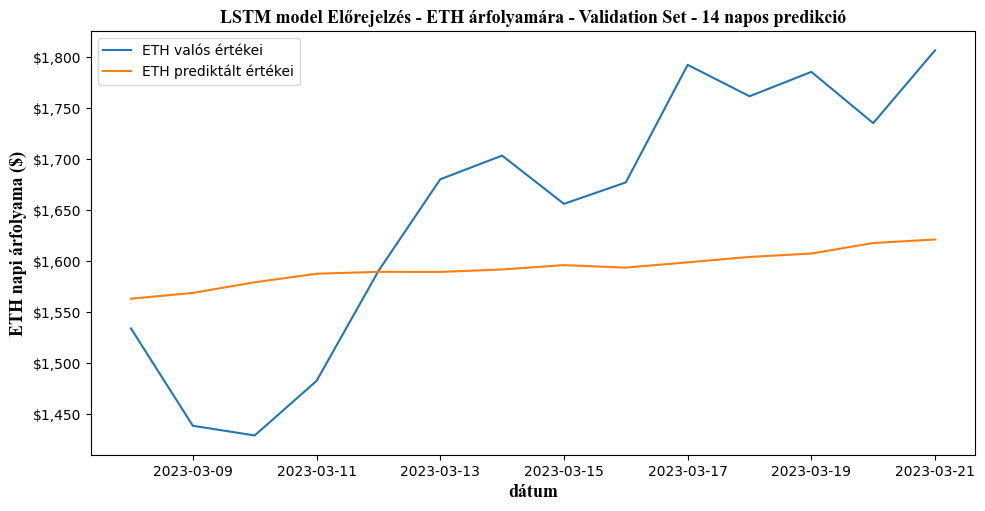

In [217]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(evaluation_df["true_values"], label="ETH valós értékei")
ax.plot(evaluation_df["predicted_values"], label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)
plt.tight_layout()
ax.set_title("LSTM model Előrejelzés - ETH árfolyamára - Validation Set - 14 napos predikció", **font)
plt.savefig("charts/forecast/xgb_realword_14.png")
plt.show()

# TIMESERIES VISUALS WORKS

backup

In [ ]:
def gridsearch_timeseriessplit(dataframe, original_df, columns, test_size=1, **kwargs):
    
    tss = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=0)
    
    columns = columns
    lag_columns = []

    for col in columns:
        for i in range(1, 4):
            lag_columns.append(f"lag_{i}_{col}")
    
    dataframe = dataframe[lag_columns + columns]
    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []
    
    df_log = np.log(original_df[4:]) # original df
    cols = dataframe.columns.to_list()
    # standardscalerhez

    train_cols = [c for c in dataframe if "lag_" in c]
    prediction_cols = [c for c in dataframe if "lag_" not in c]
    
    for train_idx, val_idx in tss.split(dataframe):
        #scaler = StandardScaler()
        train = dataframe.iloc[train_idx]
        test = dataframe.iloc[val_idx]

        ## Original LOG values

        original_logs = pd.DataFrame()
        original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
        original_logs = original_logs[["eth_close"]]    

        ##SCALING
        #scaler.fit(train[cols])
        #train[cols] = scaler.transform(train[cols])
        #test[cols]= scaler.transform(test[cols])

        train = pd.DataFrame(train, columns=cols)
        test = pd.DataFrame(test, columns=cols)

        # Separate target variables from predictor variables
        X_train, y_train = train[train_cols], train[prediction_cols]
        X_test, y_test = test[train_cols], test[prediction_cols]

        # Fit XGBRegressor model on training set
        model = XGBRegressor(**kwargs)
        model.fit(X_train, y_train)
        print("Model Fitted")
        
        # multi-step forecast
        multistep_predictions = []

        # first test input
        last_x = X_test.iloc[0:1] ##lagging features first

        while len(multistep_predictions) < test_size:
            p = model.predict(last_x)
          # update the predictions list
            multistep_predictions.append(p)
            p = pd.DataFrame(p, columns=prediction_cols) ## prediktált értékek -> lag_1 és alakítása jön
            # make the new input
            last_x = csusztatas_1(last_x, p) ## refactor last_x  then predict based on it
            last_x = last_x[-1:]
       
        raw_all_prediction = pd.DataFrame(np.vstack(multistep_predictions))
        
        
        #just_for_unscale = pd.DataFrame(np.zeros((len(y_test), len(train_cols)))) ## itt lesz vmi bajocska
        #just_for_unscale.columns = ['dummy' for _ in just_for_unscale.columns]
        #raw_all_prediction = pd.merge(just_for_unscale, raw_all_prediction, how="left", left_index=True, right_index=True)
        #raw_all_prediction = scaler.inverse_transform(raw_all_prediction) 

        prediction = raw_all_prediction.iloc[:, -1:]
        prediction.index = test.index
        prediction.columns = ["unscaled_predictions"]

        evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    


        ##UN-DIFFERENCING
        x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
        evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff

        ##EXP
        evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
        evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
        evaluation_df = evaluation_df[1:]

        print(evaluation_df)

        try:
            rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
            root_mean_squared_errors.append(rmse)
            mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
            mean_squared_errors.append(mse)        
            mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
            mean_absolute_errors.append(mae)
            mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
            mean_absolute_percentage_errors.append(mape)
        except:
            rmse = np.nan
            results = np.nan
            mse = np.nan
            mae = np.nan
            mape = np.nan


    print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
    
    return model, evaluation_df, rmse, mse, mae, mape
        

In [ ]:
##backup standardscaler version

In [ ]:
def gridsearch_timeseriessplit(dataframe, original_df, columns, test_size=1, **kwargs):
    
    tss = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=0)
    
    columns = columns
    lag_columns = []

    for col in columns:
        for i in range(1, 4):
            lag_columns.append(f"lag_{i}_{col}")
    
    dataframe = dataframe[lag_columns + columns]
    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []
    
    df_log = np.log(original_df[4:]) # original df
    cols = dataframe.columns.to_list()
    # standardscalerhez

    train_cols = [c for c in dataframe if "lag_" in c]
    prediction_cols = [c for c in dataframe if "lag_" not in c]
    
    for train_idx, val_idx in tss.split(dataframe):
        scaler = StandardScaler()
        train = dataframe.iloc[train_idx]
        test = dataframe.iloc[val_idx]

        ## Original LOG values

        original_logs = pd.DataFrame()
        original_logs = pd.concat([df_log.iloc[train_idx].iloc[-1:], df_log.iloc[val_idx]])
        original_logs = original_logs[["eth_close"]]    

        ##SCALING
        scaler.fit(train[cols])
        train[cols] = scaler.transform(train[cols])
        test[cols]= scaler.transform(test[cols])

        train = pd.DataFrame(train, columns=cols)
        test = pd.DataFrame(test, columns=cols)

        # Separate target variables from predictor variables
        X_train, y_train = train[train_cols], train[prediction_cols]
        X_test, y_test = test[train_cols], test[prediction_cols]

        # Fit XGBRegressor model on training set
        model = XGBRegressor(**kwargs)
        model.fit(X_train, y_train)
        print("Model Fitted")
        
        # multi-step forecast
        multistep_predictions = []

        # first test input
        last_x = X_test.iloc[0:1] ##lagging features first

        while len(multistep_predictions) < test_size:
            p = model.predict(last_x)
          # update the predictions list
            multistep_predictions.append(p)
            p = pd.DataFrame(p, columns=prediction_cols) ## prediktált értékek -> lag_1 és alakítása jön
            # make the new input
            last_x = csusztatas_1(last_x, p) ## refactor last_x  then predict based on it
            last_x = last_x[-1:]
       
        raw_all_prediction = pd.DataFrame(np.vstack(multistep_predictions))
        
        
        raw_all_prediction = pd.DataFrame(np.vstack(multistep_predictions))
        just_for_unscale = pd.DataFrame(np.zeros((len(y_test), len(train_cols)))) ## itt lesz vmi bajocska
        just_for_unscale.columns = ['dummy' for _ in just_for_unscale.columns]
        raw_all_prediction = pd.merge(just_for_unscale, raw_all_prediction, how="left", left_index=True, right_index=True)
        raw_all_prediction = scaler.inverse_transform(raw_all_prediction) 

        prediction = pd.DataFrame(raw_all_prediction).iloc[:, -1:]
        prediction.index = test.index
        prediction.columns = ["unscaled_predictions"]
        
        
        evaluation_df = pd.merge(original_logs[["eth_close"]], prediction, how="left", left_index=True, right_index=True)    


        ##UN-DIFFERENCING
        x, x_diff = evaluation_df['eth_close'].iloc[0], evaluation_df['unscaled_predictions'].iloc[1:]
        evaluation_df["log_prediction"] = np.r_[x, x_diff].cumsum().astype('float64') ## credit to: https://stackoverflow.com/questions/49903037/pandas-reverse-of-diff

        ##EXP
        evaluation_df["true_values"] = np.exp(evaluation_df.eth_close)
        evaluation_df["predicted_values"] = np.exp(evaluation_df.log_prediction)
        evaluation_df = evaluation_df[1:]

        print(evaluation_df)

        try:
            rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
            root_mean_squared_errors.append(rmse)
            mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)
            mean_squared_errors.append(mse)        
            mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
            mean_absolute_errors.append(mae)
            mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
            mean_absolute_percentage_errors.append(mape)
        except:
            rmse = np.nan
            results = np.nan
            mse = np.nan
            mae = np.nan
            mape = np.nan


    print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
    return model, evaluation_df, rmse, mse, mae, mape
        

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=0)
df = df.sort_index()

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['eth_close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['eth_close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
df_visual = df.tail(200)

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df_visual):
    train = df_visual.iloc[train_idx]
    test = df_visual.iloc[val_idx]
    train['eth_close'].plot(ax=axs[fold],
                          label='Tanulási Szett',
                          title=f'Tanulási/Validálási adatok felbontása - {fold}')
    test['eth_close'].plot(ax=axs[fold],
                         label='Validálási Szett')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
axs[4].set_xlabel("dátum",  {'fontname':'Times New Roman', 'size': 18, 'weight' : 'bold'})
plt.savefig("charts/forecast/train_test_split.png")
plt.show()

In [ ]:
## ANOTHER WAY

In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Load time series data into a pandas DataFrame
df = pd.read_csv('my_time_series_data.csv')

# Create lagged versions of target variables
df['y1_lag1'] = df['y1'].shift(1)
df['y1_lag2'] = df['y1'].shift(2)
df['y2_lag1'] = df['y2'].shift(1)
df['y2_lag2'] = df['y2'].shift(2)
df = df.dropna()

# Split DataFrame into training and test sets
train_size = int(len(df) * 0.7)
train, test = df[:train_size], df[train_size:]

# Separate target variables from predictor variables
X_train, y_train = train[['y1_lag1', 'y1_lag2', 'y2_lag1', 'y2_lag2']], train[['y1', 'y2']]
X_test, y_test = test[['y1_lag1', 'y1_lag2', 'y2_lag1', 'y2_lag2']], test[['y1', 'y2']]

# Fit XGBRegressor model on training set
model = XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on test set and evaluate performance
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

# Predict future values
future_values = []
last_observations = df.iloc[-1][['y1', 'y2']]
for i in range(12):  # Predict 12 future values
    X_future = pd.DataFrame({'y1_lag1': [last_observations['y1']], 'y1_lag2': [df.iloc[-2]['y1']],
                             'y2_lag1': [last_observations['y2']], 'y2_lag2': [df.iloc[-2]['y2']]})
    future_value = model.predict(X_future)
    future_values.append(future_value)
    last_observations = pd.Series(future_value, index=['y1', 'y2'])

print('Predicted future values:', future_values)
